In [18]:
import openvino

In [2]:
import cv2
cv2.__version__

'4.4.0-openvino'

#### Accessable videos

In [3]:
!ls *.avi

terrace1-c0.avi  terrace1-c1.avi  terrace1-c2.avi


In [4]:
TEST_VIDEO = 'terrace1-c0.avi'

In [5]:
from IPython.display import clear_output, Image, display, HTML
import cv2

video = cv2.VideoCapture(TEST_VIDEO)
display_handle=display(None, display_id=True)

try:
    ret = True
    while ret:
        ret, frame = video.read()
        if ret:
            display_handle.update(Image(data=cv2.imencode('.jpeg', frame)[1]))
except:
    pass
            
video.release()
display_handle.update(None)

None

In [6]:
!python3 ${INTEL_OPENVINO_DIR}/deployment_tools/open_model_zoo/tools/downloader/downloader.py \
--name ssd_mobilenet_v2_coco \
--output_dir ./data

################|| Downloading models ||################

========== Downloading data/public/ssd_mobilenet_v2_coco/ssd_mobilenet_v2_coco.tar.gz
^C. 0%, 1440 KB, 5513 KB/s, 0 seconds passed

Traceback (most recent call last):
  File "/opt/intel/openvino/deployment_tools/open_model_zoo/tools/downloader/downloader.py", line 352, in <module>
    main()
  File "/opt/intel/openvino/deployment_tools/open_model_zoo/tools/downloader/downloader.py", line 323, in main
    for model in models]
  File "/opt/intel/openvino/deployment_tools/open_model_zoo/tools/downloader/downloader.py", line 323, in <listcomp>
    for model in models]
  File "/opt/intel/openvino/deployment_tools/open_model_zoo/tools/downloader/downloader.py", line 226, in download_model
    functools.partial(model_file.source.start_download, session, CHUNK_SIZE)):
  File "/opt/intel/openvino/deployment_tools/open_model_zoo/tools/downloader/downloader.py", line 198, in try_retrieve
    actual_hash = try_download(reporter, f, num_atte

In [7]:
!ls ./data

public


In [8]:
!python3 ${INTEL_OPENVINO_DIR}/deployment_tools/open_model_zoo/tools/downloader/downloader.py --print_all

action-recognition-0001-decoder
action-recognition-0001-encoder
age-gender-recognition-retail-0013
asl-recognition-0004
bert-large-uncased-whole-word-masking-squad-fp32-0001
bert-large-uncased-whole-word-masking-squad-int8-0001
bert-small-uncased-whole-word-masking-squad-0001
driver-action-recognition-adas-0002-decoder
driver-action-recognition-adas-0002-encoder
emotions-recognition-retail-0003
face-detection-0100
face-detection-0102
face-detection-0104
face-detection-0105
face-detection-0106
face-detection-adas-0001
face-detection-adas-binary-0001
face-detection-retail-0004
face-detection-retail-0005
facial-landmarks-35-adas-0002
faster-rcnn-resnet101-coco-sparse-60-0001
gaze-estimation-adas-0002
handwritten-japanese-recognition-0001
handwritten-score-recognition-0003
head-pose-estimation-adas-0001
human-pose-estimation-0001
icnet-camvid-ava-0001
icnet-camvid-ava-sparse-30-0001
icnet-camvid-ava-sparse-60-0001
image-retrieval-0001
instance-segmentation-security-0010
instance-segmentati

In [ ]:
!python3 ${INTEL_OPENVINO_DIR}/deployment_tools/open_model_zoo/tools/downloader/downloader.py \
--name ssd_mobilenet_v2_coco \
--output_dir ./data 

In [6]:
import tensorflow as tf
import time
import os

WORKSHOP_DATA_PATH = os.path.join('.', 'data')
SSD_ASSETS = os.path.join(WORKSHOP_DATA_PATH, 'public', 'ssd_mobilenet_v2_coco')
TF_MODEL = os.path.join(SSD_ASSETS, 'ssd_mobilenet_v2_coco_2018_03_29', 'frozen_inference_graph.pb')
WIDTH = 300
PROBABILITY_THRESHOLD = .5


def tf_inference(graph: tf.Graph, input_data, input_name: str, outputs_names: list) -> tuple:
    """
    Returns TensorFlow model inference results.
    """
  
    # Get the input tensor by name
    input_tensor =  graph.get_tensor_by_name('{}:0'.format(input_name))
    
    # Fill input data
    feed_dict = {
        input_tensor: [input_data, ] 
    }

    # Collect output tensors
    output_tensors = []
    
    for output_name in outputs_names:
        tensor = graph.get_tensor_by_name('{}:0'.format(output_name))
        output_tensors.append(tensor)
    
    # Run inference and get performance
    with graph.as_default():
        with tf.Session(graph=graph) as session:
            inference_start = time.time()
            outputs = session.run(output_tensors, feed_dict=feed_dict)
            inference_end = time.time()
    
    # Collect inference results
    res = dict(zip(outputs_names, outputs))
    
    return res, inference_end - inference_start

In [7]:
import numpy as np

def tf_main(path_to_pb_model: str, 
            raw_image: np.ndarray):
    """
    Entrypoint to infer with TensorFlow.
    """
    
    # Size of the image is 300x300 pixels, 3 channels in the RGB format
    
    image_shape = (WIDTH, WIDTH, 3)
    
    resized_image = cv2.resize(raw_image, (WIDTH, WIDTH), interpolation=cv2.INTER_NEAREST)
    
    reshaped_image = np.reshape(resized_image, image_shape)
        
    graph = tf.Graph()
    
    graph_def = tf.GraphDef()

    with open(path_to_pb_model, "rb") as model_file:
        graph_def.ParseFromString(model_file.read())

    with graph.as_default():
        tf.import_graph_def(graph_def, name='')

    input_layer = 'image_tensor'
    
    output_layers = ['num_detections', 'detection_classes', 'detection_scores', 'detection_boxes']
    
    raw_results, inference_time = tf_inference(graph, reshaped_image, input_layer, output_layers)
    
    return raw_results, inference_time


In [8]:
tensorflow_predictions, tensorflow_average_inference_time = tf_main(TF_MODEL, frame)
tensorflow_average_fps = 1 / tensorflow_average_inference_time
print(f'Average FPS {tensorflow_average_fps} ')

Average FPS 0.3508505837006165 


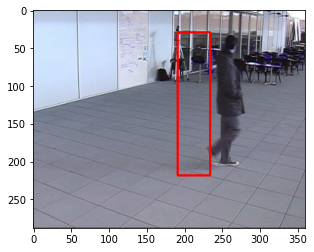

In [9]:
from matplotlib import pyplot as plt

num_detections = tensorflow_predictions['num_detections']
classes = tensorflow_predictions['detection_classes'][0]
scores = tensorflow_predictions['detection_scores'][0]

indexes = np.logical_and(scores>.6, classes==1)
boxes = tensorflow_predictions['detection_boxes'][0]
output_frame = frame.copy()
for box in boxes[indexes]:
    y1,x1,y2,x2 = np.int32(box*WIDTH)
    cv2.rectangle(output_frame, (x1,y1), (x2,y2), (255,0,0), 2)
    
plt.imshow(output_frame)

### Use OpenVINO

In [18]:
!python3 ${INTEL_OPENVINO_DIR}/deployment_tools/model_optimizer/mo.py \
--output_dir=data/public/ssd_mobilenet_v2_coco/FP32 \
--reverse_input_channels \
--model_name=ssd_mobilenet_v2_coco \
--data_type=FP32 \
--transformations_config=${INTEL_OPENVINO_DIR}/deployment_tools/model_optimizer/extensions/front/tf/ssd_v2_support.json \
--tensorflow_object_detection_api_pipeline_config=data/public/ssd_mobilenet_v2_coco/ssd_mobilenet_v2_coco_2018_03_29/pipeline.config \
--output=detection_classes,detection_scores,detection_boxes,num_detections \
--input_model=data/public/ssd_mobilenet_v2_coco/ssd_mobilenet_v2_coco_2018_03_29/frozen_inference_graph.pb

Model Optimizer arguments:
Common parameters:
	- Path to the Input Model: 	/home/vino/data/public/ssd_mobilenet_v2_coco/ssd_mobilenet_v2_coco_2018_03_29/frozen_inference_graph.pb
	- Path for generated IR: 	/home/vino/data/public/ssd_mobilenet_v2_coco/FP32
	- IR output name: 	ssd_mobilenet_v2_coco
	- Log level: 	ERROR
	- Batch: 	Not specified, inherited from the model
	- Input layers: 	Not specified, inherited from the model
	- Output layers: 	detection_classes,detection_scores,detection_boxes,num_detections
	- Input shapes: 	Not specified, inherited from the model
	- Mean values: 	Not specified
	- Scale values: 	Not specified
	- Scale factor: 	Not specified
	- Precision of IR: 	FP32
	- Enable fusing: 	True
	- Enable grouped convolutions fusing: 	True
	- Move mean values to preprocess section: 	False
	- Reverse input channels: 	True
TensorFlow specific parameters:
	- Input model in text protobuf format: 	False
	- Path to model dump for TensorBoard: 	None
	- List of shared libraries with

In [8]:
from openvino.inference_engine import IECore, IENetwork
import numpy as np
import time

def openvino_net(path_to_model_xml: str, path_to_model_bin: str, device='CPU', batch=1):
    ie = IECore()

    # First, create a network (Note: you need to provide model in the IR previously converted with Model Optimizer)
    net = ie.read_network(model=path_to_model_xml, weights=path_to_model_bin)

    # Get input and output blob of the network
    input_blob = next(iter(net.inputs))
    out_blob = next(iter(net.outputs))

    # Reshape the network to the needed batch
    n, c, h, w = net.inputs[input_blob].shape
    
    net.reshape({input_blob: (batch, c, h, w)})
    
    n, c, h, w = net.inputs[input_blob].shape
    exec_net = ie.load_network(network=net, device_name=device)
    del net
    return (exec_net, input_blob, out_blob)

def ie_inference(exec_net, image: np.ndarray, input_blob:str, out_blob: str):

    
    # Read and preprocess the input image
    resized_image = image[..., ::-1]
    in_frame = resized_image.transpose((2, 0, 1))  # Change data layout from HWC to CHW

    # Now we run an inference on the target device
    inference_start = time.time()
    res = exec_net.infer(inputs={input_blob: [in_frame]})
    inference_end = time.time()

    return res[out_blob], inference_end - inference_start

In [9]:
def run_on_image(xml:str, bin:str, device:str, image: np.ndarray, prints=True):
    net, input_blob, output_blob = openvino_net(xml, bin)
    resized_image = cv2.resize(frame, (WIDTH, WIDTH), interpolation=cv2.INTER_NEAREST)
    predictions, inference_time = ie_inference(net, resized_image, input_blob, output_blob)
        
    if prints:
        print('Inference Time of SSD MobileNet V2: {} seconds'.format(inference_time))
    inference_engine_fps = 1 / inference_time

    if prints:
        print('Frames per second (FPS): {}'.format(inference_engine_fps))
    
    return inference_engine_fps, predictions

In [12]:
device = 'CPU'
IE_MODEL_FP16_XML = os.path.join(SSD_ASSETS, 'FP32', 'ssd_mobilenet_v2_coco.xml')
IE_MODEL_FP16_BIN = os.path.join(SSD_ASSETS, 'FP32', 'ssd_mobilenet_v2_coco.bin')
# Run the inference 

inference_engine_average_fps, preds = run_on_image(IE_MODEL_FP16_XML, 
                                                   IE_MODEL_FP16_BIN, 
                                                   device, frame)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: DeprecationWarning: 'inputs' property of IENetwork class is deprecated. To access DataPtrs user need to use 'input_data' property of InputInfoPtr objects which can be accessed by 'input_info' property.
  if sys.path[0] == '':


Inference Time of SSD MobileNet V2: 0.03131866455078125 seconds
Frames per second (FPS): 31.929841656516444


In [13]:
def postprocessing(preds: np.ndarray, prob_thresh:float, frame_for_output: np.ndarray):
    indexes = np.logical_and(preds[:,2]>prob_thresh, preds[:,1]==1.)
    for pred in preds[indexes]:
        x1,y1,x2,y2 = np.int32(pred[3:7]*WIDTH)
        cv2.rectangle(frame_for_output, (x1,y1), (x2,y2), (255,0,0), 2)
    return frame_for_output, preds[indexes]

In [ ]:
from matplotlib import pyplot as plt
frame_for_output = cv2.resize(frame, (WIDTH, WIDTH), interpolation=cv2.INTER_NEAREST).copy()
frame_for_output = postprocessing(preds[0][0], PROBABILITY_THRESHOLD, frame_for_output)
    
plt.imshow(frame_for_output)

In [12]:
from IPython.display import clear_output, Image, display, HTML
import cv2

video = cv2.VideoCapture(TEST_VIDEO)
display_handle=display(None, display_id=True)

net, input_blob, output_blob = openvino_net(IE_MODEL_FP16_XML, IE_MODEL_FP16_BIN)

try:
    ret = True
    while ret:
        ret, frame = video.read()
        
        if ret:
            inference_start = time.time()
            resized_image = cv2.resize(frame, (WIDTH, WIDTH), interpolation=cv2.INTER_NEAREST)
            predictions, inference_time = ie_inference(net, resized_image, input_blob, output_blob)
            inference_end = time.time()

            frame_for_output = resized_image

            frame_for_output = postprocessing(predictions[0][0], .7, frame_for_output)

            print(1/(inference_end-inference_start))
            display_handle.update(Image(data=cv2.imencode('.jpeg', frame_for_output)[1]))
except Exception as e:
    pass
            
video.release()
display_handle.update(None)

None

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: DeprecationWarning: 'inputs' property of IENetwork class is deprecated. To access DataPtrs user need to use 'input_data' property of InputInfoPtr objects which can be accessed by 'input_info' property.
  if sys.path[0] == '':


33.55577423096924


In [ ]:
!pip3 install -r sort_requirements.txt

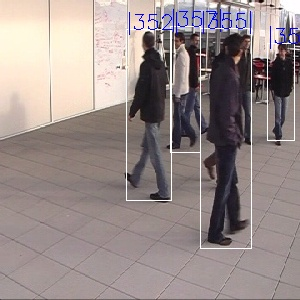

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: DeprecationWarning: 'inputs' property of IENetwork class is deprecated. To access DataPtrs user need to use 'input_data' property of InputInfoPtr objects which can be accessed by 'input_info' property.
  if sys.path[0] == '':


1
[-1.35216473e-09  9.82878436e-02  1.12471180e-01  6.80187977e-01
  1.55000000e+02]
1
[7.06611029e-04 9.70953295e-02 1.16003196e-01 6.77438992e-01
 1.55000000e+02]
1
[2.36773665e-03 9.28587328e-02 1.25060925e-01 6.81753182e-01
 1.55000000e+02]
1
[4.96993525e-03 9.23402467e-02 1.28734345e-01 6.76020530e-01
 1.55000000e+02]
1
[1.28322047e-02 9.60846757e-02 1.35333674e-01 6.75760057e-01
 1.55000000e+02]
1
[2.00405408e-02 1.02002976e-01 1.39760416e-01 6.83966910e-01
 1.55000000e+02]
1
[4.24028794e-02 9.50929734e-02 1.63550429e-01 6.81847195e-01
 1.55000000e+02]
1
[5.37821690e-02 9.52083308e-02 1.80101893e-01 6.89196939e-01
 1.55000000e+02]
1
[6.05148729e-02 9.74880081e-02 1.95922086e-01 6.96034362e-01
 1.55000000e+02]
1
[6.60526983e-02 8.75260002e-02 2.16272248e-01 6.91460808e-01
 1.55000000e+02]
1
[7.06743709e-02 8.46703521e-02 2.31549445e-01 6.90111070e-01
 1.55000000e+02]
1
[7.25325031e-02 8.62373373e-02 2.45021979e-01 6.94259489e-01
 1.55000000e+02]
1
[7.61460117e-02 9.35803431e-02 2.

1
[8.47644563e-01 1.39181700e-01 9.74608912e-01 6.24924420e-01
 1.55000000e+02]
1
[8.47770901e-01 1.43251536e-01 9.74083161e-01 6.26872021e-01
 1.55000000e+02]
1
[8.47950005e-01 1.41995095e-01 9.75001347e-01 6.45389997e-01
 1.55000000e+02]
1
[8.48610114e-01 1.35105334e-01 9.75232425e-01 6.36839715e-01
 1.55000000e+02]
1
[8.49607508e-01 1.36270878e-01 9.74924701e-01 6.35262565e-01
 1.55000000e+02]
1
[8.51167174e-01 1.34984689e-01 9.76396097e-01 6.33448206e-01
 1.55000000e+02]
1
[8.50895991e-01 1.34102193e-01 9.77129231e-01 6.25316651e-01
 1.55000000e+02]
1
[8.51093722e-01 1.35667802e-01 9.77676759e-01 6.23709103e-01
 1.55000000e+02]
1
[8.50737019e-01 1.34940337e-01 9.78024253e-01 6.21829788e-01
 1.55000000e+02]
1
[8.51120067e-01 1.33455797e-01 9.78387089e-01 6.17093690e-01
 1.55000000e+02]
1
[8.51512289e-01 1.35051323e-01 9.78613647e-01 6.14839081e-01
 1.55000000e+02]
1
[8.52031596e-01 1.39013219e-01 9.79690245e-01 6.17848268e-01
 1.55000000e+02]
1
[8.53043897e-01 1.45226933e-01 9.81446

1
[7.77825792e-01 1.19551289e-01 8.57378594e-01 4.54810852e-01
 1.55000000e+02]
1
[7.76392782e-01 1.19334984e-01 8.55936176e-01 4.53914475e-01
 1.55000000e+02]
1
[7.74117084e-01 1.17913004e-01 8.54340426e-01 4.53595995e-01
 1.55000000e+02]
1
[7.72371647e-01 1.16863665e-01 8.53430444e-01 4.54175366e-01
 1.55000000e+02]
1
[7.70387243e-01 1.18907602e-01 8.51962660e-01 4.55658177e-01
 1.55000000e+02]
1
[7.66730997e-01 1.25159154e-01 8.50574329e-01 4.57563262e-01
 1.55000000e+02]
1
[7.64482106e-01 1.27813324e-01 8.47948853e-01 4.55378262e-01
 1.55000000e+02]
1
[7.61383172e-01 1.32833451e-01 8.45959491e-01 4.55231232e-01
 1.55000000e+02]
1
[7.57070060e-01 1.29626076e-01 8.43314369e-01 4.53689704e-01
 1.55000000e+02]
1
[7.55896155e-01 1.28922558e-01 8.42231524e-01 4.49620723e-01
 1.55000000e+02]
1
[7.50347993e-01 1.25680296e-01 8.38456601e-01 4.47320403e-01
 1.55000000e+02]
1
[7.46306900e-01 1.29528134e-01 8.36928688e-01 4.47962022e-01
 1.55000000e+02]
1
[7.39316475e-01 1.22259635e-01 8.32578

1
[7.79522276e-03 1.63017358e-01 1.52158450e-01 1.00564186e+00
 1.57000000e+02]
1
[1.73633710e-02 1.44662894e-01 1.95227620e-01 1.03290572e+00
 1.57000000e+02]
2
[2.60681297e-02 1.38452339e-01 2.28657720e-01 1.03750092e+00
 1.57000000e+02]
[5.40591529e-01 1.06566694e-01 6.27145114e-01 4.55149031e-01
 1.55000000e+02]
2
[3.40381792e-02 1.40078275e-01 2.58791709e-01 1.04305675e+00
 1.57000000e+02]
[5.41424946e-01 1.09739860e-01 6.29642966e-01 4.59413975e-01
 1.55000000e+02]
2
[3.82758121e-02 1.40339195e-01 2.79615660e-01 1.03980070e+00
 1.57000000e+02]
[5.41738904e-01 1.09742329e-01 6.30849435e-01 4.61274259e-01
 1.55000000e+02]
2
[4.54200078e-02 1.49950802e-01 3.02402622e-01 1.04117674e+00
 1.57000000e+02]
[5.40439148e-01 1.08438549e-01 6.29256315e-01 4.64688349e-01
 1.55000000e+02]
2
[4.67835605e-02 1.58870315e-01 3.12060760e-01 1.03938301e+00
 1.57000000e+02]
[5.36733552e-01 1.09392619e-01 6.25817295e-01 4.67431518e-01
 1.55000000e+02]
2
[4.63409854e-02 1.61039103e-01 3.15858372e-01 1.

2
[6.05997240e-01 1.47740257e-01 7.51989758e-01 7.86175203e-01
 1.57000000e+02]
[4.61275860e-01 1.01563184e-01 5.75569281e-01 5.48216070e-01
 1.55000000e+02]
2
[6.10607863e-01 1.47985511e-01 7.54888937e-01 7.82331296e-01
 1.57000000e+02]
[4.60715122e-01 1.05230748e-01 5.75475336e-01 5.56262462e-01
 1.55000000e+02]
2
[6.13507498e-01 1.50580131e-01 7.56847669e-01 7.78687591e-01
 1.57000000e+02]
[4.58380628e-01 1.04936665e-01 5.73488835e-01 5.59654278e-01
 1.55000000e+02]
2
[6.16705563e-01 1.52463218e-01 7.59003656e-01 7.76408271e-01
 1.57000000e+02]
[4.56886642e-01 1.05980857e-01 5.73005138e-01 5.62451184e-01
 1.55000000e+02]
2
[6.19071670e-01 1.52851365e-01 7.60651602e-01 7.74373182e-01
 1.57000000e+02]
[4.54015669e-01 1.07296152e-01 5.70382202e-01 5.66991343e-01
 1.55000000e+02]
2
[6.21529353e-01 1.54804737e-01 7.62685620e-01 7.73015937e-01
 1.57000000e+02]
[4.51252154e-01 1.06427522e-01 5.68659616e-01 5.67697507e-01
 1.55000000e+02]
2
[6.28836021e-01 1.53305903e-01 7.70950185e-01 7.64

2
[  0.75857636   0.17277151   0.86939755   0.59709374 157.        ]
[2.81783673e-01 1.06277953e-01 4.17557950e-01 7.17117047e-01
 1.55000000e+02]
2
[  0.76262421   0.17233916   0.87353707   0.5947666  157.        ]
[2.78660385e-01 1.07260595e-01 4.14247688e-01 7.21050517e-01
 1.55000000e+02]
2
[  0.76456138   0.17426082   0.87537029   0.59617941 157.        ]
[2.75622295e-01 1.09481905e-01 4.09801883e-01 7.30567426e-01
 1.55000000e+02]
2
[  0.76699682   0.16941091   0.87869007   0.59301702 157.        ]
[2.70972828e-01 1.08959396e-01 4.04661661e-01 7.36109958e-01
 1.55000000e+02]
2
[  0.76813997   0.16773842   0.88156615   0.59431219 157.        ]
[2.66619634e-01 1.08316807e-01 3.99782283e-01 7.42183594e-01
 1.55000000e+02]
2
[  0.7716631    0.16498055   0.88435992   0.59179857 157.        ]
[2.62377874e-01 1.06044359e-01 3.95998073e-01 7.45983479e-01
 1.55000000e+02]
2
[  0.77354482   0.16689407   0.88713384   0.58863606 157.        ]
[2.57138578e-01 1.02287500e-01 3.91632132e-01 7.4

2
[  0.84929802   0.16883154   0.93318138   0.49170241 157.        ]
[2.73419369e-01 1.02510635e-01 4.90727516e-01 8.69457460e-01
 1.55000000e+02]
2
[  0.84966697   0.1705751    0.93209127   0.49169863 157.        ]
[2.77527712e-01 1.01645633e-01 4.95375263e-01 8.74810135e-01
 1.55000000e+02]
2
[  0.85067352   0.16814003   0.93312805   0.48802568 157.        ]
[2.95583062e-01 1.07779810e-01 5.06308681e-01 8.80110795e-01
 1.55000000e+02]
2
[  0.85072195   0.16713443   0.93326221   0.4854517  157.        ]
[3.13240664e-01 1.12279780e-01 5.14109599e-01 8.95211403e-01
 1.55000000e+02]
2
[  0.84831215   0.15761389   0.93303298   0.4743151  157.        ]
[3.32637968e-01 1.11243371e-01 5.22786949e-01 9.03374210e-01
 1.55000000e+02]
2
[8.48420149e-01 1.53126039e-01 9.33690080e-01 4.70558471e-01
 1.57000000e+02]
[3.48574242e-01 1.09892060e-01 5.28785773e-01 9.07748549e-01
 1.55000000e+02]
2
[  0.84453157   0.15961986   0.9308888    0.47673402 157.        ]
[3.63049513e-01 1.10127793e-01 5.33272

2
[6.26912692e-01 1.38887987e-01 6.93523919e-01 4.03550600e-01
 1.59000000e+02]
[6.58479642e-01 1.11279001e-01 8.16466568e-01 7.38413602e-01
 1.55000000e+02]
2
[6.26156728e-01 1.37606680e-01 6.92102739e-01 4.01397409e-01
 1.59000000e+02]
[6.60507033e-01 1.10364419e-01 8.16964454e-01 7.37483806e-01
 1.55000000e+02]
2
[6.21823520e-01 1.38360225e-01 6.88610443e-01 4.02795340e-01
 1.59000000e+02]
[6.56654700e-01 1.10716165e-01 8.14624576e-01 7.37155270e-01
 1.55000000e+02]
2
[6.12822444e-01 1.37688119e-01 6.82450299e-01 4.07168777e-01
 1.59000000e+02]
[6.54041364e-01 1.08471826e-01 8.12661522e-01 7.35131873e-01
 1.55000000e+02]
2
[6.10954094e-01 1.36613595e-01 6.81454636e-01 4.07633307e-01
 1.59000000e+02]
[6.56192371e-01 1.07881003e-01 8.11548346e-01 7.33876380e-01
 1.55000000e+02]
2
[6.06059954e-01 1.38100001e-01 6.76760547e-01 4.10288067e-01
 1.59000000e+02]
[6.56798716e-01 1.07460503e-01 8.08674487e-01 7.33856029e-01
 1.55000000e+02]
2
[5.95925351e-01 1.34506890e-01 6.71212241e-01 4.13

3
[1.32566103e-01 8.65180815e-02 2.56317860e-01 6.22275023e-01
 1.60000000e+02]
[5.16281138e-01 1.31872643e-01 5.96743044e-01 4.31432274e-01
 1.59000000e+02]
[6.58612303e-01 1.10653321e-01 7.73252940e-01 5.87217140e-01
 1.55000000e+02]
2
[5.13582407e-01 1.32178404e-01 5.92199821e-01 4.31652109e-01
 1.59000000e+02]
[6.58620141e-01 1.13130629e-01 7.72202751e-01 5.89739384e-01
 1.55000000e+02]
2
[5.13493569e-01 1.31669124e-01 5.89375494e-01 4.31173272e-01
 1.59000000e+02]
[6.59928128e-01 1.14624077e-01 7.71952690e-01 5.91170560e-01
 1.55000000e+02]
2
[5.12251381e-01 1.26738260e-01 5.85724364e-01 4.27010106e-01
 1.59000000e+02]
[6.59067351e-01 1.15222687e-01 7.70157779e-01 5.90947038e-01
 1.55000000e+02]
2
[5.11331223e-01 1.21428098e-01 5.83542779e-01 4.26026649e-01
 1.59000000e+02]
[6.59226553e-01 1.16997628e-01 7.69448723e-01 5.91504521e-01
 1.55000000e+02]
2
[5.09423967e-01 1.18775482e-01 5.81039423e-01 4.25649779e-01
 1.59000000e+02]
[6.58070876e-01 1.18445642e-01 7.67649051e-01 5.9331

2
[4.60278036e-01 1.29822580e-01 5.38675631e-01 4.69753904e-01
 1.59000000e+02]
[6.16266697e-01 1.16999291e-01 7.05677980e-01 5.13662881e-01
 1.55000000e+02]
2
[4.58576536e-01 1.31255065e-01 5.37654418e-01 4.70769290e-01
 1.59000000e+02]
[6.15682055e-01 1.11984735e-01 7.04375706e-01 5.09473503e-01
 1.55000000e+02]
2
[4.54117697e-01 1.32189479e-01 5.35008178e-01 4.71689295e-01
 1.59000000e+02]
[6.14844965e-01 1.09512077e-01 7.03691050e-01 5.07243007e-01
 1.55000000e+02]
2
[4.51042247e-01 1.32327963e-01 5.34118868e-01 4.71362225e-01
 1.59000000e+02]
[6.13970954e-01 1.10598014e-01 7.01900591e-01 5.08420679e-01
 1.55000000e+02]
2
[4.48469724e-01 1.33762378e-01 5.33282594e-01 4.72988918e-01
 1.59000000e+02]
[6.14132975e-01 1.11075079e-01 7.00984139e-01 5.10032542e-01
 1.55000000e+02]
2
[4.46309664e-01 1.33110514e-01 5.32280388e-01 4.73924356e-01
 1.59000000e+02]
[6.12767440e-01 1.10096962e-01 6.99664961e-01 5.08085540e-01
 1.55000000e+02]
2
[4.44844793e-01 1.31451170e-01 5.30674822e-01 4.71

3
[2.42197498e-01 9.98984153e-02 3.54346953e-01 5.40577773e-01
 1.61000000e+02]
[3.72226677e-01 1.40573048e-01 4.73464995e-01 4.85272344e-01
 1.59000000e+02]
[5.91098851e-01 1.13103445e-01 6.90534732e-01 5.30487375e-01
 1.55000000e+02]
3
[2.35373031e-01 9.79809862e-02 3.50583704e-01 5.41096316e-01
 1.61000000e+02]
[3.67808393e-01 1.39621657e-01 4.69588121e-01 4.88739433e-01
 1.59000000e+02]
[5.91059615e-01 1.12671306e-01 6.90460789e-01 5.33085185e-01
 1.55000000e+02]
3
[2.29388554e-01 9.87549440e-02 3.49741865e-01 5.46666994e-01
 1.61000000e+02]
[3.66199662e-01 1.39723775e-01 4.67235405e-01 4.92721627e-01
 1.59000000e+02]
[5.91078016e-01 1.10487561e-01 6.90323799e-01 5.32858815e-01
 1.55000000e+02]
3
[2.25830763e-01 9.19419388e-02 3.48923742e-01 5.44054039e-01
 1.61000000e+02]
[3.64581025e-01 1.41757171e-01 4.65090379e-01 4.98784211e-01
 1.59000000e+02]
[5.90102506e-01 1.09784100e-01 6.89252293e-01 5.33879393e-01
 1.55000000e+02]
3
[2.21580156e-01 8.72372185e-02 3.47993912e-01 5.451579

3
[1.17132679e-01 9.52744376e-02 2.43997919e-01 5.62324911e-01
 1.61000000e+02]
[2.96504014e-01 1.32443985e-01 3.96238961e-01 5.57848474e-01
 1.59000000e+02]
[5.68842744e-01 1.12735978e-01 6.68277451e-01 5.58232197e-01
 1.55000000e+02]
3
[1.13392430e-01 9.22894356e-02 2.40840877e-01 5.58555609e-01
 1.61000000e+02]
[2.90736370e-01 1.31847433e-01 3.91580510e-01 5.53898943e-01
 1.59000000e+02]
[5.70042472e-01 1.14678598e-01 6.70033121e-01 5.61476402e-01
 1.55000000e+02]
3
[1.09358487e-01 9.27166728e-02 2.39012946e-01 5.59551416e-01
 1.61000000e+02]
[2.86883800e-01 1.31138139e-01 3.88003835e-01 5.54353154e-01
 1.59000000e+02]
[5.70449685e-01 1.17041905e-01 6.70665591e-01 5.62323812e-01
 1.55000000e+02]
3
[9.78857710e-02 1.02439016e-01 2.29583628e-01 5.74651331e-01
 1.61000000e+02]
[2.82202585e-01 1.31824152e-01 3.85386906e-01 5.56540107e-01
 1.59000000e+02]
[5.71811519e-01 1.15344432e-01 6.72333971e-01 5.60701189e-01
 1.55000000e+02]
3
[8.87762628e-02 1.05079903e-01 2.22489488e-01 5.819468

2
[-3.07461125e-03  1.15111916e-01  1.17046455e-01  6.65717451e-01
  1.61000000e+02]
[1.82973347e-01 1.36806906e-01 3.01663669e-01 6.46323122e-01
 1.59000000e+02]
2
[-3.34110675e-03  1.15156725e-01  1.14516893e-01  6.66058044e-01
  1.61000000e+02]
[1.81844171e-01 1.37609815e-01 3.00516450e-01 6.46183251e-01
 1.59000000e+02]
1
[1.80348580e-01 1.39047577e-01 3.00543678e-01 6.48150414e-01
 1.59000000e+02]
2
[1.78832312e-01 1.40416924e-01 3.01043972e-01 6.50150014e-01
 1.59000000e+02]
[5.11912575e-01 1.17319063e-01 6.52673413e-01 6.80098180e-01
 1.55000000e+02]
1
[1.76814287e-01 1.45290402e-01 3.00959665e-01 6.56468696e-01
 1.59000000e+02]
1
[1.68919585e-01 1.46294063e-01 2.95800489e-01 6.63762083e-01
 1.59000000e+02]
1
[1.65684206e-01 1.48180382e-01 2.94680749e-01 6.72666553e-01
 1.59000000e+02]
1
[1.61963779e-01 1.48764628e-01 2.93850894e-01 6.78503114e-01
 1.59000000e+02]
1
[1.59819066e-01 1.47323846e-01 2.93864467e-01 6.80145380e-01
 1.59000000e+02]
1
[1.58432411e-01 1.47812203e-01 2.9

3
[2.04215348e-01 1.00951539e-01 3.86886184e-01 7.32882660e-01
 1.61000000e+02]
[1.06889126e-01 1.58946366e-01 2.58569038e-01 8.13424461e-01
 1.59000000e+02]
[4.79641545e-01 1.05270175e-01 6.08980975e-01 8.06650342e-01
 1.55000000e+02]
3
[2.21953548e-01 9.71263372e-02 4.05189109e-01 7.15851180e-01
 1.61000000e+02]
[1.06688637e-01 1.50742715e-01 2.59112868e-01 8.13651423e-01
 1.59000000e+02]
[4.80521284e-01 1.06062566e-01 6.10838319e-01 8.09033832e-01
 1.55000000e+02]
3
[2.31460923e-01 9.56984997e-02 4.15454818e-01 7.07868968e-01
 1.61000000e+02]
[1.07585988e-01 1.51592808e-01 2.60304134e-01 8.22294816e-01
 1.59000000e+02]
[4.80823712e-01 1.06934813e-01 6.11468707e-01 8.11050722e-01
 1.55000000e+02]
3
[2.33701961e-01 9.91482356e-02 4.20879238e-01 7.09764379e-01
 1.61000000e+02]
[1.10028198e-01 1.44156466e-01 2.61849807e-01 8.27426176e-01
 1.59000000e+02]
[4.81908201e-01 1.05088839e-01 6.12696801e-01 8.11665549e-01
 1.55000000e+02]
3
[2.39690955e-01 1.02065111e-01 4.29978772e-01 7.123048

4
[3.15653232e-01 1.01611870e-01 4.16958168e-01 4.94859374e-01
 1.62000000e+02]
[3.88470855e-01 8.93792984e-02 5.41440719e-01 7.29207967e-01
 1.61000000e+02]
[7.95996153e-02 1.70820681e-01 2.51940008e-01 9.44880232e-01
 1.59000000e+02]
[4.96028144e-01 9.68643591e-02 6.69781169e-01 7.99746380e-01
 1.55000000e+02]
4
[3.22236539e-01 9.92591996e-02 4.19949465e-01 4.92175827e-01
 1.62000000e+02]
[3.85692777e-01 9.10078550e-02 5.36779887e-01 7.28543538e-01
 1.61000000e+02]
[7.95750178e-02 1.73902246e-01 2.52993927e-01 9.48125688e-01
 1.59000000e+02]
[4.97620367e-01 9.69399924e-02 6.70696843e-01 8.00632708e-01
 1.55000000e+02]
3
[3.75590328e-01 9.07426202e-02 5.33738393e-01 7.28747290e-01
 1.61000000e+02]
[8.22584620e-02 1.74991545e-01 2.58127213e-01 9.49692197e-01
 1.59000000e+02]
[4.99633345e-01 9.38989012e-02 6.73697931e-01 7.99752462e-01
 1.55000000e+02]
3
[3.72669203e-01 9.16778052e-02 5.36651734e-01 7.29639685e-01
 1.61000000e+02]
[9.03907952e-02 1.72812808e-01 2.69220673e-01 9.51765798

3
[4.15052572e-01 9.27630351e-02 5.63153940e-01 6.57601892e-01
 1.61000000e+02]
[  0.25502616   0.16233067   0.4574181    0.97363656 159.        ]
[5.38596129e-01 9.74133200e-02 7.08482347e-01 7.74451887e-01
 1.55000000e+02]
3
[4.16229007e-01 9.77586716e-02 5.67855494e-01 6.53745121e-01
 1.61000000e+02]
[  0.26050398   0.1616935    0.46022008   0.97663967 159.        ]
[5.42398198e-01 9.58293761e-02 7.13475076e-01 7.69155301e-01
 1.55000000e+02]
3
[4.15707157e-01 1.04281985e-01 5.71339850e-01 6.49932145e-01
 1.61000000e+02]
[  0.26632968   0.16084683   0.46154704   0.97609342 159.        ]
[5.43634908e-01 9.66705249e-02 7.15895554e-01 7.65790240e-01
 1.55000000e+02]
3
[4.30656196e-01 1.21819562e-01 5.85369318e-01 6.78781016e-01
 1.61000000e+02]
[  0.27873138   0.16040398   0.46873124   0.97060721 159.        ]
[5.44733636e-01 9.87660903e-02 7.17794274e-01 7.64170666e-01
 1.55000000e+02]
3
[4.36712917e-01 1.22573302e-01 5.88608035e-01 6.82948867e-01
 1.61000000e+02]
[2.89110264e-01 1.57

2
[5.32083080e-01 9.96122376e-02 6.48877841e-01 5.56843744e-01
 1.64000000e+02]
[6.28701334e-01 1.45488358e-01 7.98266123e-01 8.53675302e-01
 1.59000000e+02]
2
[5.36880570e-01 9.74360267e-02 6.53977668e-01 5.50097364e-01
 1.64000000e+02]
[6.31637136e-01 1.46584742e-01 8.01496721e-01 8.55002508e-01
 1.59000000e+02]
2
[5.37421142e-01 9.72631920e-02 6.56059304e-01 5.47189774e-01
 1.64000000e+02]
[6.33407680e-01 1.44950979e-01 8.03340267e-01 8.54212867e-01
 1.59000000e+02]
2
[5.41684359e-01 9.26819766e-02 6.58864522e-01 5.41630139e-01
 1.64000000e+02]
[6.33184301e-01 1.36158633e-01 8.03108162e-01 8.53200375e-01
 1.59000000e+02]
2
[5.46254224e-01 9.59633035e-02 6.61616831e-01 5.39840705e-01
 1.64000000e+02]
[6.32910866e-01 1.29404084e-01 8.03308713e-01 8.52566049e-01
 1.59000000e+02]
2
[5.51017001e-01 9.56647717e-02 6.64689442e-01 5.37981461e-01
 1.64000000e+02]
[6.34100771e-01 1.27021386e-01 8.04092150e-01 8.53210450e-01
 1.59000000e+02]
2
[5.55684260e-01 9.53734042e-02 6.69568617e-01 5.34

3
[8.83250071e-01 1.44918179e-01 9.64580176e-01 5.10999465e-01
 1.66000000e+02]
[5.31504701e-01 9.78809494e-02 6.41044744e-01 4.90049212e-01
 1.64000000e+02]
[7.68712194e-01 1.19582053e-01 8.94327508e-01 7.12445200e-01
 1.59000000e+02]
3
[8.88264594e-01 1.54928816e-01 9.70995376e-01 5.24862137e-01
 1.66000000e+02]
[5.26171267e-01 9.40037783e-02 6.35373142e-01 4.81205512e-01
 1.64000000e+02]
[7.69411488e-01 1.26701955e-01 8.95511001e-01 7.07689073e-01
 1.59000000e+02]
3
[8.90459516e-01 1.52881113e-01 9.75411252e-01 5.29084097e-01
 1.66000000e+02]
[5.23027161e-01 9.40641388e-02 6.31992763e-01 4.75627116e-01
 1.64000000e+02]
[7.70201020e-01 1.31786480e-01 8.96433650e-01 7.03117302e-01
 1.59000000e+02]
3
[8.88506824e-01 1.51953189e-01 9.75742745e-01 5.34476624e-01
 1.66000000e+02]
[5.21018289e-01 9.30047296e-02 6.28885512e-01 4.72109808e-01
 1.64000000e+02]
[7.68392896e-01 1.35221511e-01 8.95016737e-01 6.97102741e-01
 1.59000000e+02]
3
[8.89615193e-01 1.54973691e-01 9.77610442e-01 5.425139

3
[1.10142171e-01 1.18797373e-01 2.90956302e-01 6.92365336e-01
 1.67000000e+02]
[5.26214667e-01 9.62083271e-02 6.01151294e-01 4.15115991e-01
 1.64000000e+02]
[  0.80278548   0.16286396   0.91044194   0.56915108 159.        ]
3
[1.22560470e-01 1.17432929e-01 2.91020628e-01 6.89748564e-01
 1.67000000e+02]
[5.26035869e-01 9.78283355e-02 6.01178663e-01 4.17149805e-01
 1.64000000e+02]
[  0.80342837   0.15919585   0.91146708   0.56983712 159.        ]
3
[1.36161907e-01 1.19628462e-01 2.92279627e-01 6.90406053e-01
 1.67000000e+02]
[5.25673484e-01 9.90150386e-02 6.00797819e-01 4.19172986e-01
 1.64000000e+02]
[8.05858155e-01 1.56619857e-01 9.14766941e-01 5.70257200e-01
 1.59000000e+02]
3
[1.54011272e-01 1.18129687e-01 2.97988845e-01 6.88245886e-01
 1.67000000e+02]
[5.25238515e-01 9.83239116e-02 6.00653108e-01 4.19593048e-01
 1.64000000e+02]
[8.06072574e-01 1.54896922e-01 9.17572741e-01 5.66158678e-01
 1.59000000e+02]
3
[1.71325035e-01 1.18537441e-01 3.04157684e-01 6.87307631e-01
 1.67000000e+02

4
[9.34575148e-01 1.33887379e-01 9.99222411e-01 4.70740885e-01
 1.70000000e+02]
[7.85537444e-01 1.17526805e-01 9.43125275e-01 6.24582449e-01
 1.68000000e+02]
[3.80459132e-01 1.24383548e-01 5.19020308e-01 6.56683323e-01
 1.67000000e+02]
[5.19706397e-01 1.03801993e-01 6.07984034e-01 4.42121266e-01
 1.64000000e+02]
4
[9.33690038e-01 1.26100855e-01 9.99713727e-01 4.69636037e-01
 1.70000000e+02]
[7.82808823e-01 1.17681503e-01 9.37714720e-01 6.27506162e-01
 1.68000000e+02]
[3.91324902e-01 1.16997089e-01 5.20235705e-01 6.49962864e-01
 1.67000000e+02]
[5.25004855e-01 1.03450071e-01 6.09941530e-01 4.42279947e-01
 1.64000000e+02]
4
[9.33705139e-01 1.22976682e-01 1.00002271e+00 4.69211651e-01
 1.70000000e+02]
[7.78513718e-01 1.21815953e-01 9.29893769e-01 6.33815122e-01
 1.68000000e+02]
[4.05614056e-01 1.11396948e-01 5.25593372e-01 6.45221271e-01
 1.67000000e+02]
[5.28874549e-01 1.04784079e-01 6.11620689e-01 4.43671379e-01
 1.64000000e+02]
3
[9.33129465e-01 1.21814217e-01 9.99488945e-01 4.67701116

3
[5.79489628e-01 1.12555098e-01 6.51998668e-01 4.77960365e-01
 1.71000000e+02]
[8.86570460e-01 1.29363836e-01 9.59526037e-01 4.39601488e-01
 1.70000000e+02]
[5.95543422e-01 1.10763559e-01 7.78799802e-01 6.44786858e-01
 1.68000000e+02]
3
[5.79755198e-01 1.10071629e-01 6.51705713e-01 4.73033733e-01
 1.71000000e+02]
[8.82125933e-01 1.27879917e-01 9.58586474e-01 4.41218011e-01
 1.70000000e+02]
[5.91554886e-01 1.03121947e-01 7.70285786e-01 6.38004274e-01
 1.68000000e+02]
2
[5.81781865e-01 1.11763806e-01 6.51620285e-01 4.68009236e-01
 1.71000000e+02]
[8.75941030e-01 1.22143333e-01 9.59344488e-01 4.42100733e-01
 1.70000000e+02]
3
[5.85522471e-01 1.14130149e-01 6.52468103e-01 4.63317231e-01
 1.71000000e+02]
[8.71093864e-01 1.19313526e-01 9.59458148e-01 4.43278245e-01
 1.70000000e+02]
[6.00215941e-01 1.02625906e-01 7.42031266e-01 6.30801529e-01
 1.67000000e+02]
3
[5.87160127e-01 1.13716591e-01 6.52514133e-01 4.59074279e-01
 1.71000000e+02]
[8.66252130e-01 1.19427815e-01 9.59935349e-01 4.455422

3
[5.26716847e-01 1.37282862e-01 6.20481085e-01 5.10352720e-01
 1.73000000e+02]
[6.23825353e-01 1.14997827e-01 7.15129311e-01 4.84341324e-01
 1.72000000e+02]
[  0.7718455    0.18023018   0.8871296    0.55391022 167.        ]
3
[5.13844403e-01 1.33633717e-01 6.16226398e-01 5.14944313e-01
 1.73000000e+02]
[6.23554563e-01 1.15064313e-01 7.15417965e-01 4.84119082e-01
 1.72000000e+02]
[  0.7739525    0.17615724   0.88980359   0.55196544 167.        ]
4
[5.06979782e-01 1.26453633e-01 6.18624227e-01 5.11485885e-01
 1.73000000e+02]
[6.24160224e-01 1.16517020e-01 7.15048847e-01 4.83964408e-01
 1.72000000e+02]
[3.83543235e-01 1.09695998e-01 5.07343566e-01 5.99974041e-01
 1.68000000e+02]
[7.72788498e-01 1.50406153e-01 8.88545762e-01 5.12575461e-01
 1.67000000e+02]
4
[5.02497754e-01 1.20504790e-01 6.20281759e-01 5.06380196e-01
 1.73000000e+02]
[6.24462789e-01 1.18361230e-01 7.14792271e-01 4.84349317e-01
 1.72000000e+02]
[3.80359231e-01 1.10671898e-01 4.99682636e-01 5.98444030e-01
 1.68000000e+02]


4
[4.49939944e-01 1.29256180e-01 5.49905899e-01 4.80251477e-01
 1.73000000e+02]
[6.40221201e-01 1.28996185e-01 7.75280773e-01 5.15349786e-01
 1.72000000e+02]
[2.24610044e-01 1.12782898e-01 3.40134186e-01 6.12066030e-01
 1.68000000e+02]
[  0.85710107   0.18314621   0.96826263   0.53004551 167.        ]
4
[4.50856589e-01 1.31643588e-01 5.45866437e-01 4.83186558e-01
 1.73000000e+02]
[6.44570809e-01 1.15529907e-01 7.79819508e-01 5.05052494e-01
 1.72000000e+02]
[2.03972399e-01 1.11114884e-01 3.27022193e-01 6.09314095e-01
 1.68000000e+02]
[  0.86100297   0.18424858   0.97024559   0.52934223 167.        ]
4
[4.50313030e-01 1.31487274e-01 5.42426634e-01 4.85066878e-01
 1.73000000e+02]
[6.48720495e-01 1.09260364e-01 7.82342029e-01 5.02380805e-01
 1.72000000e+02]
[1.88653076e-01 1.10807930e-01 3.19889362e-01 6.09258229e-01
 1.68000000e+02]
[  0.8620657    0.18446349   0.97051247   0.52596628 167.        ]
4
[4.47853646e-01 1.28478292e-01 5.36028161e-01 4.80692047e-01
 1.73000000e+02]
[6.50309841

4
[3.71188103e-01 1.21311101e-01 4.52436457e-01 4.61020032e-01
 1.73000000e+02]
[5.78975468e-01 1.09878989e-01 7.08932541e-01 5.55764275e-01
 1.72000000e+02]
[5.25766585e-02 1.21584290e-01 1.91269775e-01 6.86048711e-01
 1.68000000e+02]
[8.62601491e-01 1.66136561e-01 9.64410086e-01 4.86626756e-01
 1.67000000e+02]
3
[3.67164848e-01 1.22142223e-01 4.45822332e-01 4.62235583e-01
 1.73000000e+02]
[4.89721540e-02 1.20379678e-01 1.90721399e-01 6.87268189e-01
 1.68000000e+02]
[  0.86426718   0.16704828   0.96499773   0.48444407 167.        ]
3
[3.63598088e-01 1.23304412e-01 4.39713633e-01 4.64201169e-01
 1.73000000e+02]
[4.56712690e-02 1.17183873e-01 1.87702711e-01 6.87599936e-01
 1.68000000e+02]
[8.66947132e-01 1.57447724e-01 9.67161516e-01 4.78693100e-01
 1.67000000e+02]
3
[3.62305542e-01 1.24660842e-01 4.36515633e-01 4.65207991e-01
 1.73000000e+02]
[4.46736799e-02 1.13876771e-01 1.86031014e-01 6.87818284e-01
 1.68000000e+02]
[8.67978118e-01 1.53141740e-01 9.67069525e-01 4.75710064e-01
 1.670

4
[2.94303243e-01 1.30598811e-01 3.71620617e-01 4.75239643e-01
 1.73000000e+02]
[4.46056755e-01 9.63561702e-02 5.95005185e-01 6.03755330e-01
 1.72000000e+02]
[3.04773921e-03 1.19034381e-01 1.28562649e-01 7.63479600e-01
 1.68000000e+02]
[8.20032749e-01 1.41094571e-01 9.11501979e-01 4.49522762e-01
 1.67000000e+02]
4
[2.90982863e-01 1.30325305e-01 3.68031518e-01 4.75535609e-01
 1.73000000e+02]
[4.40141871e-01 9.51231474e-02 5.91677878e-01 6.10122200e-01
 1.72000000e+02]
[2.67001582e-03 1.16634615e-01 1.31010958e-01 7.63305541e-01
 1.68000000e+02]
[8.17476353e-01 1.42051382e-01 9.07788521e-01 4.48544125e-01
 1.67000000e+02]
4
[2.88974079e-01 1.31795712e-01 3.66417297e-01 4.77526861e-01
 1.73000000e+02]
[4.33874092e-01 9.50071711e-02 5.87389470e-01 6.14545548e-01
 1.72000000e+02]
[2.38493789e-03 1.15381929e-01 1.33259900e-01 7.61457967e-01
 1.68000000e+02]
[8.14915355e-01 1.44047272e-01 9.06295094e-01 4.48690624e-01
 1.67000000e+02]
4
[2.89965238e-01 1.32773507e-01 3.69361123e-01 4.78090990

5
[4.68881597e-01 9.78171069e-02 5.55474415e-01 4.91122789e-01
 1.77000000e+02]
[2.33665121e-01 1.34130088e-01 3.30371535e-01 4.65786927e-01
 1.73000000e+02]
[3.70203383e-01 9.26268860e-02 5.03294507e-01 6.53831399e-01
 1.72000000e+02]
[7.58865391e-02 1.24744763e-01 2.51062433e-01 8.21271299e-01
 1.68000000e+02]
[7.17709540e-01 1.57129741e-01 8.30719361e-01 4.28224292e-01
 1.67000000e+02]
5
[4.64874868e-01 1.00627122e-01 5.53538356e-01 4.91755696e-01
 1.77000000e+02]
[2.29466521e-01 1.33137030e-01 3.26403747e-01 4.66558326e-01
 1.73000000e+02]
[3.64219120e-01 9.31497148e-02 4.96930275e-01 6.53521518e-01
 1.72000000e+02]
[8.01250299e-02 1.23304451e-01 2.57583331e-01 8.28388252e-01
 1.68000000e+02]
[7.15448836e-01 1.54484585e-01 8.28428567e-01 4.25018211e-01
 1.67000000e+02]
5
[4.58046032e-01 9.59498878e-02 5.52112292e-01 4.95951253e-01
 1.77000000e+02]
[2.24409974e-01 1.34303425e-01 3.20976079e-01 4.70044685e-01
 1.73000000e+02]
[3.59415851e-01 9.30325001e-02 4.92376951e-01 6.53070933e-

4
[1.29398055e-01 1.31285722e-01 2.22398282e-01 5.10999568e-01
 1.73000000e+02]
[3.46056261e-01 9.02694037e-02 4.79951453e-01 6.56111003e-01
 1.72000000e+02]
[1.98352139e-01 1.10282390e-01 4.01540074e-01 9.24218565e-01
 1.68000000e+02]
[6.23186450e-01 1.36933618e-01 7.10858766e-01 4.10225185e-01
 1.67000000e+02]
3
[1.24200653e-01 1.30528670e-01 2.20505415e-01 5.07334849e-01
 1.73000000e+02]
[2.04673960e-01 1.10132432e-01 4.06025526e-01 9.25722004e-01
 1.68000000e+02]
[6.20253437e-01 1.35607920e-01 7.04773138e-01 4.07388893e-01
 1.67000000e+02]
3
[1.19285001e-01 1.31520960e-01 2.16684487e-01 5.11085911e-01
 1.73000000e+02]
[2.11228760e-01 1.12963941e-01 4.15254560e-01 9.29055489e-01
 1.68000000e+02]
[6.18017363e-01 1.34564117e-01 6.99815540e-01 4.06968547e-01
 1.67000000e+02]
3
[1.13943475e-01 1.32835191e-01 2.13820939e-01 5.16106047e-01
 1.73000000e+02]
[2.16008864e-01 1.14549935e-01 4.21606918e-01 9.31024662e-01
 1.68000000e+02]
[6.19035403e-01 1.35114766e-01 6.97698473e-01 4.07768044

3
[3.02291548e-01 1.07498491e-01 4.28068362e-01 6.67071104e-01
 1.78000000e+02]
[3.80301450e-02 1.35214003e-01 1.35831419e-01 5.65726880e-01
 1.73000000e+02]
[4.18975830e-01 8.56870391e-02 6.69374383e-01 1.00110939e+00
 1.68000000e+02]
3
[2.99682359e-01 1.07349899e-01 4.25451073e-01 6.76812575e-01
 1.78000000e+02]
[3.51777550e-02 1.36758836e-01 1.33062359e-01 5.67256576e-01
 1.73000000e+02]
[4.19684742e-01 1.00139114e-01 6.62081803e-01 1.00793125e+00
 1.68000000e+02]
4
[2.60300249e-01 9.87855426e-02 3.52018775e-01 5.64634809e-01
 1.79000000e+02]
[2.99395880e-01 1.03354686e-01 4.26446742e-01 6.82408562e-01
 1.78000000e+02]
[3.37709227e-02 1.39013314e-01 1.31643535e-01 5.68766293e-01
 1.73000000e+02]
[4.21186354e-01 1.09434555e-01 6.56186427e-01 1.01009461e+00
 1.68000000e+02]
5
[2.56171358e-01 9.80365580e-02 3.47415710e-01 5.66276859e-01
 1.79000000e+02]
[2.97866780e-01 1.01283546e-01 4.25769388e-01 6.86462993e-01
 1.78000000e+02]
[3.03176604e-02 1.41740342e-01 1.29590761e-01 5.70862957

3
[4.12095137e-01 1.11709762e-01 5.04042466e-01 4.28874224e-01
 1.81000000e+02]
[1.93601240e-01 9.37824331e-02 3.64540677e-01 7.58375931e-01
 1.78000000e+02]
[5.08000243e-01 1.23855377e-01 7.04312841e-01 8.08110812e-01
 1.68000000e+02]
3
[4.11700434e-01 1.12224586e-01 5.04033162e-01 4.28539089e-01
 1.81000000e+02]
[1.91794565e-01 9.42962302e-02 3.65204781e-01 7.61637737e-01
 1.78000000e+02]
[5.16086714e-01 1.25031517e-01 7.06585846e-01 8.05153038e-01
 1.68000000e+02]
3
[4.11254238e-01 1.14456352e-01 5.03132288e-01 4.29728336e-01
 1.81000000e+02]
[1.89363986e-01 9.32354160e-02 3.65060173e-01 7.62080962e-01
 1.78000000e+02]
[5.22711484e-01 1.25305413e-01 7.08029969e-01 8.02014758e-01
 1.68000000e+02]
3
[4.09233619e-01 1.14292918e-01 5.00958873e-01 4.30290378e-01
 1.81000000e+02]
[1.89083465e-01 9.21185525e-02 3.67098402e-01 7.61467168e-01
 1.78000000e+02]
[5.28503070e-01 1.26346566e-01 7.08696523e-01 8.00710352e-01
 1.68000000e+02]
3
[4.06393894e-01 1.13065580e-01 4.98273697e-01 4.303002

4
[2.22454567e-03 8.62127415e-02 1.30670619e-01 8.08836916e-01
 1.84000000e+02]
[3.05917471e-01 1.06870386e-01 4.44671788e-01 6.72622281e-01
 1.83000000e+02]
[1.15319435e-01 9.93088126e-02 3.24012066e-01 8.65192472e-01
 1.78000000e+02]
[5.61224459e-01 1.11114457e-01 6.98370753e-01 6.56286816e-01
 1.68000000e+02]
4
[1.39520884e-03 8.92166069e-02 1.30522112e-01 8.03738804e-01
 1.84000000e+02]
[3.08909163e-01 1.05521282e-01 4.49212715e-01 6.75713418e-01
 1.83000000e+02]
[1.17057827e-01 1.00933621e-01 3.24841815e-01 8.74066381e-01
 1.78000000e+02]
[5.61384507e-01 1.10548369e-01 6.99196314e-01 6.54420057e-01
 1.68000000e+02]
4
[1.31638572e-03 8.98266000e-02 1.31463491e-01 7.98129529e-01
 1.84000000e+02]
[3.12059104e-01 1.03390880e-01 4.53160001e-01 6.75715607e-01
 1.83000000e+02]
[1.19541860e-01 1.04505034e-01 3.25810749e-01 8.79136188e-01
 1.78000000e+02]
[5.61462602e-01 1.10157102e-01 6.99745665e-01 6.53544638e-01
 1.68000000e+02]
4
[9.88514285e-04 9.23658519e-02 1.32075115e-01 7.93828542

4
[3.98175892e-01 1.16287784e-01 4.87424512e-01 4.95687369e-01
 1.85000000e+02]
[4.22749995e-01 1.11969329e-01 6.08003425e-01 7.00179017e-01
 1.83000000e+02]
[1.41711939e-01 8.41200456e-02 3.67146640e-01 9.97490864e-01
 1.78000000e+02]
[5.70751780e-01 1.17829630e-01 6.76765541e-01 5.81806061e-01
 1.68000000e+02]
4
[4.03950270e-01 1.14194175e-01 4.94121015e-01 4.98619460e-01
 1.85000000e+02]
[4.34457341e-01 1.14773056e-01 6.10394601e-01 7.02490589e-01
 1.83000000e+02]
[1.49088306e-01 8.55952048e-02 3.66975182e-01 9.97374660e-01
 1.78000000e+02]
[5.74644506e-01 1.19341125e-01 6.76461733e-01 5.74543431e-01
 1.68000000e+02]
4
[5.00312705e-01 1.40037269e-01 5.94251270e-01 5.63232732e-01
 1.86000000e+02]
[4.08416388e-01 1.17036654e-01 4.98045946e-01 4.98912121e-01
 1.85000000e+02]
[4.44441818e-01 1.14273992e-01 6.16929108e-01 6.99586259e-01
 1.83000000e+02]
[1.53427591e-01 8.51576547e-02 3.64261828e-01 9.97168655e-01
 1.78000000e+02]
3
[4.11513166e-01 1.14116659e-01 5.03613295e-01 4.94173096

5
[1.84247819e-03 1.44782523e-01 1.25685784e-01 8.96732733e-01
 1.89000000e+02]
[5.89351573e-01 1.22162927e-01 6.81530239e-01 5.19693148e-01
 1.88000000e+02]
[4.68199226e-01 1.15985027e-01 5.65056352e-01 5.27409329e-01
 1.85000000e+02]
[6.81594734e-01 1.19219502e-01 8.61613698e-01 7.40438488e-01
 1.83000000e+02]
[2.12380825e-01 9.01453071e-02 4.17744290e-01 9.75524125e-01
 1.78000000e+02]
5
[1.31193646e-03 1.46822734e-01 1.27555366e-01 8.93872613e-01
 1.89000000e+02]
[5.89773780e-01 1.20374846e-01 6.84945120e-01 5.19389262e-01
 1.88000000e+02]
[4.69779728e-01 1.17031532e-01 5.67874103e-01 5.29533836e-01
 1.85000000e+02]
[6.82256577e-01 1.26131887e-01 8.75650083e-01 7.39904208e-01
 1.83000000e+02]
[2.11244495e-01 9.11472615e-02 4.15913564e-01 9.75864801e-01
 1.78000000e+02]
5
[1.25838382e-03 1.49513014e-01 1.29904454e-01 8.91635877e-01
 1.89000000e+02]
[5.98335135e-01 1.18065203e-01 6.91596391e-01 5.09915920e-01
 1.88000000e+02]
[4.79049698e-01 1.21135609e-01 5.79102244e-01 5.35995029e-

6
[3.44733938e-01 8.82864422e-02 4.69014316e-01 6.17660038e-01
 1.91000000e+02]
[-2.17714114e-03  1.56884065e-01  1.31357573e-01  8.73514119e-01
  1.89000000e+02]
[6.15625795e-01 1.33131249e-01 6.98670433e-01 4.87348599e-01
 1.88000000e+02]
[5.22823495e-01 1.33921737e-01 6.27983947e-01 5.53695313e-01
 1.85000000e+02]
[8.24822212e-01 1.13230133e-01 9.61318384e-01 7.55619563e-01
 1.83000000e+02]
[2.04059702e-01 8.59409943e-02 3.81879947e-01 9.83887910e-01
 1.78000000e+02]
6
[3.45522036e-01 9.26141736e-02 4.68802821e-01 6.14379895e-01
 1.91000000e+02]
[-1.90427968e-03  1.57985457e-01  1.30309275e-01  8.71945859e-01
  1.89000000e+02]
[6.15359749e-01 1.33647168e-01 6.98171526e-01 4.88301398e-01
 1.88000000e+02]
[5.25200548e-01 1.36793116e-01 6.26688760e-01 5.56134131e-01
 1.85000000e+02]
[8.30458709e-01 1.14246824e-01 9.64364795e-01 7.56577159e-01
 1.83000000e+02]
[2.03542251e-01 8.71190877e-02 3.78963275e-01 9.84659424e-01
 1.78000000e+02]
6
[3.53424667e-01 9.24469348e-02 4.79053800e-01 6.

5
[5.44550193e-01 1.34067593e-01 6.59214565e-01 6.03936232e-01
 1.92000000e+02]
[3.98416252e-01 9.76361549e-02 5.20668017e-01 5.76104070e-01
 1.91000000e+02]
[6.40794388e-01 1.40274558e-01 7.07880089e-01 4.54122354e-01
 1.88000000e+02]
[8.91833512e-01 1.11308513e-01 1.00758568e+00 7.11365163e-01
 1.83000000e+02]
[1.97452102e-01 8.67675254e-02 3.67596936e-01 9.84089306e-01
 1.78000000e+02]
5
[5.44641601e-01 1.31910230e-01 6.62616838e-01 6.05005732e-01
 1.92000000e+02]
[4.02559764e-01 9.72967168e-02 5.21493255e-01 5.74184693e-01
 1.91000000e+02]
[6.40667758e-01 1.41126948e-01 7.07782980e-01 4.55472041e-01
 1.88000000e+02]
[8.96639650e-01 1.12408706e-01 1.00737413e+00 7.13051091e-01
 1.83000000e+02]
[1.97960322e-01 8.48684508e-02 3.67941858e-01 9.81144876e-01
 1.78000000e+02]
5
[5.45975563e-01 1.32916847e-01 6.61480879e-01 6.10542503e-01
 1.92000000e+02]
[4.07582953e-01 9.63649462e-02 5.21751642e-01 5.69652546e-01
 1.91000000e+02]
[6.42475389e-01 1.42408679e-01 7.08698291e-01 4.57511577e-

5
[5.54865802e-01 1.38606364e-01 6.74529933e-01 6.28662415e-01
 1.92000000e+02]
[4.62584537e-01 1.10619036e-01 5.74062534e-01 5.60908295e-01
 1.91000000e+02]
[6.81722043e-01 1.22604830e-01 7.56712840e-01 4.32729698e-01
 1.88000000e+02]
[8.80413729e-01 1.16812497e-01 9.93657583e-01 6.65828383e-01
 1.83000000e+02]
[1.76980049e-01 9.18013026e-02 3.93173235e-01 9.78577435e-01
 1.78000000e+02]
5
[5.52515011e-01 1.42758907e-01 6.71830482e-01 6.22924544e-01
 1.92000000e+02]
[4.66448974e-01 1.11007885e-01 5.73441661e-01 5.55112713e-01
 1.91000000e+02]
[6.84710039e-01 1.22408396e-01 7.60017569e-01 4.30738883e-01
 1.88000000e+02]
[8.78589610e-01 1.15769028e-01 9.93638376e-01 6.61849065e-01
 1.83000000e+02]
[1.76384197e-01 9.06698242e-02 3.98562227e-01 9.77650110e-01
 1.78000000e+02]
5
[5.19351244e-01 1.28368099e-01 6.47066313e-01 6.24502815e-01
 1.92000000e+02]
[4.70713115e-01 1.11615842e-01 5.71623414e-01 5.49211337e-01
 1.91000000e+02]
[6.89093767e-01 1.12023384e-01 7.63918592e-01 4.22556418e-

4
[5.82670757e-01 1.03105993e-01 6.75000338e-01 5.11994914e-01
 1.94000000e+02]
[4.04937268e-01 1.14976744e-01 5.57043742e-01 7.04201388e-01
 1.92000000e+02]
[7.31916753e-01 1.65541386e-01 8.30971967e-01 4.31358605e-01
 1.88000000e+02]
[1.73774536e-01 9.57925355e-02 3.61072314e-01 9.46477797e-01
 1.78000000e+02]
5
[8.82364422e-01 1.53356146e-01 9.96366966e-01 5.92510167e-01
 1.95000000e+02]
[5.83902711e-01 1.01225475e-01 6.81365269e-01 5.10797713e-01
 1.94000000e+02]
[3.98564646e-01 1.13713167e-01 5.42076131e-01 7.04342833e-01
 1.92000000e+02]
[7.46201305e-01 1.57667018e-01 8.41654084e-01 4.25543462e-01
 1.88000000e+02]
[1.70651251e-01 9.60922901e-02 3.62551379e-01 9.47434374e-01
 1.78000000e+02]
5
[8.82685741e-01 1.50186285e-01 9.95499331e-01 5.94234732e-01
 1.95000000e+02]
[5.85039960e-01 9.98089394e-02 6.88019107e-01 5.11211141e-01
 1.94000000e+02]
[3.93933217e-01 1.14391003e-01 5.28162262e-01 7.06470282e-01
 1.92000000e+02]
[7.57412389e-01 1.46465123e-01 8.49152832e-01 4.21302323e-

5
[2.30343618e-03 1.39905325e-01 8.38641717e-02 5.74009568e-01
 1.96000000e+02]
[8.59241465e-01 1.08598911e-01 9.75810892e-01 5.55532227e-01
 1.95000000e+02]
[6.56916882e-01 1.08533244e-01 7.54181729e-01 4.85661930e-01
 1.94000000e+02]
[2.70346637e-01 1.23300186e-01 4.00394665e-01 6.89218898e-01
 1.92000000e+02]
[7.27919165e-02 9.71530071e-02 2.93864789e-01 9.72534467e-01
 1.78000000e+02]
6
[2.32853534e-03 1.39719512e-01 8.23232371e-02 5.68040896e-01
 1.96000000e+02]
[8.58382402e-01 1.11504414e-01 9.75363283e-01 5.54653752e-01
 1.95000000e+02]
[6.59229230e-01 1.09772557e-01 7.54220392e-01 4.84739172e-01
 1.94000000e+02]
[2.69038607e-01 1.26138339e-01 3.96087106e-01 6.86212588e-01
 1.92000000e+02]
[8.47457237e-01 1.41038951e-01 9.23971890e-01 4.40105437e-01
 1.88000000e+02]
[6.83384800e-02 9.84720305e-02 2.96392455e-01 9.70967484e-01
 1.78000000e+02]
6
[2.54493036e-03 1.39382694e-01 8.18150460e-02 5.61289318e-01
 1.96000000e+02]
[8.55374340e-01 1.13511860e-01 9.74023996e-01 5.58013565e-

4
[4.86301223e-02 1.16833708e-01 1.43428542e-01 5.08875705e-01
 1.96000000e+02]
[8.14855537e-01 1.51858879e-01 9.46812618e-01 5.41128611e-01
 1.95000000e+02]
[6.85652363e-01 9.16621164e-02 7.76659412e-01 4.72340435e-01
 1.94000000e+02]
[1.26924748e-01 7.71651052e-02 3.57331798e-01 9.52157010e-01
 1.78000000e+02]
4
[4.96086764e-02 1.18468496e-01 1.45084549e-01 5.06321446e-01
 1.96000000e+02]
[8.12686951e-01 1.48869562e-01 9.43767761e-01 5.41920010e-01
 1.95000000e+02]
[6.85641145e-01 9.33343920e-02 7.76711680e-01 4.73829427e-01
 1.94000000e+02]
[1.29915713e-01 9.05034949e-02 3.59659498e-01 9.53104594e-01
 1.78000000e+02]
4
[5.71017251e-02 1.26348329e-01 1.51884864e-01 5.11431059e-01
 1.96000000e+02]
[8.13998745e-01 1.37626783e-01 9.40193506e-01 5.35841973e-01
 1.95000000e+02]
[6.86860101e-01 9.06633590e-02 7.79342166e-01 4.73886044e-01
 1.94000000e+02]
[1.32868134e-01 9.54907516e-02 3.63179004e-01 9.46964923e-01
 1.78000000e+02]
5
[9.26091486e-01 1.45717179e-01 9.97369912e-01 4.70436666

4
[1.77224809e-01 1.26153810e-01 2.76222310e-01 5.92604531e-01
 1.99000000e+02]
[7.60375532e-01 1.23807859e-01 8.62299731e-01 5.26050563e-01
 1.95000000e+02]
[6.69159441e-01 1.07748111e-01 7.69518654e-01 4.56045225e-01
 1.94000000e+02]
[2.58200374e-01 8.64235696e-02 4.38885408e-01 8.62632511e-01
 1.78000000e+02]
3
[1.76302482e-01 1.26804779e-01 2.78538259e-01 5.98208612e-01
 1.99000000e+02]
[6.68514274e-01 1.13659433e-01 7.66603489e-01 4.57175520e-01
 1.94000000e+02]
[2.63984895e-01 8.16932567e-02 4.40421154e-01 8.47004245e-01
 1.78000000e+02]
3
[1.70346099e-01 1.24009847e-01 2.79850288e-01 6.02919518e-01
 1.99000000e+02]
[6.66893191e-01 1.13753656e-01 7.63420883e-01 4.57808205e-01
 1.94000000e+02]
[2.70694207e-01 8.54817891e-02 4.43701816e-01 8.35495590e-01
 1.78000000e+02]
3
[1.66743016e-01 1.20555830e-01 2.80601210e-01 6.04180103e-01
 1.99000000e+02]
[6.66458826e-01 1.13871798e-01 7.61179486e-01 4.57216997e-01
 1.94000000e+02]
[2.75745258e-01 8.59630592e-02 4.43953283e-01 8.26584162

3
[2.28838123e-01 1.09349543e-01 3.31636218e-01 5.41521213e-01
 1.99000000e+02]
[6.25244675e-01 1.11581631e-01 7.39930138e-01 4.71958916e-01
 1.94000000e+02]
[3.99586415e-01 9.49905027e-02 5.60499303e-01 7.39664084e-01
 1.78000000e+02]
3
[2.32288646e-01 1.10148029e-01 3.32683458e-01 5.41151874e-01
 1.99000000e+02]
[6.24177366e-01 1.10736562e-01 7.32887013e-01 4.67176484e-01
 1.94000000e+02]
[4.01151645e-01 9.49428694e-02 5.59355485e-01 7.38926667e-01
 1.78000000e+02]
3
[2.38234985e-01 1.08787526e-01 3.35143250e-01 5.40037130e-01
 1.99000000e+02]
[6.21780091e-01 1.10240249e-01 7.27755325e-01 4.63462570e-01
 1.94000000e+02]
[4.03149582e-01 9.41323700e-02 5.58185330e-01 7.37196655e-01
 1.78000000e+02]
3
[2.43679949e-01 1.10324219e-01 3.36911915e-01 5.41783253e-01
 1.99000000e+02]
[6.19718666e-01 1.12269775e-01 7.22310988e-01 4.63580518e-01
 1.94000000e+02]
[4.05447949e-01 9.14400700e-02 5.56671849e-01 7.35555296e-01
 1.78000000e+02]
3
[2.49476000e-01 1.08124239e-01 3.39836144e-01 5.355562

3
[3.35392747e-01 1.06353746e-01 4.57955645e-01 5.17526034e-01
 1.99000000e+02]
[6.27956596e-01 1.07707724e-01 7.06750722e-01 4.52870356e-01
 1.94000000e+02]
[4.58627906e-01 1.07308356e-01 6.07582521e-01 6.63194350e-01
 1.78000000e+02]
3
[3.36739316e-01 1.01948051e-01 4.62623810e-01 5.12923020e-01
 1.99000000e+02]
[6.26522940e-01 1.05444069e-01 7.05461650e-01 4.49206725e-01
 1.94000000e+02]
[4.59152989e-01 1.05420691e-01 6.09813712e-01 6.61051340e-01
 1.78000000e+02]
4
[8.72382873e-01 1.31962728e-01 9.81002865e-01 5.62217082e-01
 2.02000000e+02]
[3.38668884e-01 1.01733456e-01 4.67032040e-01 5.13170196e-01
 1.99000000e+02]
[6.26127470e-01 1.04698148e-01 7.05681678e-01 4.49261495e-01
 1.94000000e+02]
[4.67555022e-01 1.02269009e-01 6.17245803e-01 6.58327925e-01
 1.78000000e+02]
4
[8.67637916e-01 1.24480196e-01 9.77126157e-01 5.62191550e-01
 2.02000000e+02]
[3.40467819e-01 1.04482937e-01 4.69014917e-01 5.14716202e-01
 1.99000000e+02]
[6.24793342e-01 1.04904745e-01 7.04330596e-01 4.49382294

[4.78904134e-01 1.06229254e-01 6.31928925e-01 6.48476321e-01
 1.78000000e+02]
2
[4.06508020e-01 1.13004237e-01 4.82189107e-01 4.36118077e-01
 1.99000000e+02]
[4.80485794e-01 1.05165849e-01 6.34291287e-01 6.45383837e-01
 1.78000000e+02]
2
[4.06105515e-01 1.14874337e-01 4.81776717e-01 4.36082961e-01
 1.99000000e+02]
[4.84253139e-01 1.05002412e-01 6.36893744e-01 6.41883534e-01
 1.78000000e+02]
2
[4.05649474e-01 1.15312898e-01 4.81657534e-01 4.34916476e-01
 1.99000000e+02]
[4.91545773e-01 1.02003533e-01 6.45199967e-01 6.42240436e-01
 1.78000000e+02]
2
[4.04174924e-01 1.14946787e-01 4.81480609e-01 4.33861819e-01
 1.99000000e+02]
[4.95183833e-01 1.02136939e-01 6.50561757e-01 6.44431791e-01
 1.78000000e+02]
2
[4.01755114e-01 1.15204194e-01 4.80840992e-01 4.33268908e-01
 1.99000000e+02]
[4.96355968e-01 9.92936660e-02 6.51321971e-01 6.44380414e-01
 1.78000000e+02]
3
[6.98006282e-01 1.83130649e-01 8.47935429e-01 5.69842299e-01
 2.02000000e+02]
[4.00541789e-01 1.16906027e-01 4.81135668e-01 4.3472

3
[4.19590768e-01 9.97467268e-02 5.07387691e-01 4.42687108e-01
 2.04000000e+02]
[3.46343489e-01 1.24681725e-01 4.20833154e-01 4.39342035e-01
 1.99000000e+02]
[5.74240632e-01 9.51142607e-02 7.27723103e-01 6.32593618e-01
 1.78000000e+02]
3
[4.18651400e-01 9.76702843e-02 5.06680689e-01 4.41140430e-01
 2.04000000e+02]
[3.44849852e-01 1.24854807e-01 4.21919180e-01 4.40799031e-01
 1.99000000e+02]
[5.75871781e-01 9.75367467e-02 7.29358878e-01 6.33396393e-01
 1.78000000e+02]
3
[4.17780545e-01 9.63396677e-02 5.06643046e-01 4.39680396e-01
 2.04000000e+02]
[3.43234513e-01 1.24676733e-01 4.22456655e-01 4.42007083e-01
 1.99000000e+02]
[5.75552866e-01 1.00441185e-01 7.29156827e-01 6.35710289e-01
 1.78000000e+02]
3
[4.16276678e-01 9.80088975e-02 5.05684781e-01 4.44985541e-01
 2.04000000e+02]
[3.42026430e-01 1.24506826e-01 4.22544290e-01 4.41927097e-01
 1.99000000e+02]
[5.75487334e-01 9.79524996e-02 7.28944290e-01 6.34929721e-01
 1.78000000e+02]
3
[4.08181934e-01 1.00562863e-01 4.99798404e-01 4.495500

5
[6.34824181e-01 1.00296702e-01 6.99823251e-01 4.18260381e-01
 2.09000000e+02]
[3.42094226e-01 1.01037126e-01 4.39593169e-01 4.91933399e-01
 2.08000000e+02]
[6.79971826e-01 1.00823771e-01 8.23255753e-01 6.23278899e-01
 2.07000000e+02]
[4.73919705e-01 9.56150303e-02 6.17394043e-01 5.56374295e-01
 2.06000000e+02]
[3.21750084e-01 1.29991045e-01 3.87549062e-01 4.62902112e-01
 1.99000000e+02]
4
[6.33808681e-01 1.00112776e-01 7.00064199e-01 4.20594349e-01
 2.09000000e+02]
[3.34960899e-01 9.95701906e-02 4.40071827e-01 4.94533957e-01
 2.08000000e+02]
[6.80984136e-01 1.00875925e-01 8.26044490e-01 6.20581017e-01
 2.07000000e+02]
[3.25089326e-01 1.28790540e-01 3.95236086e-01 4.69365913e-01
 1.99000000e+02]
3
[6.34524076e-01 9.80435872e-02 7.00236896e-01 4.18317360e-01
 2.09000000e+02]
[3.30754397e-01 9.73520132e-02 4.40787990e-01 4.95144228e-01
 2.08000000e+02]
[6.80595132e-01 1.06902990e-01 8.28669626e-01 6.24793317e-01
 2.07000000e+02]
3
[6.36296303e-01 9.66264511e-02 7.01938601e-01 4.16031643

4
[6.68088333e-01 1.10135520e-01 7.41147639e-01 3.76661825e-01
 2.11000000e+02]
[2.75720160e-01 9.25665959e-02 3.78951604e-01 5.07078080e-01
 2.08000000e+02]
[7.55441022e-01 1.17090930e-01 9.00081535e-01 5.78250837e-01
 2.07000000e+02]
[3.95606279e-01 1.12456967e-01 4.94593258e-01 5.38643782e-01
 2.06000000e+02]
4
[6.68164350e-01 1.10102214e-01 7.40085205e-01 3.77751563e-01
 2.11000000e+02]
[2.70907087e-01 9.49112793e-02 3.75614663e-01 5.13442073e-01
 2.08000000e+02]
[7.53182115e-01 1.17125841e-01 8.94149805e-01 5.73801566e-01
 2.07000000e+02]
[3.92329036e-01 1.12813972e-01 4.93906025e-01 5.42608061e-01
 2.06000000e+02]
4
[6.68660988e-01 1.10248294e-01 7.39594757e-01 3.79422691e-01
 2.11000000e+02]
[2.65736727e-01 9.59801338e-02 3.71974652e-01 5.21445674e-01
 2.08000000e+02]
[7.52454863e-01 1.16195450e-01 8.91898667e-01 5.68244794e-01
 2.07000000e+02]
[3.91133469e-01 1.11957918e-01 4.93109474e-01 5.47700786e-01
 2.06000000e+02]
4
[6.70247857e-01 1.10433207e-01 7.40460598e-01 3.78706987

6
[4.47438253e-01 1.31893420e-01 5.44084124e-01 4.80177368e-01
 2.14000000e+02]
[9.12475007e-01 1.47391401e-01 9.97707925e-01 5.01243104e-01
 2.12000000e+02]
[6.63964265e-01 1.08067879e-01 7.34450899e-01 3.95788612e-01
 2.11000000e+02]
[1.85223734e-01 8.15247863e-02 3.17274592e-01 5.41019282e-01
 2.08000000e+02]
[7.77700827e-01 1.18472206e-01 9.20964929e-01 5.80242654e-01
 2.07000000e+02]
[3.51807503e-01 1.00906962e-01 4.57982719e-01 5.41810595e-01
 2.06000000e+02]
6
[4.46657448e-01 1.36698715e-01 5.43237657e-01 4.82167371e-01
 2.14000000e+02]
[9.15505861e-01 1.50011742e-01 9.97892561e-01 5.01096990e-01
 2.12000000e+02]
[6.66821858e-01 1.06534629e-01 7.36733975e-01 3.94802222e-01
 2.11000000e+02]
[1.81671101e-01 7.80734572e-02 3.14556504e-01 5.44045745e-01
 2.08000000e+02]
[7.87088252e-01 1.12824836e-01 9.27328938e-01 5.73986804e-01
 2.07000000e+02]
[3.47347525e-01 9.79827487e-02 4.55328704e-01 5.41745803e-01
 2.06000000e+02]
6
[4.44983720e-01 1.33638191e-01 5.43901440e-01 4.81207923e-

6
[-5.31371557e-04  9.64722745e-02  1.21234860e-01  7.90209194e-01
  2.15000000e+02]
[5.12121798e-01 1.41243411e-01 5.94408981e-01 4.79589316e-01
 2.14000000e+02]
[6.75078691e-01 1.08746358e-01 7.53054503e-01 4.14883691e-01
 2.11000000e+02]
[9.20740364e-02 1.01618466e-01 2.23339351e-01 5.73385153e-01
 2.08000000e+02]
[8.26849736e-01 1.35048541e-01 9.34062472e-01 5.55841854e-01
 2.07000000e+02]
[3.44615445e-01 9.37872581e-02 4.40942210e-01 5.29556471e-01
 2.06000000e+02]
6
[-5.01866146e-04  1.02303402e-01  1.20203442e-01  7.91427959e-01
  2.15000000e+02]
[5.10835744e-01 1.49643401e-01 5.94535254e-01 4.83732445e-01
 2.14000000e+02]
[6.74691660e-01 1.07828507e-01 7.53847034e-01 4.15787835e-01
 2.11000000e+02]
[8.71349716e-02 1.00259982e-01 2.19467953e-01 5.72732439e-01
 2.08000000e+02]
[8.27449352e-01 1.34657614e-01 9.34756984e-01 5.55127095e-01
 2.07000000e+02]
[3.46270606e-01 9.57686449e-02 4.42451954e-01 5.27111077e-01
 2.06000000e+02]
6
[6.93123311e-04 1.01872016e-01 1.23004966e-01 7.

6
[7.17397682e-02 9.97461576e-02 2.82567563e-01 7.91637453e-01
 2.15000000e+02]
[5.52936732e-01 1.37772691e-01 6.77027443e-01 5.14154386e-01
 2.14000000e+02]
[6.67739271e-01 1.15108529e-01 7.51825944e-01 4.27981448e-01
 2.11000000e+02]
[8.14926686e-04 1.03653564e-01 1.35343687e-01 6.00209693e-01
 2.08000000e+02]
[8.38055867e-01 1.23828997e-01 9.45578866e-01 5.22582221e-01
 2.07000000e+02]
[3.75899580e-01 1.04866489e-01 4.80098140e-01 4.88036482e-01
 2.06000000e+02]
6
[8.45835186e-02 1.01897727e-01 2.91438937e-01 7.88439216e-01
 2.15000000e+02]
[5.55920651e-01 1.38202007e-01 6.80401986e-01 5.14537936e-01
 2.14000000e+02]
[6.72593025e-01 1.07785745e-01 7.54966435e-01 4.18666754e-01
 2.11000000e+02]
[-3.89815275e-04  1.06661096e-01  1.36019477e-01  6.03327500e-01
  2.08000000e+02]
[8.38457931e-01 1.25046897e-01 9.45912470e-01 5.20874841e-01
 2.07000000e+02]
[3.77243040e-01 1.05487733e-01 4.82654990e-01 4.88906655e-01
 2.06000000e+02]
6
[9.92702746e-02 9.39662686e-02 2.96716518e-01 7.84768

4
[2.74363353e-01 9.25910306e-02 4.51591323e-01 7.57188751e-01
 2.15000000e+02]
[6.50012158e-01 1.33491752e-01 7.49775395e-01 5.29264333e-01
 2.14000000e+02]
[8.59747269e-01 1.22918378e-01 9.71310681e-01 4.99334121e-01
 2.07000000e+02]
[4.35410528e-01 1.08588332e-01 5.24562994e-01 4.65000701e-01
 2.06000000e+02]
4
[2.81566405e-01 9.30858339e-02 4.65100467e-01 7.54232393e-01
 2.15000000e+02]
[6.57964760e-01 1.35242499e-01 7.58158537e-01 5.26509881e-01
 2.14000000e+02]
[8.58791190e-01 1.23861325e-01 9.71155949e-01 4.98265345e-01
 2.07000000e+02]
[4.36104998e-01 1.10315632e-01 5.26531772e-01 4.64092973e-01
 2.06000000e+02]
4
[2.86747618e-01 9.32160695e-02 4.75200915e-01 7.51410947e-01
 2.15000000e+02]
[6.63402302e-01 1.36481766e-01 7.63999662e-01 5.26171552e-01
 2.14000000e+02]
[8.58427806e-01 1.23707412e-01 9.70627074e-01 4.96808644e-01
 2.07000000e+02]
[4.37418867e-01 1.12464606e-01 5.28552648e-01 4.65266322e-01
 2.06000000e+02]
5
[9.42086354e-01 1.32968021e-01 9.99810674e-01 4.57201061

3
[8.38751241e-01 1.19697678e-01 9.28882290e-01 4.79381095e-01
 2.18000000e+02]
[4.39070898e-01 1.01161940e-01 5.84788815e-01 7.05717164e-01
 2.15000000e+02]
[6.04083197e-01 1.22030821e-01 6.90872763e-01 4.50032937e-01
 2.14000000e+02]
3
[8.38159747e-01 1.21996253e-01 9.26095822e-01 4.78473949e-01
 2.18000000e+02]
[4.41789335e-01 9.85855796e-02 5.86435181e-01 7.01744002e-01
 2.15000000e+02]
[5.99792394e-01 1.21734054e-01 6.88552387e-01 4.49623200e-01
 2.14000000e+02]
3
[8.38735153e-01 1.25766259e-01 9.24586512e-01 4.77147126e-01
 2.18000000e+02]
[4.44430824e-01 9.09092167e-02 5.89449492e-01 6.94410197e-01
 2.15000000e+02]
[5.95824192e-01 1.18978966e-01 6.85502134e-01 4.48308992e-01
 2.14000000e+02]
3
[8.36422249e-01 1.23816224e-01 9.23208124e-01 4.76387733e-01
 2.18000000e+02]
[4.48505403e-01 8.95109269e-02 5.93203327e-01 6.93111546e-01
 2.15000000e+02]
[5.90221629e-01 1.15456916e-01 6.81729822e-01 4.49784315e-01
 2.14000000e+02]
3
[8.29466937e-01 1.22587254e-01 9.20103042e-01 4.772429

3
[4.58088204e-01 1.07602729e-01 5.54662656e-01 4.94031201e-01
 2.21000000e+02]
[6.87397212e-01 1.19370241e-01 8.10743240e-01 5.15859926e-01
 2.20000000e+02]
[8.65941789e-01 1.74621088e-01 9.82144937e-01 6.27351822e-01
 2.16000000e+02]
4
[4.56011195e-01 1.07923216e-01 5.54115118e-01 4.91635225e-01
 2.21000000e+02]
[6.86928140e-01 1.18995470e-01 8.11009569e-01 5.16966207e-01
 2.20000000e+02]
[8.68757946e-01 1.73509414e-01 9.83187034e-01 6.26544071e-01
 2.16000000e+02]
[5.52371088e-01 1.01745398e-01 6.82436144e-01 6.18153919e-01
 2.15000000e+02]
3
[4.53480967e-01 1.08806768e-01 5.53116517e-01 4.90588561e-01
 2.21000000e+02]
[6.88033328e-01 1.20452837e-01 8.12594942e-01 5.18307741e-01
 2.20000000e+02]
[8.71910091e-01 1.77060238e-01 9.84866187e-01 6.26253801e-01
 2.16000000e+02]
3
[4.51285643e-01 1.09311394e-01 5.52341841e-01 4.91266658e-01
 2.21000000e+02]
[6.88632543e-01 1.12398510e-01 8.12571394e-01 4.91165886e-01
 2.20000000e+02]
[8.74145014e-01 1.76636831e-01 9.85650597e-01 6.24242780

6
[5.24642516e-01 1.16816873e-01 6.22937319e-01 5.52801129e-01
 2.23000000e+02]
[6.05726928e-03 9.41061067e-02 2.19124667e-01 9.72921999e-01
 2.22000000e+02]
[4.07927749e-01 1.01133846e-01 5.17513796e-01 5.21134657e-01
 2.21000000e+02]
[6.88063980e-01 1.19958653e-01 7.90883018e-01 5.25620438e-01
 2.20000000e+02]
[8.50742997e-01 1.77033521e-01 9.76050879e-01 7.08044608e-01
 2.16000000e+02]
[6.16123792e-01 1.38039204e-01 7.22294814e-01 5.86079956e-01
 2.15000000e+02]
6
[5.23849227e-01 1.12153408e-01 6.23195506e-01 5.52200195e-01
 2.23000000e+02]
[5.15405579e-03 9.30590711e-02 2.25409379e-01 9.81145440e-01
 2.22000000e+02]
[4.04645461e-01 1.02213386e-01 5.15500732e-01 5.22041097e-01
 2.21000000e+02]
[6.89689895e-01 1.23260829e-01 7.92671870e-01 5.30771716e-01
 2.20000000e+02]
[8.48625177e-01 1.79068824e-01 9.75493080e-01 7.13671451e-01
 2.16000000e+02]
[6.16324473e-01 1.39171800e-01 7.20121039e-01 5.88849251e-01
 2.15000000e+02]
6
[5.22920553e-01 1.11363877e-01 6.22058916e-01 5.52978298e-

6
[4.93458471e-01 9.42133209e-02 6.02195545e-01 5.57585746e-01
 2.23000000e+02]
[7.90338114e-02 9.02333077e-02 2.80686947e-01 9.97139683e-01
 2.22000000e+02]
[3.92199968e-01 9.91992088e-02 5.03778244e-01 5.77250204e-01
 2.21000000e+02]
[7.08013661e-01 1.15531038e-01 8.41585802e-01 5.63011376e-01
 2.20000000e+02]
[8.10636899e-01 1.70186323e-01 9.57921267e-01 7.55838515e-01
 2.16000000e+02]
[6.11822579e-01 1.14400822e-01 7.22662594e-01 5.53906403e-01
 2.15000000e+02]
6
[4.92542909e-01 9.49875679e-02 6.01708589e-01 5.53438769e-01
 2.23000000e+02]
[8.59147879e-02 8.93196692e-02 2.84665441e-01 9.95351877e-01
 2.22000000e+02]
[3.90414530e-01 9.94929726e-02 5.04024869e-01 5.76755095e-01
 2.21000000e+02]
[7.06646322e-01 1.17201884e-01 8.41501416e-01 5.67234066e-01
 2.20000000e+02]
[8.06313007e-01 1.70169186e-01 9.56831909e-01 7.58291168e-01
 2.16000000e+02]
[6.10900789e-01 1.12586909e-01 7.24384385e-01 5.53573429e-01
 2.15000000e+02]
5
[4.90990253e-01 9.92546301e-02 6.01754502e-01 5.54600618e-

4
[4.84314624e-01 1.15310443e-01 6.19195211e-01 6.09826098e-01
 2.23000000e+02]
[2.29272665e-01 1.02179227e-01 4.73325350e-01 1.00800782e+00
 2.22000000e+02]
[6.53990122e-01 1.43751295e-01 7.83726437e-01 6.68087880e-01
 2.20000000e+02]
[7.58066202e-01 1.69433584e-01 8.84855478e-01 8.12163917e-01
 2.16000000e+02]
4
[4.84753985e-01 1.19019201e-01 6.21011926e-01 6.15322241e-01
 2.23000000e+02]
[2.47898671e-01 9.59887657e-02 4.85661255e-01 1.00422004e+00
 2.22000000e+02]
[6.59486251e-01 1.41343289e-01 7.88374332e-01 6.96838511e-01
 2.20000000e+02]
[7.54998849e-01 1.61309642e-01 8.78546456e-01 8.10915124e-01
 2.16000000e+02]
4
[4.87093348e-01 1.18078570e-01 6.24267881e-01 6.16891519e-01
 2.23000000e+02]
[2.58968302e-01 8.91617654e-02 4.87878199e-01 1.00112927e+00
 2.22000000e+02]
[6.63446148e-01 1.37510880e-01 7.90504047e-01 7.23154279e-01
 2.20000000e+02]
[7.52484894e-01 1.61274382e-01 8.74118061e-01 8.25415616e-01
 2.16000000e+02]
3
[4.87914189e-01 1.13673559e-01 6.25447116e-01 6.17539543

4
[7.24616074e-01 1.08906247e-01 8.19730715e-01 4.95089142e-01
 2.28000000e+02]
[5.28667530e-01 9.86701074e-02 7.71068053e-01 1.03143328e+00
 2.27000000e+02]
[2.88523894e-01 1.08448950e-01 4.21651145e-01 7.18497123e-01
 2.26000000e+02]
[4.32067546e-01 1.05024479e-01 5.56931852e-01 7.17890870e-01
 2.23000000e+02]
4
[7.22581078e-01 1.08091316e-01 8.20331248e-01 4.93221208e-01
 2.28000000e+02]
[5.23485329e-01 1.01484061e-01 7.79407487e-01 1.03340570e+00
 2.27000000e+02]
[2.86431351e-01 1.08966809e-01 4.21441947e-01 7.21621815e-01
 2.26000000e+02]
[4.32356175e-01 1.06574490e-01 5.55965320e-01 7.22393715e-01
 2.23000000e+02]
4
[7.23947363e-01 1.07572344e-01 8.21283811e-01 4.84041609e-01
 2.28000000e+02]
[5.16954617e-01 1.04265155e-01 7.83312292e-01 1.03334266e+00
 2.27000000e+02]
[2.83024405e-01 1.07888452e-01 4.19829756e-01 7.23025803e-01
 2.26000000e+02]
[4.34119132e-01 1.13052613e-01 5.56783470e-01 7.35028684e-01
 2.23000000e+02]
3
[7.17112590e-01 1.08111479e-01 8.16371557e-01 4.78168377

6
[6.23409039e-01 1.14629954e-01 7.60746088e-01 7.95344611e-01
 2.31000000e+02]
[7.31321549e-01 1.09066921e-01 8.09256498e-01 2.75516839e-01
 2.30000000e+02]
[4.77243702e-01 1.61279944e-01 6.50076015e-01 9.06717900e-01
 2.29000000e+02]
[2.34088523e-01 1.05214828e-01 4.01251911e-01 7.93251079e-01
 2.26000000e+02]
[3.91602169e-01 1.22101241e-01 5.06789478e-01 7.55794547e-01
 2.23000000e+02]
[7.10550231e-01 1.23578797e-01 9.67056176e-01 1.00217023e+00
 2.22000000e+02]
6
[6.20557453e-01 1.11087807e-01 7.59705006e-01 7.86838848e-01
 2.31000000e+02]
[7.27653793e-01 1.09731173e-01 8.04972120e-01 2.78945514e-01
 2.30000000e+02]
[4.76720413e-01 1.62427991e-01 6.49412666e-01 9.06888924e-01
 2.29000000e+02]
[2.31313775e-01 1.01204218e-01 3.99095680e-01 7.91932886e-01
 2.26000000e+02]
[3.90677922e-01 1.21714911e-01 5.06377796e-01 7.57761150e-01
 2.23000000e+02]
[7.12771435e-01 1.21627495e-01 9.72591194e-01 1.00168281e+00
 2.22000000e+02]
5
[6.16655264e-01 1.12491661e-01 7.57758484e-01 7.83872524e-

6
[3.02691061e-01 1.12574439e-01 3.84999498e-01 4.62348929e-01
 2.32000000e+02]
[6.38561993e-01 1.13299334e-01 8.09026335e-01 8.94987697e-01
 2.31000000e+02]
[5.12125499e-01 1.45328126e-01 6.53837383e-01 7.74105844e-01
 2.29000000e+02]
[1.38006372e-01 1.07827382e-01 3.34913457e-01 8.79835533e-01
 2.26000000e+02]
[3.72973616e-01 9.53557510e-02 5.23868457e-01 8.44334484e-01
 2.23000000e+02]
[8.25812849e-01 1.41230977e-01 9.99641412e-01 9.54712057e-01
 2.22000000e+02]
6
[3.00368327e-01 1.11883217e-01 3.83081725e-01 4.64369768e-01
 2.32000000e+02]
[6.38615674e-01 1.14036943e-01 8.11078567e-01 8.95687277e-01
 2.31000000e+02]
[5.14248801e-01 1.46436534e-01 6.53318792e-01 7.73424198e-01
 2.29000000e+02]
[1.32829617e-01 1.07102658e-01 3.31174742e-01 8.81127583e-01
 2.26000000e+02]
[3.73321711e-01 9.26450360e-02 5.22034558e-01 8.41859391e-01
 2.23000000e+02]
[8.29599673e-01 1.40739210e-01 1.00143679e+00 9.55967820e-01
 2.22000000e+02]
6
[2.98647268e-01 1.12009838e-01 3.80290512e-01 4.64822323e-

4
[6.17126832e-01 1.34320750e-01 8.08023143e-01 9.40465663e-01
 2.31000000e+02]
[1.37734147e-01 1.30692473e-01 3.34193358e-01 9.75566829e-01
 2.26000000e+02]
[2.73647407e-01 1.14097687e-01 4.64781712e-01 8.84014387e-01
 2.23000000e+02]
[8.37925944e-01 1.37048784e-01 9.98985016e-01 8.44725307e-01
 2.22000000e+02]
4
[6.08024332e-01 1.26390091e-01 8.07892418e-01 9.37184763e-01
 2.31000000e+02]
[1.36954669e-01 1.28544758e-01 3.35288895e-01 9.75155642e-01
 2.26000000e+02]
[2.70283346e-01 1.10213359e-01 4.58074839e-01 8.81887469e-01
 2.23000000e+02]
[8.37522415e-01 1.38143424e-01 9.99162172e-01 8.39936508e-01
 2.22000000e+02]
4
[6.01770001e-01 1.19195513e-01 8.08635520e-01 9.35738774e-01
 2.31000000e+02]
[1.35870150e-01 1.24907345e-01 3.37058816e-01 9.74503201e-01
 2.26000000e+02]
[2.72626095e-01 1.04544727e-01 4.50239066e-01 8.68296334e-01
 2.23000000e+02]
[8.39629189e-01 1.37670146e-01 1.00028472e+00 8.34375730e-01
 2.22000000e+02]
4
[5.98145272e-01 1.13821194e-01 8.08079638e-01 9.36144855

3
[2.36880705e-01 1.17995502e-01 3.30942445e-01 5.38750985e-01
 2.36000000e+02]
[2.78047337e-02 9.49404756e-02 2.79608553e-01 1.00328284e+00
 2.26000000e+02]
[8.65215149e-01 1.24595760e-01 9.97087898e-01 7.44682981e-01
 2.22000000e+02]
3
[2.38474508e-01 1.17990699e-01 3.31645346e-01 5.38278416e-01
 2.36000000e+02]
[2.13794804e-02 9.42200204e-02 2.69598054e-01 1.00324462e+00
 2.26000000e+02]
[8.66445648e-01 1.21864663e-01 9.96823003e-01 7.36756651e-01
 2.22000000e+02]
3
[2.39946539e-01 1.17054898e-01 3.33461344e-01 5.44552813e-01
 2.36000000e+02]
[1.63252323e-02 9.38451536e-02 2.53862488e-01 1.00314365e+00
 2.26000000e+02]
[8.68774009e-01 1.23144124e-01 9.97457189e-01 7.31213971e-01
 2.22000000e+02]
4
[2.42406552e-01 1.14997639e-01 3.37732872e-01 5.45032765e-01
 2.36000000e+02]
[4.56566145e-01 9.14684235e-02 6.94442752e-01 1.00789938e+00
 2.31000000e+02]
[9.03786511e-03 9.41717878e-02 2.37738590e-01 9.99677371e-01
 2.26000000e+02]
[8.70154699e-01 1.23835983e-01 9.97738213e-01 7.25710507

5
[6.32879803e-01 1.35971809e-01 7.23388544e-01 5.45125222e-01
 2.37000000e+02]
[2.95530840e-01 1.15478781e-01 4.07786509e-01 5.57031362e-01
 2.36000000e+02]
[3.49527305e-01 8.72815420e-02 5.46963563e-01 9.56652205e-01
 2.31000000e+02]
[5.00178637e-04 9.80550022e-02 1.62932601e-01 7.94656427e-01
 2.26000000e+02]
[8.61342981e-01 1.30908903e-01 9.96082365e-01 6.75675448e-01
 2.22000000e+02]
5
[6.35547310e-01 1.39975471e-01 7.23996042e-01 5.47435352e-01
 2.37000000e+02]
[3.02021567e-01 1.15392335e-01 4.06836948e-01 5.52777465e-01
 2.36000000e+02]
[3.37924500e-01 8.58712907e-02 5.34263900e-01 9.52046510e-01
 2.31000000e+02]
[-8.80870427e-04  9.82335246e-02  1.61398840e-01  7.91070243e-01
  2.26000000e+02]
[8.61355964e-01 1.30424718e-01 9.95925863e-01 6.70383759e-01
 2.22000000e+02]
4
[6.39245948e-01 1.41701623e-01 7.24519591e-01 5.45352072e-01
 2.37000000e+02]
[3.29487318e-01 8.65204197e-02 5.27555655e-01 9.54179814e-01
 2.31000000e+02]
[-1.84764231e-03  9.83146535e-02  1.59525582e-01  7.8

4
[4.16641518e-01 1.15683975e-01 5.61697734e-01 6.24534915e-01
 2.39000000e+02]
[6.68568249e-01 1.47596021e-01 7.59033545e-01 4.99274690e-01
 2.37000000e+02]
[2.25887911e-01 9.27432635e-02 4.11622367e-01 8.52708985e-01
 2.31000000e+02]
[7.98067302e-01 1.13919697e-01 9.48236342e-01 6.08050031e-01
 2.22000000e+02]
4
[4.13631104e-01 1.13495198e-01 5.61668218e-01 6.27191401e-01
 2.39000000e+02]
[6.71370642e-01 1.40788662e-01 7.62477381e-01 4.93692594e-01
 2.37000000e+02]
[2.23296053e-01 8.99508139e-02 4.08852416e-01 8.48438237e-01
 2.31000000e+02]
[7.99906792e-01 1.13982409e-01 9.48401469e-01 6.08166056e-01
 2.22000000e+02]
4
[4.11711938e-01 1.09751071e-01 5.62307901e-01 6.28437235e-01
 2.39000000e+02]
[6.73653530e-01 1.35901580e-01 7.64089060e-01 4.86943416e-01
 2.37000000e+02]
[2.20949431e-01 8.23188549e-02 4.04510393e-01 8.36771117e-01
 2.31000000e+02]
[8.00595757e-01 1.14160423e-01 9.46552065e-01 6.08743596e-01
 2.22000000e+02]
5
[3.63302588e-01 8.81136253e-02 4.63741230e-01 5.29241218

4
[3.00820677e-01 1.03262050e-01 4.16221125e-01 5.43051275e-01
 2.40000000e+02]
[5.07929136e-01 1.19956893e-01 6.49012125e-01 6.80438306e-01
 2.39000000e+02]
[7.08031492e-01 1.32983793e-01 7.85959833e-01 4.75625092e-01
 2.37000000e+02]
[1.30467529e-01 9.82174856e-02 3.16026168e-01 7.67990067e-01
 2.31000000e+02]
3
[2.99338087e-01 1.00586148e-01 4.15074209e-01 5.41291091e-01
 2.40000000e+02]
[7.09935632e-01 1.34714536e-01 7.87213662e-01 4.72910835e-01
 2.37000000e+02]
[1.25886310e-01 9.79055736e-02 3.10909826e-01 7.65858421e-01
 2.31000000e+02]
4
[2.98449199e-01 9.78462088e-02 4.13764111e-01 5.40344384e-01
 2.40000000e+02]
[7.11366397e-01 1.35452609e-01 7.87203399e-01 4.68346523e-01
 2.37000000e+02]
[1.18211015e-01 9.46828041e-02 3.05364264e-01 7.60588959e-01
 2.31000000e+02]
[7.70678771e-01 1.21817258e-01 8.83744024e-01 5.54061227e-01
 2.22000000e+02]
4
[2.97520534e-01 9.61825743e-02 4.13356733e-01 5.38590804e-01
 2.40000000e+02]
[7.09637208e-01 1.38678431e-01 7.85124649e-01 4.67286287

3
[2.61817482e-01 9.69529599e-02 3.95274514e-01 5.96804639e-01
 2.40000000e+02]
[6.40360685e-01 1.05465575e-01 8.00072109e-01 7.18181626e-01
 2.39000000e+02]
[1.04191377e-01 8.28712691e-02 2.64507164e-01 7.07564635e-01
 2.31000000e+02]
3
[2.61719412e-01 9.94834734e-02 3.94554527e-01 6.01301489e-01
 2.40000000e+02]
[6.46184086e-01 1.07651007e-01 7.98946232e-01 7.21957900e-01
 2.39000000e+02]
[1.04047448e-01 8.40658401e-02 2.64113797e-01 7.03521493e-01
 2.31000000e+02]
3
[2.61306759e-01 1.03036101e-01 3.92578519e-01 6.07105707e-01
 2.40000000e+02]
[6.52316621e-01 1.13026125e-01 8.01371875e-01 7.28175440e-01
 2.39000000e+02]
[1.06301834e-01 8.32628568e-02 2.66504514e-01 6.96520313e-01
 2.31000000e+02]
3
[2.61070668e-01 1.04219198e-01 3.91349400e-01 6.10715188e-01
 2.40000000e+02]
[6.56096723e-01 1.13062925e-01 8.02278432e-01 7.33490803e-01
 2.39000000e+02]
[1.06678161e-01 8.64242541e-02 2.64453177e-01 6.97681353e-01
 2.31000000e+02]
3
[2.61587685e-01 1.02823973e-01 3.91678353e-01 6.112143

4
[5.53559869e-03 1.08524151e-01 1.45754377e-01 6.08649024e-01
 2.42000000e+02]
[2.66969967e-01 1.00260805e-01 3.94066946e-01 6.61851449e-01
 2.40000000e+02]
[6.32251469e-01 1.55516828e-01 7.79111643e-01 8.89207960e-01
 2.39000000e+02]
[1.73176402e-01 9.94745364e-02 3.09258468e-01 6.45144222e-01
 2.31000000e+02]
5
[5.88000503e-01 1.27916027e-01 6.63179384e-01 4.81355657e-01
 2.43000000e+02]
[6.95450785e-03 1.07938285e-01 1.48618331e-01 6.01521629e-01
 2.42000000e+02]
[2.69916093e-01 1.00888689e-01 3.95439826e-01 6.64946297e-01
 2.40000000e+02]
[6.33327542e-01 1.49947511e-01 7.76829429e-01 8.89046862e-01
 2.39000000e+02]
[1.76906211e-01 1.01079014e-01 3.11827962e-01 6.42905522e-01
 2.31000000e+02]
4
[5.87001863e-01 1.25073220e-01 6.61322909e-01 4.84532436e-01
 2.43000000e+02]
[9.39121554e-03 1.06744536e-01 1.52847479e-01 5.95733340e-01
 2.42000000e+02]
[2.71298934e-01 1.02401515e-01 3.96489760e-01 6.72263298e-01
 2.40000000e+02]
[1.79509219e-01 1.01536140e-01 3.13508301e-01 6.39492757e-

5
[3.47560880e-01 9.77342710e-02 5.05854056e-01 7.48191650e-01
 2.45000000e+02]
[6.76770827e-01 1.20742942e-01 7.56958366e-01 4.25072893e-01
 2.44000000e+02]
[1.14926871e-01 9.29104308e-02 2.28500780e-01 5.37546176e-01
 2.42000000e+02]
[4.53370429e-01 1.10695160e-01 6.17759669e-01 8.72501124e-01
 2.39000000e+02]
[2.87712939e-01 9.54258326e-02 3.84316887e-01 5.49782101e-01
 2.31000000e+02]
5
[3.56016397e-01 1.02169722e-01 5.10328089e-01 7.44983933e-01
 2.45000000e+02]
[6.78587914e-01 1.22953946e-01 7.57442252e-01 4.27472674e-01
 2.44000000e+02]
[1.18097870e-01 9.10283836e-02 2.30483443e-01 5.36490316e-01
 2.42000000e+02]
[4.49757849e-01 1.08936613e-01 6.09203987e-01 8.75559406e-01
 2.39000000e+02]
[2.91971290e-01 9.03465062e-02 3.90868112e-01 5.53204312e-01
 2.31000000e+02]
5
[3.69927433e-01 1.06234828e-01 5.18781502e-01 7.44778730e-01
 2.45000000e+02]
[6.81870120e-01 1.23460340e-01 7.58260672e-01 4.28422534e-01
 2.44000000e+02]
[1.21419637e-01 8.86523592e-02 2.32190559e-01 5.38295044e-

6
[3.55618230e-03 8.91044599e-02 1.71514164e-01 7.07742743e-01
 2.46000000e+02]
[5.61111830e-01 9.94189114e-02 7.18033285e-01 7.44768765e-01
 2.45000000e+02]
[7.30271411e-01 1.50211731e-01 8.15696274e-01 4.34834811e-01
 2.44000000e+02]
[4.05894869e-01 1.03929991e-01 5.08402797e-01 4.52666579e-01
 2.43000000e+02]
[2.22784909e-01 1.00054946e-01 3.13218402e-01 5.25527591e-01
 2.42000000e+02]
[2.91755205e-01 1.22563713e-01 4.99542916e-01 8.78944016e-01
 2.39000000e+02]
6
[3.50548909e-03 8.50213128e-02 1.77711275e-01 7.06563167e-01
 2.46000000e+02]
[5.62666495e-01 9.85106214e-02 7.27941359e-01 7.40969316e-01
 2.45000000e+02]
[7.30568393e-01 1.51496418e-01 8.20156999e-01 4.36754351e-01
 2.44000000e+02]
[4.03986230e-01 1.05900309e-01 5.08435292e-01 4.75149091e-01
 2.43000000e+02]
[2.24163548e-01 9.72127764e-02 3.13756227e-01 5.29553176e-01
 2.42000000e+02]
[2.80433827e-01 1.22868091e-01 4.92444945e-01 8.79221111e-01
 2.39000000e+02]
6
[3.26345333e-03 8.17355450e-02 1.83222710e-01 7.06267149e-

5
[3.35903062e-01 9.29469415e-02 4.26452581e-01 4.76226988e-01
 2.47000000e+02]
[1.24834973e-01 1.10100892e-01 2.57228255e-01 7.02920930e-01
 2.46000000e+02]
[6.79508705e-01 1.08955718e-01 8.41600714e-01 7.28317437e-01
 2.45000000e+02]
[4.40953115e-01 8.84834155e-02 5.54471226e-01 5.00760409e-01
 2.43000000e+02]
[1.87242649e-01 9.57800923e-02 3.69018363e-01 7.92882871e-01
 2.39000000e+02]
5
[3.32448069e-01 9.27048802e-02 4.22988466e-01 4.80670597e-01
 2.47000000e+02]
[1.27617719e-01 1.18001921e-01 2.59583450e-01 7.08199320e-01
 2.46000000e+02]
[6.83384148e-01 1.09303250e-01 8.43117941e-01 7.26783409e-01
 2.45000000e+02]
[4.41292942e-01 8.79363937e-02 5.56658900e-01 4.98316560e-01
 2.43000000e+02]
[1.69025946e-01 8.95229359e-02 3.52250823e-01 7.83404021e-01
 2.39000000e+02]
4
[3.33370508e-01 9.39454599e-02 4.26408973e-01 4.83037233e-01
 2.47000000e+02]
[6.87740213e-01 1.09435616e-01 8.45130469e-01 7.22187976e-01
 2.45000000e+02]
[4.42139947e-01 8.72705771e-02 5.57865324e-01 4.97923981e-

5
[3.92858075e-01 9.98587950e-02 4.80078957e-01 4.84408599e-01
 2.47000000e+02]
[2.66456508e-01 9.86562008e-02 4.40851585e-01 6.54797314e-01
 2.46000000e+02]
[7.73871848e-01 1.15039710e-01 9.16311376e-01 6.53858416e-01
 2.45000000e+02]
[4.84521755e-01 9.90102162e-02 5.98768441e-01 5.12490747e-01
 2.43000000e+02]
[1.50025173e-01 1.26252015e-01 2.91038054e-01 7.43103215e-01
 2.39000000e+02]
5
[3.92953106e-01 1.00772398e-01 4.79073165e-01 4.85528529e-01
 2.47000000e+02]
[2.66052865e-01 9.95559231e-02 4.39709587e-01 6.55835264e-01
 2.46000000e+02]
[7.72653344e-01 1.17933594e-01 9.17661216e-01 6.54581924e-01
 2.45000000e+02]
[4.84710707e-01 9.17696583e-02 5.96586035e-01 5.05651601e-01
 2.43000000e+02]
[1.50230056e-01 1.23303450e-01 2.90188603e-01 7.37956327e-01
 2.39000000e+02]
5
[3.99734900e-01 1.07321647e-01 4.83388752e-01 4.85624150e-01
 2.47000000e+02]
[2.68649697e-01 9.98440858e-02 4.38598969e-01 6.56693807e-01
 2.46000000e+02]
[7.72324417e-01 1.17974427e-01 9.18816835e-01 6.53141821e-

4
[3.95885984e-01 9.18891798e-02 5.30473005e-01 6.27018107e-01
 2.46000000e+02]
[8.07088311e-01 1.13663470e-01 9.37266678e-01 6.08224175e-01
 2.45000000e+02]
[5.27894588e-01 9.18965655e-02 6.25915856e-01 4.77470227e-01
 2.43000000e+02]
[1.35034047e-01 1.01638194e-01 2.82753819e-01 6.81229247e-01
 2.39000000e+02]
3
[3.92736163e-01 7.47498683e-02 5.19944310e-01 5.84730450e-01
 2.46000000e+02]
[8.08595509e-01 1.15828927e-01 9.35120199e-01 6.04772512e-01
 2.45000000e+02]
[5.31616590e-01 9.43754109e-02 6.30328557e-01 4.73882342e-01
 2.43000000e+02]
3
[4.03076725e-01 8.96661448e-02 5.32534287e-01 6.00148899e-01
 2.46000000e+02]
[8.08602916e-01 1.18157172e-01 9.33082036e-01 5.99713057e-01
 2.45000000e+02]
[5.33701230e-01 9.81654794e-02 6.33525274e-01 4.76095610e-01
 2.43000000e+02]
3
[4.04705220e-01 9.42868622e-02 5.37026976e-01 6.06584692e-01
 2.46000000e+02]
[8.08961491e-01 1.20074509e-01 9.31688157e-01 5.96917852e-01
 2.45000000e+02]
[5.38259430e-01 9.94176943e-02 6.38355647e-01 4.73958767

5
[7.69504884e-01 1.74092098e-01 8.50551722e-01 5.12015186e-01
 2.54000000e+02]
[1.03300406e-01 7.92551669e-02 2.01012787e-01 4.92871720e-01
 2.53000000e+02]
[4.85605080e-01 1.03006480e-01 6.08387783e-01 5.34735013e-01
 2.46000000e+02]
[8.37031147e-01 1.22011097e-01 9.55954047e-01 5.54652548e-01
 2.45000000e+02]
[2.16646624e-01 1.36148960e-01 3.08758761e-01 5.52183085e-01
 2.39000000e+02]
4
[7.67853544e-01 1.72733673e-01 8.49723803e-01 5.10157219e-01
 2.54000000e+02]
[1.00707952e-01 7.80808753e-02 2.02694673e-01 4.92026963e-01
 2.53000000e+02]
[4.95500594e-01 1.08807166e-01 6.27944165e-01 5.54783276e-01
 2.46000000e+02]
[8.42283923e-01 1.19295683e-01 9.56383234e-01 5.55445573e-01
 2.45000000e+02]
4
[7.66618205e-01 1.73725746e-01 8.50282442e-01 5.09410555e-01
 2.54000000e+02]
[9.96086457e-02 7.87199428e-02 2.03965990e-01 4.90399850e-01
 2.53000000e+02]
[4.90134708e-01 1.02301599e-01 6.21018456e-01 5.37313776e-01
 2.46000000e+02]
[8.45903666e-01 1.18263495e-01 9.56372741e-01 5.53390092e-

5
[7.53782654e-01 1.75604769e-01 8.41982272e-01 5.39141026e-01
 2.54000000e+02]
[8.31246233e-02 8.58892385e-02 1.93064525e-01 5.18695751e-01
 2.53000000e+02]
[8.64894601e-01 1.14098875e-01 9.70444693e-01 5.33389850e-01
 2.45000000e+02]
[5.53641907e-01 1.02228522e-01 6.84187586e-01 5.38691621e-01
 2.43000000e+02]
[2.61604089e-01 1.07912306e-01 3.60881008e-01 5.50024467e-01
 2.39000000e+02]
5
[7.55152818e-01 1.74455524e-01 8.42579903e-01 5.42812991e-01
 2.54000000e+02]
[8.14016813e-02 8.61826931e-02 1.91543602e-01 5.25610020e-01
 2.53000000e+02]
[8.66045011e-01 1.14547218e-01 9.71682113e-01 5.35494315e-01
 2.45000000e+02]
[5.55064818e-01 1.02434646e-01 6.84972402e-01 5.34866271e-01
 2.43000000e+02]
[2.66457319e-01 1.12799436e-01 3.65519486e-01 5.42488562e-01
 2.39000000e+02]
5
[7.56490981e-01 1.75818217e-01 8.44316551e-01 5.48908513e-01
 2.54000000e+02]
[7.89186799e-02 8.07614839e-02 1.89132057e-01 5.15328922e-01
 2.53000000e+02]
[8.67122942e-01 1.16742722e-01 9.72291699e-01 5.39059542e-

5
[7.49111883e-01 1.75230809e-01 8.50596230e-01 5.82844521e-01
 2.54000000e+02]
[4.94865059e-02 8.83647563e-02 1.68500285e-01 5.24148498e-01
 2.53000000e+02]
[8.58562746e-01 1.22573436e-01 9.57770442e-01 4.90911732e-01
 2.45000000e+02]
[5.98391489e-01 1.05033337e-01 7.18069396e-01 5.28302668e-01
 2.43000000e+02]
[3.11630156e-01 1.16043706e-01 4.00172561e-01 5.36225737e-01
 2.39000000e+02]
5
[7.34843724e-01 1.76187939e-01 8.44277615e-01 5.92020410e-01
 2.54000000e+02]
[4.80896583e-02 8.98136028e-02 1.68183409e-01 5.26512622e-01
 2.53000000e+02]
[8.59100441e-01 1.23952376e-01 9.56090411e-01 4.88143005e-01
 2.45000000e+02]
[5.99387400e-01 1.04393675e-01 7.19372688e-01 5.26418231e-01
 2.43000000e+02]
[3.13143330e-01 1.13809730e-01 4.00711890e-01 5.28804728e-01
 2.39000000e+02]
4
[7.28058496e-01 1.75123385e-01 8.42075520e-01 5.98236694e-01
 2.54000000e+02]
[8.59599617e-01 1.26019230e-01 9.54318733e-01 4.87464966e-01
 2.45000000e+02]
[6.00739550e-01 1.01938532e-01 7.19766020e-01 5.25784029e-

6
[6.83002384e-01 8.95196558e-02 7.57025389e-01 4.23360786e-01
 2.57000000e+02]
[5.51536542e-01 9.21944346e-02 6.60553274e-01 4.81887590e-01
 2.56000000e+02]
[6.99544530e-01 1.43912895e-01 8.22510370e-01 6.88804470e-01
 2.54000000e+02]
[1.16201508e-02 1.05257553e-01 1.86295832e-01 5.62575857e-01
 2.53000000e+02]
[8.49572060e-01 1.21609352e-01 9.46069364e-01 4.67971049e-01
 2.45000000e+02]
[3.43670470e-01 1.15265904e-01 4.37523887e-01 4.79488308e-01
 2.39000000e+02]
6
[6.82728135e-01 1.02791080e-01 7.64037608e-01 4.57724919e-01
 2.57000000e+02]
[5.51986725e-01 9.16540749e-02 6.64177859e-01 4.83795037e-01
 2.56000000e+02]
[6.96825399e-01 1.36631244e-01 8.20863266e-01 6.94098912e-01
 2.54000000e+02]
[1.04157119e-02 1.07126616e-01 1.87434564e-01 5.64491908e-01
 2.53000000e+02]
[8.42875227e-01 1.24082536e-01 9.39034551e-01 4.69969007e-01
 2.45000000e+02]
[3.46308224e-01 1.15011633e-01 4.39405102e-01 4.82773632e-01
 2.39000000e+02]
6
[6.77934999e-01 1.04268654e-01 7.65873900e-01 4.72359777e-

6
[7.09415080e-01 1.06355649e-01 8.16750680e-01 4.89976027e-01
 2.57000000e+02]
[5.47391101e-01 9.38163036e-02 6.52881646e-01 4.76353528e-01
 2.56000000e+02]
[6.43153050e-01 1.21279313e-01 7.90751318e-01 7.55025175e-01
 2.54000000e+02]
[-2.71768527e-03  1.16414239e-01  1.35536971e-01  5.94172440e-01
  2.53000000e+02]
[7.88615896e-01 1.21095937e-01 8.83551129e-01 4.46891514e-01
 2.45000000e+02]
[4.08439190e-01 1.16547253e-01 4.92149082e-01 4.60298968e-01
 2.39000000e+02]
6
[7.14996472e-01 1.05844243e-01 8.20884219e-01 4.85851775e-01
 2.57000000e+02]
[5.45012526e-01 9.59170142e-02 6.48622150e-01 4.77366673e-01
 2.56000000e+02]
[6.38876613e-01 1.24870207e-01 7.84570871e-01 7.56067518e-01
 2.54000000e+02]
[-2.85111953e-03  1.15559158e-01  1.33722358e-01  5.97158105e-01
  2.53000000e+02]
[7.71137395e-01 1.23412898e-01 8.69174563e-01 4.54464582e-01
 2.45000000e+02]
[4.10607282e-01 1.13704612e-01 4.91884940e-01 4.56566544e-01
 2.39000000e+02]
6
[7.16252565e-01 1.05056500e-01 8.18341222e-01 4.

2
[4.59174966e-01 9.65354870e-02 5.56084115e-01 4.69536380e-01
 2.59000000e+02]
[5.66193019e-01 1.38346928e-01 7.17595548e-01 8.38524951e-01
 2.54000000e+02]
2
[4.57304884e-01 9.77191518e-02 5.53503446e-01 4.69772052e-01
 2.59000000e+02]
[5.55870514e-01 1.35951443e-01 7.11612281e-01 8.40656925e-01
 2.54000000e+02]
2
[4.56615967e-01 9.80964133e-02 5.50895657e-01 4.69087457e-01
 2.59000000e+02]
[5.48154905e-01 1.40695834e-01 7.07463894e-01 8.50199310e-01
 2.54000000e+02]
3
[4.55250189e-01 9.83397821e-02 5.50324379e-01 4.69055652e-01
 2.59000000e+02]
[7.41119237e-01 1.24833185e-01 8.53446839e-01 5.33332235e-01
 2.57000000e+02]
[5.44499142e-01 1.37315065e-01 7.05160064e-01 8.56774806e-01
 2.54000000e+02]
3
[4.52842772e-01 9.95573873e-02 5.50182420e-01 4.70421219e-01
 2.59000000e+02]
[7.41367235e-01 1.25069239e-01 8.52714264e-01 5.33164318e-01
 2.57000000e+02]
[5.40455836e-01 1.37136469e-01 7.01392408e-01 8.64923403e-01
 2.54000000e+02]
3
[4.49956277e-01 9.99175056e-02 5.48803041e-01 4.6958

5
[6.58287471e-01 1.32879808e-01 7.38739748e-01 4.54610836e-01
 2.65000000e+02]
[5.64606016e-01 1.35871785e-01 6.29280897e-01 4.17440879e-01
 2.63000000e+02]
[6.31224133e-01 1.21374132e-01 7.27210270e-01 5.33717895e-01
 2.61000000e+02]
[4.13588264e-01 8.56619151e-02 5.10957038e-01 4.42974022e-01
 2.59000000e+02]
[7.98674034e-01 1.10002837e-01 9.23874092e-01 5.70197164e-01
 2.57000000e+02]
4
[6.66297597e-01 1.35728728e-01 7.44394517e-01 4.55614183e-01
 2.65000000e+02]
[5.58901210e-01 1.31887985e-01 6.29273634e-01 4.26575382e-01
 2.63000000e+02]
[6.31331219e-01 1.23431602e-01 7.25340615e-01 5.34954202e-01
 2.61000000e+02]
[7.99041125e-01 1.08734528e-01 9.25325389e-01 5.70954453e-01
 2.57000000e+02]
4
[6.69899132e-01 1.32181988e-01 7.47564892e-01 4.53921903e-01
 2.65000000e+02]
[5.58321204e-01 1.29266272e-01 6.31086982e-01 4.29508674e-01
 2.63000000e+02]
[6.32090786e-01 1.25542502e-01 7.24057172e-01 5.36538147e-01
 2.61000000e+02]
[7.98805973e-01 1.08841543e-01 9.25735781e-01 5.71158496e-

3
[4.41577126e-01 9.07797359e-02 5.28735702e-01 4.27732091e-01
 2.59000000e+02]
[7.98948573e-01 1.15233822e-01 9.21051122e-01 6.18038261e-01
 2.57000000e+02]
[2.09789099e-01 1.78308178e-01 3.88495974e-01 9.73904595e-01
 2.54000000e+02]
3
[4.42456147e-01 9.08957467e-02 5.31496860e-01 4.27647550e-01
 2.59000000e+02]
[7.96968502e-01 1.17739090e-01 9.21122252e-01 6.27675363e-01
 2.57000000e+02]
[1.98493376e-01 1.77951581e-01 3.81981821e-01 9.71306522e-01
 2.54000000e+02]
4
[6.07010298e-01 1.08442431e-01 7.55156946e-01 5.85402209e-01
 2.61000000e+02]
[4.42966913e-01 9.01987503e-02 5.33989886e-01 4.27604579e-01
 2.59000000e+02]
[7.96109853e-01 1.17243317e-01 9.21444873e-01 6.32901513e-01
 2.57000000e+02]
[1.86319381e-01 1.73314606e-01 3.77521638e-01 9.63808510e-01
 2.54000000e+02]
4
[6.09947053e-01 1.06435188e-01 7.63813756e-01 5.84015226e-01
 2.61000000e+02]
[4.45086297e-01 8.92333100e-02 5.36827623e-01 4.27414709e-01
 2.59000000e+02]
[7.95589550e-01 1.16945576e-01 9.22339209e-01 6.37397660

5
[4.90020020e-01 9.68103685e-02 6.08275663e-01 4.59894285e-01
 2.68000000e+02]
[6.20185695e-03 8.61981732e-02 1.43914731e-01 7.71736619e-01
 2.67000000e+02]
[5.98343890e-01 1.12563512e-01 7.36167034e-01 6.43881121e-01
 2.61000000e+02]
[7.94919973e-01 1.12581277e-01 9.50057747e-01 6.77234795e-01
 2.57000000e+02]
[1.13900236e-01 1.59915095e-01 3.14193280e-01 9.13252285e-01
 2.54000000e+02]
5
[4.87338642e-01 9.63829499e-02 6.04206009e-01 4.60901014e-01
 2.68000000e+02]
[7.67866205e-03 8.67885089e-02 1.54772251e-01 7.69631464e-01
 2.67000000e+02]
[6.00714374e-01 1.12405366e-01 7.39898701e-01 6.48274859e-01
 2.61000000e+02]
[7.89187050e-01 1.14709385e-01 9.48496504e-01 6.77618742e-01
 2.57000000e+02]
[1.13013773e-01 1.61977035e-01 3.12828288e-01 9.10774509e-01
 2.54000000e+02]
5
[4.87962045e-01 9.86281240e-02 6.01016302e-01 4.60289482e-01
 2.68000000e+02]
[7.01836250e-03 8.94572398e-02 1.60370847e-01 7.66715439e-01
 2.67000000e+02]
[5.97367604e-01 1.11448332e-01 7.37350285e-01 6.50098840e-

6
[4.42413707e-01 9.95346823e-02 5.35700135e-01 4.59483990e-01
 2.68000000e+02]
[1.08574658e-01 9.72891949e-02 2.29686935e-01 7.48721769e-01
 2.67000000e+02]
[5.92500660e-01 1.18017377e-01 7.46184771e-01 7.01004808e-01
 2.61000000e+02]
[5.57655338e-01 1.03884345e-01 6.31317056e-01 4.02729933e-01
 2.59000000e+02]
[7.96950373e-01 1.22050630e-01 9.38375480e-01 7.51539061e-01
 2.57000000e+02]
[1.83883374e-01 1.60158020e-01 3.50616698e-01 8.28659480e-01
 2.54000000e+02]
5
[4.40035283e-01 1.00075402e-01 5.33853629e-01 4.61631514e-01
 2.68000000e+02]
[1.13434649e-01 9.62403587e-02 2.34335043e-01 7.49560092e-01
 2.67000000e+02]
[5.91403078e-01 1.12679553e-01 7.45604110e-01 6.96627012e-01
 2.61000000e+02]
[7.91877516e-01 1.18372617e-01 9.36744248e-01 7.54875936e-01
 2.57000000e+02]
[1.84226594e-01 1.60033591e-01 3.49853897e-01 8.25063295e-01
 2.54000000e+02]
5
[4.40349692e-01 9.34211235e-02 5.30094669e-01 4.47801585e-01
 2.68000000e+02]
[1.17385524e-01 9.13933572e-02 2.39107227e-01 7.43846056e-

5
[2.79540939e-01 1.33114269e-01 4.31607629e-01 7.44685726e-01
 2.70000000e+02]
[4.12249917e-01 9.69246566e-02 5.04385581e-01 4.63690863e-01
 2.68000000e+02]
[5.81712447e-01 1.01676104e-01 7.32345370e-01 7.39010777e-01
 2.61000000e+02]
[7.96462610e-01 1.14290354e-01 9.45252150e-01 7.95471344e-01
 2.57000000e+02]
[1.57108887e-01 9.16672343e-02 2.92374632e-01 6.93443749e-01
 2.54000000e+02]
5
[2.80319963e-01 1.36743594e-01 4.32918522e-01 7.49096155e-01
 2.70000000e+02]
[4.12505004e-01 9.89043134e-02 5.04761026e-01 4.67755406e-01
 2.68000000e+02]
[5.80356225e-01 1.00519206e-01 7.32684855e-01 7.39475789e-01
 2.61000000e+02]
[7.91552816e-01 1.14304773e-01 9.42753992e-01 7.95884917e-01
 2.57000000e+02]
[1.59321103e-01 9.00745732e-02 2.93379589e-01 6.86995756e-01
 2.54000000e+02]
5
[2.80503864e-01 1.37255877e-01 4.35127453e-01 7.51711615e-01
 2.70000000e+02]
[4.14409515e-01 1.03186058e-01 5.05925448e-01 4.72322226e-01
 2.68000000e+02]
[5.79640978e-01 9.89529765e-02 7.33360778e-01 7.38205415e-

5
[8.96428791e-01 1.43920768e-01 9.81282195e-01 4.71946673e-01
 2.72000000e+02]
[3.90360514e-01 1.33022693e-01 5.35929175e-01 6.99922649e-01
 2.70000000e+02]
[5.21187796e-01 1.22635096e-01 6.90594744e-01 8.01578988e-01
 2.61000000e+02]
[7.02587141e-01 1.37573168e-01 8.70861118e-01 8.59907740e-01
 2.57000000e+02]
[2.32933330e-01 9.19237544e-02 3.72907516e-01 6.40764711e-01
 2.54000000e+02]
4
[3.91526424e-01 1.32318113e-01 5.39282704e-01 6.98262777e-01
 2.70000000e+02]
[5.13565087e-01 1.19025947e-01 6.80091554e-01 8.05007906e-01
 2.61000000e+02]
[6.97892789e-01 1.37002257e-01 8.65303235e-01 8.64200208e-01
 2.57000000e+02]
[2.28798557e-01 9.37116803e-02 3.69177904e-01 6.30587299e-01
 2.54000000e+02]
4
[3.94350277e-01 1.32457265e-01 5.42171267e-01 6.94613248e-01
 2.70000000e+02]
[5.10458169e-01 1.20572799e-01 6.71886275e-01 8.11724743e-01
 2.61000000e+02]
[6.94479921e-01 1.32730223e-01 8.61220520e-01 8.69235224e-01
 2.57000000e+02]
[2.27589017e-01 9.61800164e-02 3.67968482e-01 6.25867401e-

4
[1.32323626e-01 8.78243017e-02 2.40125947e-01 5.35418154e-01
 2.75000000e+02]
[3.58883451e-01 1.04245679e-01 5.88854813e-01 8.14018313e-01
 2.61000000e+02]
[5.56648369e-01 1.15592594e-01 7.54337884e-01 9.60250147e-01
 2.57000000e+02]
[2.87485702e-01 9.40410896e-02 4.03880235e-01 5.88683216e-01
 2.54000000e+02]
4
[1.39309001e-01 7.80085937e-02 2.45756525e-01 5.15632544e-01
 2.75000000e+02]
[3.56615904e-01 1.00285850e-01 5.85963024e-01 8.10440509e-01
 2.61000000e+02]
[5.43688144e-01 1.20940753e-01 7.53397617e-01 9.60542980e-01
 2.57000000e+02]
[2.88907385e-01 9.38328318e-02 4.05310972e-01 5.88972964e-01
 2.54000000e+02]
4
[1.46220823e-01 7.95512818e-02 2.53409955e-01 5.08168034e-01
 2.75000000e+02]
[3.59772072e-01 9.88692471e-02 5.86789395e-01 8.07406228e-01
 2.61000000e+02]
[5.23516301e-01 1.20381541e-01 7.47134566e-01 9.58793163e-01
 2.57000000e+02]
[2.90743278e-01 9.47470713e-02 4.07438646e-01 5.92115874e-01
 2.54000000e+02]
5
[7.08759795e-01 1.26783120e-01 7.92535479e-01 4.45933770

3
[5.88080605e-01 1.38610213e-01 6.98445529e-01 5.78343603e-01
 2.81000000e+02]
[2.38104256e-01 9.10953010e-02 4.10186663e-01 8.34330692e-01
 2.61000000e+02]
[3.42911163e-01 9.17639573e-02 5.43004589e-01 9.70278626e-01
 2.57000000e+02]
3
[5.89948349e-01 1.42274694e-01 6.97553791e-01 5.77436400e-01
 2.81000000e+02]
[2.39063815e-01 9.05060150e-02 4.01665748e-01 8.32429884e-01
 2.61000000e+02]
[3.34231442e-01 9.24266658e-02 5.38576241e-01 9.63053259e-01
 2.57000000e+02]
4
[5.91954487e-01 1.44036468e-01 6.98021854e-01 5.77361528e-01
 2.81000000e+02]
[7.19180251e-01 1.12083803e-01 8.18247069e-01 5.66658711e-01
 2.80000000e+02]
[2.39149872e-01 9.45539246e-02 3.93588763e-01 8.34642684e-01
 2.61000000e+02]
[3.20753229e-01 9.72014516e-02 5.31911397e-01 9.61020938e-01
 2.57000000e+02]
4
[5.93711316e-01 1.40873533e-01 6.98732571e-01 5.76098110e-01
 2.81000000e+02]
[7.22740331e-01 1.12934911e-01 8.21963252e-01 5.66430600e-01
 2.80000000e+02]
[2.39869417e-01 9.45179573e-02 3.87384853e-01 8.34685506

5
[4.31498665e-01 9.19285208e-02 5.66489180e-01 5.24743254e-01
 2.86000000e+02]
[6.33430756e-01 1.37847258e-01 7.19843053e-01 5.50585657e-01
 2.81000000e+02]
[7.56097642e-01 1.16766141e-01 8.89867779e-01 6.02332880e-01
 2.80000000e+02]
[1.57561963e-01 1.09598917e-01 2.98450498e-01 8.13117254e-01
 2.61000000e+02]
[2.45351945e-01 9.41941862e-02 4.75008256e-01 9.65840277e-01
 2.57000000e+02]
5
[4.34829632e-01 9.05633831e-02 5.69331564e-01 5.22381662e-01
 2.86000000e+02]
[6.34182897e-01 1.37883219e-01 7.19588016e-01 5.43223432e-01
 2.81000000e+02]
[7.52266388e-01 1.14518007e-01 8.85328646e-01 5.96185289e-01
 2.80000000e+02]
[1.49901594e-01 1.05105196e-01 2.96607200e-01 8.08568530e-01
 2.61000000e+02]
[2.45639998e-01 9.23877065e-02 4.74243094e-01 9.69878515e-01
 2.57000000e+02]
5
[4.38916278e-01 9.37528475e-02 5.71597263e-01 5.21747185e-01
 2.86000000e+02]
[6.33716665e-01 1.41141254e-01 7.20284000e-01 5.39252795e-01
 2.81000000e+02]
[7.54213392e-01 1.21088999e-01 8.91855718e-01 6.12314485e-

5
[8.91260020e-01 1.59457368e-01 9.79974795e-01 5.33769220e-01
 2.89000000e+02]
[4.92964081e-01 1.01844682e-01 6.00939287e-01 5.23123454e-01
 2.88000000e+02]
[6.59278797e-01 1.42873871e-01 7.52257302e-01 5.28713813e-01
 2.81000000e+02]
[1.12614894e-01 9.96241064e-02 2.64129178e-01 7.47278046e-01
 2.61000000e+02]
[3.27935161e-01 9.34701061e-02 5.27543897e-01 9.15049353e-01
 2.57000000e+02]
5
[8.89093234e-01 1.58398536e-01 9.76367019e-01 5.36197201e-01
 2.89000000e+02]
[4.93015845e-01 1.03231074e-01 6.01382972e-01 5.22750028e-01
 2.88000000e+02]
[6.59603455e-01 1.42916259e-01 7.51917347e-01 5.27577106e-01
 2.81000000e+02]
[1.11393046e-01 9.85727802e-02 2.61094083e-01 7.44963587e-01
 2.61000000e+02]
[3.31133227e-01 9.47671613e-02 5.29857235e-01 9.10079711e-01
 2.57000000e+02]
5
[8.86749225e-01 1.56588203e-01 9.72907759e-01 5.35848487e-01
 2.89000000e+02]
[4.95096978e-01 1.03403544e-01 6.03456226e-01 5.22406889e-01
 2.88000000e+02]
[6.59983504e-01 1.44249769e-01 7.51718022e-01 5.26131223e-

6
[8.49869046e-01 1.49962197e-01 9.55256143e-01 5.34198670e-01
 2.89000000e+02]
[5.01084027e-01 1.16978379e-01 5.99988240e-01 4.77070690e-01
 2.88000000e+02]
[6.73009679e-01 1.32342470e-01 7.46524618e-01 4.78179095e-01
 2.81000000e+02]
[6.81448302e-01 1.18349545e-01 8.30855117e-01 6.99930200e-01
 2.80000000e+02]
[1.29817085e-01 1.04238986e-01 2.95655128e-01 6.91732855e-01
 2.61000000e+02]
[3.76611835e-01 9.77651790e-02 5.58849169e-01 8.66756406e-01
 2.57000000e+02]
6
[6.12791524e-01 9.51398212e-02 6.86758315e-01 4.16622473e-01
 2.90000000e+02]
[8.38304257e-01 1.40584132e-01 9.42081410e-01 5.28454799e-01
 2.89000000e+02]
[5.03257833e-01 1.16932922e-01 6.01668027e-01 4.75935540e-01
 2.88000000e+02]
[6.81332059e-01 1.18580566e-01 8.27926015e-01 7.04262225e-01
 2.80000000e+02]
[1.31141884e-01 1.07124953e-01 2.96122608e-01 6.93184203e-01
 2.61000000e+02]
[3.77219361e-01 9.68941397e-02 5.56616543e-01 8.62085203e-01
 2.57000000e+02]
6
[6.15149248e-01 9.69572838e-02 6.90176805e-01 4.19511350e-

4
[8.21328035e-01 1.25434618e-01 9.00702360e-01 5.17865254e-01
 2.91000000e+02]
[7.91279976e-01 1.30641498e-01 8.80272290e-01 5.47241792e-01
 2.89000000e+02]
[6.29622290e-01 1.04800936e-01 7.94497765e-01 7.89383593e-01
 2.80000000e+02]
[4.42929233e-01 8.84255548e-02 5.96779300e-01 7.66757292e-01
 2.57000000e+02]
4
[8.22178919e-01 1.26404220e-01 9.00047238e-01 5.10364131e-01
 2.91000000e+02]
[7.88776944e-01 1.27081794e-01 8.76321144e-01 5.45266338e-01
 2.89000000e+02]
[6.30019847e-01 1.03334465e-01 7.90896259e-01 7.88832910e-01
 2.80000000e+02]
[4.44924712e-01 8.42010569e-02 5.99395803e-01 7.60476823e-01
 2.57000000e+02]
5
[8.25379366e-01 1.28506086e-01 9.01414296e-01 5.08610896e-01
 2.91000000e+02]
[7.87752968e-01 1.27794315e-01 8.73177850e-01 5.49139278e-01
 2.89000000e+02]
[6.28287000e-01 1.03922607e-01 7.84921562e-01 7.89229542e-01
 2.80000000e+02]
[2.49934956e-01 1.16404832e-01 3.83724340e-01 6.55833984e-01
 2.61000000e+02]
[4.46407665e-01 8.32205027e-02 6.03326537e-01 7.57133363e-

4
[7.09267722e-01 1.35284138e-01 7.73484400e-01 4.49202831e-01
 2.92000000e+02]
[7.71088718e-01 1.17832354e-01 9.04370349e-01 6.64627809e-01
 2.89000000e+02]
[4.86138456e-01 1.07184824e-01 6.59270811e-01 8.50729216e-01
 2.80000000e+02]
[3.61087493e-01 1.10068166e-01 5.13025530e-01 5.90980426e-01
 2.61000000e+02]
4
[7.09292527e-01 1.35412952e-01 7.73531626e-01 4.48887215e-01
 2.92000000e+02]
[7.71609650e-01 1.20529922e-01 9.05473847e-01 6.70606350e-01
 2.89000000e+02]
[4.79967155e-01 1.06313891e-01 6.49273497e-01 8.48564216e-01
 2.80000000e+02]
[3.65901686e-01 1.07394598e-01 5.16277626e-01 5.85848487e-01
 2.61000000e+02]
4
[7.10394753e-01 1.36725688e-01 7.74138249e-01 4.48310623e-01
 2.92000000e+02]
[7.69542808e-01 1.18627644e-01 9.04497764e-01 6.71479179e-01
 2.89000000e+02]
[4.72079300e-01 1.07151144e-01 6.38867466e-01 8.48407238e-01
 2.80000000e+02]
[3.72322063e-01 1.05961377e-01 5.19750334e-01 5.82393351e-01
 2.61000000e+02]
4
[7.09817620e-01 1.38012696e-01 7.74223078e-01 4.48216716

5
[9.13707606e-01 1.41690429e-01 1.00161694e+00 4.61601094e-01
 2.93000000e+02]
[7.04363013e-01 1.02742515e-01 8.52393384e-01 6.99908824e-01
 2.89000000e+02]
[2.45414323e-01 1.03045501e-01 4.68036180e-01 8.46069608e-01
 2.80000000e+02]
[4.93644228e-01 1.06726040e-01 5.95335936e-01 5.43479194e-01
 2.61000000e+02]
[5.81588497e-01 1.22188009e-01 7.17987518e-01 6.52560519e-01
 2.57000000e+02]
5
[9.18770663e-01 1.38402106e-01 1.00372537e+00 4.59419514e-01
 2.93000000e+02]
[7.02727395e-01 1.03203208e-01 8.49376650e-01 7.03453623e-01
 2.89000000e+02]
[2.43438888e-01 9.93724028e-02 4.65010278e-01 8.43186880e-01
 2.80000000e+02]
[4.98597565e-01 1.07686364e-01 5.98697197e-01 5.50759505e-01
 2.61000000e+02]
[5.85821560e-01 1.18672713e-01 7.19942240e-01 6.52770569e-01
 2.57000000e+02]
6
[4.63793232e-01 9.35924317e-02 5.46405752e-01 4.15802481e-01
 2.94000000e+02]
[9.24147454e-01 1.38792807e-01 1.00507733e+00 4.60173134e-01
 2.93000000e+02]
[7.02219282e-01 1.04661354e-01 8.47709233e-01 7.08109038e-

5
[7.78743590e-01 1.35771842e-01 8.61351387e-01 4.42175777e-01
 2.95000000e+02]
[4.16779730e-01 9.44527185e-02 5.00794994e-01 4.23784865e-01
 2.94000000e+02]
[6.38155073e-01 9.82280084e-02 7.88451747e-01 7.57957490e-01
 2.89000000e+02]
[1.04343784e-01 9.15076609e-02 3.03329508e-01 7.83433949e-01
 2.80000000e+02]
[5.52230649e-01 9.65526336e-02 6.66746929e-01 5.38465317e-01
 2.61000000e+02]
5
[7.76100318e-01 1.34730512e-01 8.60685391e-01 4.43479751e-01
 2.95000000e+02]
[4.16235280e-01 9.44405595e-02 5.00238295e-01 4.26160313e-01
 2.94000000e+02]
[6.34675242e-01 1.00635446e-01 7.83594298e-01 7.60148655e-01
 2.89000000e+02]
[9.55403097e-02 9.50180238e-02 2.95613299e-01 7.83093065e-01
 2.80000000e+02]
[5.58302592e-01 1.01084909e-01 6.69485435e-01 5.40066112e-01
 2.61000000e+02]
5
[7.72408454e-01 1.32856316e-01 8.59553166e-01 4.43714427e-01
 2.95000000e+02]
[4.16084475e-01 9.31033397e-02 4.99562616e-01 4.25263643e-01
 2.94000000e+02]
[6.33119102e-01 9.94865173e-02 7.81870147e-01 7.54871480e-

4
[7.48593253e-01 1.16073376e-01 8.76373049e-01 5.85373703e-01
 2.96000000e+02]
[3.65475523e-01 8.68480676e-02 4.41968272e-01 4.23581738e-01
 2.94000000e+02]
[4.92689762e-01 9.98666361e-02 6.55927318e-01 7.72168747e-01
 2.89000000e+02]
[6.46283913e-02 8.76372804e-02 2.21504760e-01 7.14127895e-01
 2.80000000e+02]
4
[7.48747863e-01 1.17320975e-01 8.76681085e-01 5.83909554e-01
 2.96000000e+02]
[3.63822393e-01 8.47720230e-02 4.39799916e-01 4.21391452e-01
 2.94000000e+02]
[4.87236232e-01 1.01735492e-01 6.47219716e-01 7.75658724e-01
 2.89000000e+02]
[6.34721133e-02 8.80506245e-02 2.19890886e-01 7.11577097e-01
 2.80000000e+02]
4
[7.49906360e-01 1.17616955e-01 8.76338988e-01 5.75441987e-01
 2.96000000e+02]
[3.61444991e-01 8.57176637e-02 4.36552442e-01 4.22969189e-01
 2.94000000e+02]
[4.81630653e-01 1.03441880e-01 6.39676658e-01 7.79040272e-01
 2.89000000e+02]
[6.24943401e-02 9.03773364e-02 2.17936184e-01 7.11555842e-01
 2.80000000e+02]
4
[7.51062573e-01 1.17862504e-01 8.78130915e-01 5.75006180

6
[7.27215664e-01 1.32851207e-01 8.11544619e-01 4.32709646e-01
 2.99000000e+02]
[5.64239100e-01 9.66005671e-02 6.56628428e-01 4.81201694e-01
 2.97000000e+02]
[8.18524160e-01 1.22077769e-01 9.18166613e-01 5.57449462e-01
 2.96000000e+02]
[3.16133666e-01 8.41851915e-02 3.93023167e-01 4.31581216e-01
 2.94000000e+02]
[3.37699601e-01 9.07328655e-02 5.13841649e-01 7.71293451e-01
 2.89000000e+02]
[7.08789534e-02 9.80967851e-02 1.90176884e-01 6.65415559e-01
 2.80000000e+02]
7
[7.27769110e-01 1.33887297e-01 8.11153274e-01 4.32870530e-01
 2.99000000e+02]
[6.20613561e-01 1.06153419e-01 6.83897023e-01 3.82445352e-01
 2.98000000e+02]
[5.54539775e-01 9.86219150e-02 6.47142746e-01 4.79639998e-01
 2.97000000e+02]
[8.21066119e-01 1.22617985e-01 9.19889493e-01 5.64854984e-01
 2.96000000e+02]
[3.15148289e-01 8.37731309e-02 3.89922390e-01 4.27681120e-01
 2.94000000e+02]
[3.34963849e-01 8.77503531e-02 5.01704973e-01 7.71295111e-01
 2.89000000e+02]
[7.23441140e-02 1.01520046e-01 1.89333519e-01 6.65321483e-01

6
[4.80928349e-01 1.11918359e-01 6.03159312e-01 4.78200700e-01
 3.01000000e+02]
[6.99996995e-01 1.27119406e-01 7.84505962e-01 4.38355626e-01
 2.99000000e+02]
[5.95068867e-01 1.00563865e-01 6.63140955e-01 3.83248275e-01
 2.98000000e+02]
[8.46856068e-01 1.31177184e-01 9.68292578e-01 5.65483054e-01
 2.96000000e+02]
[2.64215731e-01 7.72037517e-02 4.17058243e-01 7.61909384e-01
 2.89000000e+02]
[1.27249416e-01 9.96876396e-02 2.47648760e-01 6.37160707e-01
 2.80000000e+02]
6
[4.78566522e-01 1.13447029e-01 5.95933957e-01 4.74647994e-01
 3.01000000e+02]
[6.97428770e-01 1.20792225e-01 7.82448013e-01 4.35749356e-01
 2.99000000e+02]
[5.92458018e-01 1.00590151e-01 6.61715172e-01 3.84966265e-01
 2.98000000e+02]
[8.50619809e-01 1.30117777e-01 9.70516912e-01 5.71112219e-01
 2.96000000e+02]
[2.58902021e-01 7.65848902e-02 4.07850240e-01 7.59996428e-01
 2.89000000e+02]
[1.29637751e-01 9.99383646e-02 2.48864043e-01 6.36345502e-01
 2.80000000e+02]
6
[4.72676751e-01 1.13043819e-01 5.83247093e-01 4.70396577e-

7
[6.14614434e-01 1.01505518e-01 6.98126631e-01 4.12879212e-01
 3.04000000e+02]
[3.26882315e-01 8.94668133e-02 4.23710955e-01 4.63687300e-01
 3.03000000e+02]
[6.91059486e-01 1.37257348e-01 7.57482092e-01 4.40906243e-01
 3.02000000e+02]
[4.36291568e-01 1.00105113e-01 5.30926124e-01 4.49206145e-01
 3.01000000e+02]
[7.09558885e-01 1.33038081e-01 7.88336092e-01 4.46374994e-01
 2.99000000e+02]
[5.98408479e-01 1.02975029e-01 6.68564398e-01 4.01341947e-01
 2.98000000e+02]
[1.28149976e-01 9.40405512e-02 3.42252376e-01 7.37091439e-01
 2.89000000e+02]
6
[6.09944905e-01 9.85259099e-02 6.97480081e-01 4.16778881e-01
 3.04000000e+02]
[3.29499123e-01 8.91139271e-02 4.25335270e-01 4.61784151e-01
 3.03000000e+02]
[4.37139303e-01 1.01542866e-01 5.28943674e-01 4.49645030e-01
 3.01000000e+02]
[7.07848186e-01 1.30673072e-01 7.87764374e-01 4.45282858e-01
 2.99000000e+02]
[8.81724085e-01 1.15101064e-01 9.94691318e-01 6.68286519e-01
 2.96000000e+02]
[1.28608373e-01 9.42299287e-02 3.41819447e-01 7.37515579e-01

7
[2.42737074e-01 8.24178964e-02 3.59278736e-01 5.68166749e-01
 3.05000000e+02]
[6.03318771e-01 1.08341015e-01 6.83509058e-01 4.27095082e-01
 3.04000000e+02]
[3.58488811e-01 9.00344741e-02 4.43998674e-01 4.74974425e-01
 3.03000000e+02]
[4.07459974e-01 9.71833736e-02 4.87251076e-01 4.54730225e-01
 3.01000000e+02]
[6.77262327e-01 1.30121523e-01 7.64166664e-01 4.60662851e-01
 2.99000000e+02]
[8.09157064e-01 1.18304344e-01 9.57710193e-01 7.00968568e-01
 2.96000000e+02]
[2.03342059e-02 9.94370082e-02 1.87069018e-01 7.60819797e-01
 2.89000000e+02]
7
[2.44005123e-01 8.31673612e-02 3.61323850e-01 5.62294652e-01
 3.05000000e+02]
[6.05288038e-01 1.02278624e-01 6.85147996e-01 4.21777825e-01
 3.04000000e+02]
[3.62930909e-01 9.10982337e-02 4.51690923e-01 4.76635870e-01
 3.03000000e+02]
[4.03639602e-01 9.74878041e-02 4.84912347e-01 4.58047136e-01
 3.01000000e+02]
[6.72472291e-01 1.26480014e-01 7.61750218e-01 4.62083673e-01
 2.99000000e+02]
[8.05268557e-01 1.21666086e-01 9.50861864e-01 7.08347660e-01

7
[5.86811286e-01 1.27059509e-01 6.60107374e-01 4.44657349e-01
 3.07000000e+02]
[9.06874873e-01 1.23279036e-01 9.87676323e-01 4.72797493e-01
 3.06000000e+02]
[2.88978049e-01 9.01544730e-02 3.89163616e-01 5.34185333e-01
 3.05000000e+02]
[6.14159827e-01 1.37114449e-01 6.93871160e-01 4.54056288e-01
 3.04000000e+02]
[3.82629126e-01 9.56792253e-02 4.95464681e-01 4.91139941e-01
 3.03000000e+02]
[6.80787501e-01 1.04024980e-01 8.20111623e-01 7.26905646e-01
 2.96000000e+02]
[-1.01021047e-02  1.03215234e-01  1.15620208e-01  8.01758160e-01
  2.89000000e+02]
6
[5.82242152e-01 1.28348097e-01 6.55425943e-01 4.45011132e-01
 3.07000000e+02]
[9.02474180e-01 1.27104722e-01 9.85986772e-01 4.75322616e-01
 3.06000000e+02]
[2.89846847e-01 8.89009413e-02 3.88993288e-01 5.33697789e-01
 3.05000000e+02]
[3.84970888e-01 9.51167017e-02 4.98521254e-01 4.95445928e-01
 3.03000000e+02]
[6.64552900e-01 1.00811852e-01 8.08876136e-01 7.27717911e-01
 2.96000000e+02]
[-7.64275339e-03  1.04196420e-01  1.12945287e-01  8.083

6
[8.45880302e-01 1.12010576e-01 9.33390021e-01 4.63798682e-01
 3.06000000e+02]
[3.21280268e-01 9.18695692e-02 4.13462349e-01 5.05328787e-01
 3.05000000e+02]
[4.10517451e-01 8.86080164e-02 5.13727364e-01 5.00661806e-01
 3.03000000e+02]
[6.84359855e-01 1.24396154e-01 7.70384363e-01 4.52905440e-01
 2.99000000e+02]
[5.23498440e-01 9.44915622e-02 6.87676366e-01 7.18170586e-01
 2.96000000e+02]
[2.48595936e-03 9.67223617e-02 1.13189761e-01 8.74115140e-01
 2.89000000e+02]
7
[8.43766119e-01 1.12531521e-01 9.29018731e-01 4.62785846e-01
 3.06000000e+02]
[3.24566360e-01 9.37470974e-02 4.16171881e-01 5.01670814e-01
 3.05000000e+02]
[6.24485996e-01 1.24880965e-01 7.07424896e-01 4.75809888e-01
 3.04000000e+02]
[4.13707573e-01 9.20213938e-02 5.15734998e-01 5.03355945e-01
 3.03000000e+02]
[6.87864572e-01 1.20871375e-01 7.73939753e-01 4.52547312e-01
 2.99000000e+02]
[5.05578514e-01 9.53162907e-02 6.74008627e-01 7.20404202e-01
 2.96000000e+02]
[3.69224076e-03 9.74570081e-02 1.16598320e-01 8.76914840e-01

7
[7.83932502e-01 1.36472700e-01 8.64109679e-01 4.51605462e-01
 3.08000000e+02]
[3.43242535e-01 9.65690418e-02 4.28876862e-01 4.84873906e-01
 3.05000000e+02]
[5.52227857e-01 1.30519307e-01 6.49134108e-01 4.96529847e-01
 3.04000000e+02]
[4.48830031e-01 1.14107668e-01 5.47173474e-01 5.36881755e-01
 3.03000000e+02]
[7.22148808e-01 1.18996601e-01 8.11752225e-01 4.57475927e-01
 2.99000000e+02]
[3.74804854e-01 1.01526359e-01 5.21202761e-01 6.93196947e-01
 2.96000000e+02]
[9.74863587e-03 1.07071414e-01 1.72615934e-01 9.88830237e-01
 2.89000000e+02]
7
[7.80651676e-01 1.35015190e-01 8.60997204e-01 4.49723702e-01
 3.08000000e+02]
[3.43957862e-01 9.69531801e-02 4.28386536e-01 4.84453233e-01
 3.05000000e+02]
[5.50076293e-01 1.30982713e-01 6.48271376e-01 4.96443776e-01
 3.04000000e+02]
[4.62828516e-01 1.10747203e-01 5.52775473e-01 5.32621823e-01
 3.03000000e+02]
[7.23557456e-01 1.22459532e-01 8.13385987e-01 4.61909446e-01
 2.99000000e+02]
[3.70447229e-01 1.02044243e-01 5.15580467e-01 6.92824325e-01

5
[4.53962757e-01 1.16256387e-01 5.44042157e-01 5.19285911e-01
 3.07000000e+02]
[3.75760967e-01 8.79382594e-02 4.64472574e-01 4.67420859e-01
 3.05000000e+02]
[5.16150775e-01 9.88255799e-02 6.09819572e-01 5.50092483e-01
 3.03000000e+02]
[7.41251145e-01 1.12422134e-01 8.51600222e-01 4.80762907e-01
 2.99000000e+02]
[1.02931503e-01 9.70093202e-02 3.71093715e-01 9.83036636e-01
 2.89000000e+02]
5
[4.52630950e-01 1.24301958e-01 5.40413705e-01 5.22458004e-01
 3.07000000e+02]
[3.76285000e-01 8.98282303e-02 4.64146244e-01 4.67504813e-01
 3.05000000e+02]
[5.22369563e-01 1.02406166e-01 6.12390274e-01 5.51720987e-01
 3.03000000e+02]
[7.41996271e-01 1.13492778e-01 8.54204772e-01 4.80328316e-01
 2.99000000e+02]
[1.08873131e-01 9.57119440e-02 3.73639707e-01 9.84981188e-01
 2.89000000e+02]
5
[4.51847924e-01 1.28182690e-01 5.36420458e-01 5.21670952e-01
 3.07000000e+02]
[3.78181405e-01 9.06632204e-02 4.63528437e-01 4.68423334e-01
 3.05000000e+02]
[5.23430975e-01 1.03298644e-01 6.11897288e-01 5.54952491e-

5
[6.58110732e-01 1.21708815e-01 7.38646869e-01 4.44216913e-01
 3.10000000e+02]
[5.64279795e-01 1.01001020e-01 6.67375531e-01 5.70789501e-01
 3.03000000e+02]
[7.54678202e-01 1.14783789e-01 8.66937391e-01 5.19528515e-01
 2.99000000e+02]
[6.83646514e-02 9.99228129e-02 2.01647780e-01 6.38144247e-01
 2.96000000e+02]
[2.95795849e-01 9.98361204e-02 5.77445741e-01 9.87180874e-01
 2.89000000e+02]
4
[5.67501492e-01 1.04679930e-01 6.70819170e-01 5.77768464e-01
 3.03000000e+02]
[7.56718762e-01 1.15352373e-01 8.67991618e-01 5.26186596e-01
 2.99000000e+02]
[6.46063277e-02 9.72412932e-02 1.94207660e-01 6.30936285e-01
 2.96000000e+02]
[2.96292165e-01 9.76685859e-02 5.75788947e-01 9.80552358e-01
 2.89000000e+02]
4
[5.70610656e-01 1.02617326e-01 6.74336972e-01 5.80645869e-01
 3.03000000e+02]
[7.57295289e-01 1.12288904e-01 8.67820583e-01 5.23897706e-01
 2.99000000e+02]
[6.29960952e-02 9.01779714e-02 1.87763800e-01 6.16571824e-01
 2.96000000e+02]
[3.00171933e-01 9.66593516e-02 5.76632215e-01 9.74523436e-

7
[4.69899036e-01 1.10797648e-01 5.60222456e-01 4.45306483e-01
 3.13000000e+02]
[3.04290158e-01 1.25776252e-01 4.09585770e-01 5.42418804e-01
 3.12000000e+02]
[2.58061895e-01 1.30583141e-01 3.35931206e-01 5.21716064e-01
 3.11000000e+02]
[6.72702625e-01 1.13260656e-01 7.48498850e-01 3.82594164e-01
 3.10000000e+02]
[7.61564336e-01 1.14035831e-01 8.73824229e-01 5.46620093e-01
 2.99000000e+02]
[3.77930345e-02 8.57422028e-02 1.44919765e-01 5.48185582e-01
 2.96000000e+02]
[5.31679591e-01 9.24400833e-02 7.42729907e-01 9.20151494e-01
 2.89000000e+02]
7
[4.73950233e-01 1.10109699e-01 5.64280717e-01 4.42755864e-01
 3.13000000e+02]
[3.00361660e-01 1.28231750e-01 4.03855498e-01 5.47567320e-01
 3.12000000e+02]
[2.56801380e-01 1.31310500e-01 3.33627825e-01 5.24603539e-01
 3.11000000e+02]
[6.74506909e-01 1.30188115e-01 7.52748754e-01 4.11337075e-01
 3.10000000e+02]
[7.61206916e-01 1.15371496e-01 8.73498334e-01 5.45594788e-01
 2.99000000e+02]
[4.02646232e-02 8.91385857e-02 1.46281390e-01 5.47503723e-01

5
[4.83532608e-01 1.02807094e-01 5.91768955e-01 4.85743498e-01
 3.13000000e+02]
[2.38546269e-01 1.28990762e-01 3.29379959e-01 5.79969445e-01
 3.12000000e+02]
[1.87605646e-01 1.29171962e-01 2.59294189e-01 5.43494458e-01
 3.11000000e+02]
[9.10502421e-02 8.24312079e-02 1.91235661e-01 5.12646434e-01
 2.96000000e+02]
[6.22613754e-01 1.06735143e-01 8.23837007e-01 8.51153472e-01
 2.89000000e+02]
4
[4.94691632e-01 1.01579189e-01 5.95891146e-01 4.76264591e-01
 3.13000000e+02]
[2.37709883e-01 1.28726725e-01 3.26293097e-01 5.79359803e-01
 3.12000000e+02]
[9.36778256e-02 8.65579023e-02 1.90992761e-01 5.12244625e-01
 2.96000000e+02]
[6.27400429e-01 1.02416309e-01 8.29671437e-01 8.44110416e-01
 2.89000000e+02]
4
[5.13693453e-01 8.99057070e-02 6.05589096e-01 4.56434479e-01
 3.13000000e+02]
[2.34006189e-01 1.28427816e-01 3.21992904e-01 5.80707652e-01
 3.12000000e+02]
[9.58859449e-02 9.19234156e-02 1.91106610e-01 5.15822801e-01
 2.96000000e+02]
[6.35907999e-01 9.72391074e-02 8.38655813e-01 8.31877988e-

5
[7.68891907e-01 1.43671122e-01 8.41431923e-01 4.41223669e-01
 3.17000000e+02]
[3.49697582e-01 9.63874386e-02 4.63389431e-01 5.10402514e-01
 3.14000000e+02]
[2.00450530e-01 7.51341705e-02 2.87064038e-01 4.87679980e-01
 3.12000000e+02]
[1.38413176e-01 1.38456355e-01 2.29522044e-01 5.36851309e-01
 2.96000000e+02]
[6.36960541e-01 1.00090261e-01 8.16208158e-01 7.50988402e-01
 2.89000000e+02]
6
[7.75770888e-01 1.47229588e-01 8.45537898e-01 4.42468292e-01
 3.17000000e+02]
[3.42576783e-01 9.78086100e-02 4.53399232e-01 5.10578770e-01
 3.14000000e+02]
[2.09176702e-01 7.43442202e-02 2.90886957e-01 4.81625381e-01
 3.12000000e+02]
[5.65528934e-02 1.37557093e-01 1.47485965e-01 5.83086611e-01
 3.11000000e+02]
[1.34703585e-01 1.49897560e-01 2.27277019e-01 5.52087665e-01
 2.96000000e+02]
[6.25179606e-01 1.08363090e-01 8.14521338e-01 7.52703726e-01
 2.89000000e+02]
6
[7.77098045e-01 1.45898762e-01 8.43180349e-01 4.38306273e-01
 3.17000000e+02]
[3.31968077e-01 9.82819586e-02 4.39825442e-01 5.09104309e-

6
[5.47189750e-01 8.77091476e-02 6.74748750e-01 6.60346930e-01
 3.19000000e+02]
[8.10825150e-01 1.31385273e-01 8.88792599e-01 4.72555009e-01
 3.17000000e+02]
[8.99013170e-01 1.29616477e-01 9.96966328e-01 7.42951562e-01
 3.16000000e+02]
[2.36129548e-01 9.43069492e-02 3.33197111e-01 5.34700172e-01
 3.14000000e+02]
[3.15391484e-01 8.72584382e-02 3.87266158e-01 4.63478164e-01
 3.12000000e+02]
[6.70191452e-01 1.07279873e-01 8.18979932e-01 6.80811056e-01
 2.89000000e+02]
5
[8.12802695e-01 1.30940043e-01 8.93318616e-01 4.76273151e-01
 3.17000000e+02]
[9.01012547e-01 1.31085134e-01 9.97730411e-01 7.47991327e-01
 3.16000000e+02]
[2.30978834e-01 9.91729507e-02 3.25609749e-01 5.38087709e-01
 3.14000000e+02]
[3.20572936e-01 8.40280272e-02 3.91058965e-01 4.57369369e-01
 3.12000000e+02]
[6.73325122e-01 1.06351829e-01 8.18088007e-01 6.71938698e-01
 2.89000000e+02]
4
[8.13964733e-01 1.31117389e-01 8.95515945e-01 4.79879725e-01
 3.17000000e+02]
[9.00507899e-01 1.31754619e-01 9.97305925e-01 7.51569801e-

[6.61898972e-01 1.14953718e-01 7.85742180e-01 6.50097254e-01
 2.89000000e+02]
6
[4.90227033e-01 9.58822648e-02 6.38051721e-01 6.83571067e-01
 3.19000000e+02]
[8.85571572e-01 1.32285170e-01 9.98909680e-01 7.92857564e-01
 3.16000000e+02]
[1.11269948e-01 9.78373328e-02 2.13319434e-01 5.58024496e-01
 3.14000000e+02]
[3.82704828e-01 8.63223522e-02 4.78009075e-01 4.21911575e-01
 3.12000000e+02]
[-3.61921234e-03  1.46621128e-01  1.27237185e-01  7.16492821e-01
  2.96000000e+02]
[6.61965985e-01 1.09484023e-01 7.84789103e-01 6.44482039e-01
 2.89000000e+02]
6
[4.86571489e-01 9.51423912e-02 6.39049852e-01 6.82708934e-01
 3.19000000e+02]
[8.83504272e-01 1.32377157e-01 9.98330250e-01 7.93914464e-01
 3.16000000e+02]
[9.90767807e-02 9.57933374e-02 2.01293805e-01 5.63413033e-01
 3.14000000e+02]
[3.85220479e-01 8.61132848e-02 4.80892669e-01 4.20849369e-01
 3.12000000e+02]
[-3.81885321e-03  1.49363561e-01  1.24564879e-01  7.24904712e-01
  2.96000000e+02]
[6.60209838e-01 1.03342809e-01 7.83009425e-01 6.35

5
[7.40613913e-01 1.24303854e-01 8.06454354e-01 4.40406116e-01
 3.20000000e+02]
[4.36468420e-01 8.67572458e-02 5.86746031e-01 7.24403462e-01
 3.19000000e+02]
[8.40730614e-01 1.25424824e-01 9.95353123e-01 8.59124145e-01
 3.16000000e+02]
[1.31980449e-03 1.27043308e-01 1.14189583e-01 7.73874825e-01
 2.96000000e+02]
[6.51031212e-01 1.13963488e-01 7.68024082e-01 5.47948135e-01
 2.89000000e+02]
5
[7.39508261e-01 1.20049784e-01 8.07384010e-01 4.41279806e-01
 3.20000000e+02]
[4.34538634e-01 9.09942888e-02 5.84387779e-01 7.27905245e-01
 3.19000000e+02]
[8.38638946e-01 1.26717551e-01 9.94842052e-01 8.62235360e-01
 3.16000000e+02]
[1.60348361e-03 1.30582314e-01 1.14592269e-01 7.77946969e-01
 2.96000000e+02]
[6.52473158e-01 1.16545239e-01 7.66503465e-01 5.42407050e-01
 2.89000000e+02]
5
[7.39498731e-01 1.19791889e-01 8.09277469e-01 4.44175640e-01
 3.20000000e+02]
[4.35677573e-01 9.55589607e-02 5.83732306e-01 7.34736903e-01
 3.19000000e+02]
[8.35675069e-01 1.28298731e-01 9.94445945e-01 8.66342445e-

5
[7.38198472e-01 1.18436082e-01 8.22561689e-01 4.88478448e-01
 3.20000000e+02]
[4.02659814e-01 8.67816767e-02 5.71609634e-01 7.90441348e-01
 3.19000000e+02]
[7.47028997e-01 1.14380167e-01 9.41418488e-01 9.35063355e-01
 3.16000000e+02]
[3.71509039e-03 1.90933245e-01 1.08594002e-01 8.51008701e-01
 2.96000000e+02]
[6.03985019e-01 1.12359935e-01 7.12550338e-01 5.43308441e-01
 2.89000000e+02]
5
[7.37982533e-01 1.15626396e-01 8.19505717e-01 4.88612074e-01
 3.20000000e+02]
[4.00018189e-01 8.79449316e-02 5.70457852e-01 7.94453015e-01
 3.19000000e+02]
[7.42026323e-01 1.13645428e-01 9.33198464e-01 9.39113227e-01
 3.16000000e+02]
[3.24912396e-03 1.94548973e-01 1.09581864e-01 8.55821366e-01
 2.96000000e+02]
[6.02095318e-01 1.09943493e-01 7.10284348e-01 5.43053741e-01
 2.89000000e+02]
5
[7.39986190e-01 1.15939085e-01 8.18337553e-01 4.87696894e-01
 3.20000000e+02]
[3.97102380e-01 8.73027297e-02 5.68449362e-01 7.96387604e-01
 3.19000000e+02]
[7.40924753e-01 1.11366622e-01 9.28315669e-01 9.46054967e-

3
[2.96746738e-01 9.97571175e-02 4.56365868e-01 8.34229182e-01
 3.19000000e+02]
[5.82775066e-01 9.76074219e-02 7.82953170e-01 9.36086952e-01
 3.16000000e+02]
[6.80514142e-03 1.93111969e-01 1.70495050e-01 9.53111581e-01
 2.96000000e+02]
3
[2.91556116e-01 1.01099521e-01 4.48624575e-01 8.37979065e-01
 3.19000000e+02]
[5.79825516e-01 9.70894795e-02 7.71885266e-01 9.43961229e-01
 3.16000000e+02]
[7.30033122e-03 1.91773959e-01 1.72023697e-01 9.52081447e-01
 2.96000000e+02]
4
[7.31039712e-01 1.18016847e-01 8.11880945e-01 5.18206122e-01
 3.23000000e+02]
[2.83376062e-01 9.95330671e-02 4.39494016e-01 8.37616666e-01
 3.19000000e+02]
[5.78373937e-01 9.27193119e-02 7.62799817e-01 9.43530916e-01
 3.16000000e+02]
[7.75572240e-03 1.91586138e-01 1.74496944e-01 9.53522648e-01
 2.96000000e+02]
4
[7.26344245e-01 1.19296304e-01 8.10201155e-01 5.16475839e-01
 3.23000000e+02]
[2.74265223e-01 9.93968397e-02 4.31209182e-01 8.35735631e-01
 3.19000000e+02]
[5.76975691e-01 9.19911218e-02 7.56692398e-01 9.50216466

5
[7.47971685e-01 1.46826871e-01 8.15589018e-01 4.34912955e-01
 3.26000000e+02]
[5.84246952e-01 9.81746383e-02 6.76205448e-01 4.78949405e-01
 3.25000000e+02]
[6.72092122e-01 1.19304841e-01 7.73923436e-01 5.57074969e-01
 3.23000000e+02]
[4.08886767e-01 9.66270539e-02 6.11547809e-01 8.95349534e-01
 3.16000000e+02]
[1.21961222e-01 1.03323127e-01 3.41445487e-01 9.88899880e-01
 2.96000000e+02]
5
[7.51446320e-01 1.43388095e-01 8.19869347e-01 4.36906596e-01
 3.26000000e+02]
[5.86432948e-01 1.02331674e-01 6.77050982e-01 4.75335019e-01
 3.25000000e+02]
[6.68246426e-01 1.20230594e-01 7.70382505e-01 5.57832948e-01
 3.23000000e+02]
[4.08043340e-01 9.66093937e-02 6.08696443e-01 8.98442380e-01
 3.16000000e+02]
[9.03705136e-02 7.32339874e-02 3.01597998e-01 9.12150256e-01
 2.96000000e+02]
5
[7.53586316e-01 1.35094125e-01 8.25503606e-01 4.40812676e-01
 3.26000000e+02]
[5.88609657e-01 1.06722512e-01 6.76333300e-01 4.69659212e-01
 3.25000000e+02]
[6.65223066e-01 1.19607037e-01 7.67656377e-01 5.55858515e-

4
[7.93773582e-01 1.16844424e-01 8.95892260e-01 4.64025275e-01
 3.26000000e+02]
[3.79468907e-01 1.05596510e-01 5.79458047e-01 9.86207916e-01
 3.24000000e+02]
[5.60317548e-01 1.09544461e-01 6.88475761e-01 5.78922758e-01
 3.23000000e+02]
[-1.21472258e-03  9.84110056e-02  1.46017147e-01  8.01042367e-01
  2.96000000e+02]
4
[7.95157441e-01 1.14394513e-01 8.98058122e-01 4.65152870e-01
 3.26000000e+02]
[3.82371414e-01 1.04174669e-01 5.78042232e-01 9.79339842e-01
 3.24000000e+02]
[5.57216946e-01 1.05114805e-01 6.84146037e-01 5.74207011e-01
 3.23000000e+02]
[-3.84208788e-04  9.83088374e-02  1.46783681e-01  8.00512837e-01
  2.96000000e+02]
4
[7.95642632e-01 1.13285666e-01 8.98903556e-01 4.66475467e-01
 3.26000000e+02]
[3.91360133e-01 1.14773814e-01 5.84941514e-01 9.80543961e-01
 3.24000000e+02]
[5.60495785e-01 1.02859965e-01 6.84263027e-01 5.74352678e-01
 3.23000000e+02]
[-8.33601022e-04  8.78919568e-02  1.45351995e-01  7.94842453e-01
  2.96000000e+02]
4
[7.99600733e-01 1.12394069e-01 9.01688505

5
[8.44871528e-01 1.49940485e-01 9.99704066e-01 7.35768072e-01
 3.29000000e+02]
[6.49127303e-01 8.96769093e-02 7.20950851e-01 4.11014189e-01
 3.28000000e+02]
[8.07172337e-01 1.22468807e-01 8.98094062e-01 4.48583791e-01
 3.26000000e+02]
[5.25294173e-01 1.61957970e-01 7.08246700e-01 8.80787308e-01
 3.24000000e+02]
[3.58833306e-01 8.69970233e-02 5.31679132e-01 7.26559114e-01
 3.16000000e+02]
5
[5.09012221e-01 1.05495923e-01 5.70271258e-01 2.77355159e-01
 3.31000000e+02]
[8.46400428e-01 1.50078807e-01 1.00016337e+00 7.36273260e-01
 3.29000000e+02]
[8.07771326e-01 1.23075635e-01 8.98308673e-01 4.49552246e-01
 3.26000000e+02]
[5.25657922e-01 1.60065063e-01 7.13297830e-01 8.77519687e-01
 3.24000000e+02]
[3.59825543e-01 8.81502465e-02 5.32164237e-01 7.25390534e-01
 3.16000000e+02]
3
[8.44962104e-01 1.42502673e-01 9.98902476e-01 7.31603494e-01
 3.29000000e+02]
[5.27251394e-01 1.60552424e-01 7.17839767e-01 8.74986480e-01
 3.24000000e+02]
[3.62380823e-01 8.82861536e-02 5.32605444e-01 7.21520230e-

5
[3.07273620e-01 9.37655269e-02 4.40339229e-01 6.77166831e-01
 3.32000000e+02]
[7.20857222e-01 1.15660477e-01 9.02984677e-01 8.25687397e-01
 3.29000000e+02]
[7.04946656e-01 1.09017399e-01 7.88401897e-01 4.32926268e-01
 3.28000000e+02]
[5.78461912e-01 1.26575299e-01 7.22651457e-01 7.64031761e-01
 3.24000000e+02]
[4.18545163e-01 9.16276043e-02 5.53281994e-01 6.50331290e-01
 3.16000000e+02]
5
[3.02244037e-01 8.80505112e-02 4.26474472e-01 6.70852909e-01
 3.32000000e+02]
[7.07058715e-01 1.22985361e-01 8.99766473e-01 8.30096290e-01
 3.29000000e+02]
[7.04143221e-01 1.13788522e-01 7.88894806e-01 4.38252057e-01
 3.28000000e+02]
[5.78627144e-01 1.25362323e-01 7.21464933e-01 7.55645432e-01
 3.24000000e+02]
[4.21628253e-01 9.46854828e-02 5.57207265e-01 6.53222462e-01
 3.16000000e+02]
5
[2.97441067e-01 9.01262581e-02 4.13374405e-01 6.68016729e-01
 3.32000000e+02]
[6.91497805e-01 1.19529214e-01 8.96540519e-01 8.28277058e-01
 3.29000000e+02]
[7.03833599e-01 1.14237850e-01 7.87533169e-01 4.38139030e-

6
[7.31755873e-01 1.31183272e-01 7.84483205e-01 2.84448915e-01
 3.35000000e+02]
[8.40433272e-01 1.16305786e-01 9.25509818e-01 4.78667644e-01
 3.34000000e+02]
[4.33198084e-02 1.20821488e-01 1.36510222e-01 5.67652685e-01
 3.33000000e+02]
[1.86978199e-01 8.93418383e-02 3.28896178e-01 6.86615648e-01
 3.32000000e+02]
[5.87690182e-01 1.20833344e-01 7.68481518e-01 8.55003582e-01
 3.29000000e+02]
[4.21489664e-01 9.23780082e-02 5.56712210e-01 6.26183158e-01
 3.16000000e+02]
5
[8.42763756e-01 1.17208046e-01 9.27308885e-01 4.78591646e-01
 3.34000000e+02]
[4.50576152e-02 1.19075580e-01 1.38763630e-01 5.61324882e-01
 3.33000000e+02]
[1.75668710e-01 8.83282540e-02 3.16364565e-01 6.88941920e-01
 3.32000000e+02]
[5.79804382e-01 1.14328023e-01 7.61755999e-01 8.55053398e-01
 3.29000000e+02]
[4.25361723e-01 9.30219874e-02 5.57593787e-01 6.20562936e-01
 3.16000000e+02]
5
[8.43264092e-01 1.15823766e-01 9.28757926e-01 4.77679669e-01
 3.34000000e+02]
[4.71922244e-02 1.20742338e-01 1.40571906e-01 5.58548300e-

6
[5.15293510e-01 1.05797113e-01 5.74155687e-01 2.33498339e-01
 3.40000000e+02]
[6.18091975e-01 1.52437887e-01 7.34156760e-01 6.15507391e-01
 3.38000000e+02]
[8.70112554e-01 1.29012341e-01 9.80948465e-01 5.07490484e-01
 3.34000000e+02]
[8.36217848e-02 9.62083659e-02 2.39158756e-01 7.66929409e-01
 3.32000000e+02]
[4.65768504e-01 1.43636001e-01 6.36215977e-01 8.62992459e-01
 3.29000000e+02]
[4.10095551e-01 1.01250087e-01 5.20140961e-01 5.69746716e-01
 3.16000000e+02]
5
[6.16976524e-01 1.50415458e-01 7.35455470e-01 6.12168228e-01
 3.38000000e+02]
[8.71409246e-01 1.30360053e-01 9.81814299e-01 5.07968327e-01
 3.34000000e+02]
[8.13353039e-02 9.87935963e-02 2.40802676e-01 7.72410056e-01
 3.32000000e+02]
[4.64400085e-01 1.37364716e-01 6.34296479e-01 8.62281682e-01
 3.29000000e+02]
[4.09776037e-01 9.92450482e-02 5.18817539e-01 5.66939965e-01
 3.16000000e+02]
5
[6.07301790e-01 1.43696801e-01 7.29207183e-01 6.17087395e-01
 3.38000000e+02]
[8.73297882e-01 1.33580171e-01 9.82534725e-01 5.11319456e-

[5.44537319e-02 9.45419990e-02 2.45037517e-01 8.14526316e-01
 3.32000000e+02]
[4.23393353e-01 1.06700842e-01 5.86543493e-01 7.75990577e-01
 3.29000000e+02]
4
[1.94805385e-01 1.15020644e-01 2.66119729e-01 4.84492243e-01
 3.41000000e+02]
[5.98834339e-01 1.45558853e-01 7.24382334e-01 5.80122356e-01
 3.38000000e+02]
[6.00373006e-02 9.48133676e-02 2.54923439e-01 8.22850438e-01
 3.32000000e+02]
[4.20242686e-01 1.06717394e-01 5.83745369e-01 7.74900399e-01
 3.29000000e+02]
4
[1.96420826e-01 1.16483993e-01 2.67580657e-01 4.84906664e-01
 3.41000000e+02]
[5.95308404e-01 1.46607562e-01 7.23061225e-01 5.78144158e-01
 3.38000000e+02]
[6.76969137e-02 9.37192735e-02 2.61234621e-01 8.26176260e-01
 3.32000000e+02]
[4.19846177e-01 1.06278627e-01 5.83192825e-01 7.72659983e-01
 3.29000000e+02]
4
[1.99084005e-01 1.16869642e-01 2.71062618e-01 4.84756994e-01
 3.41000000e+02]
[5.93916676e-01 1.50013959e-01 7.23607397e-01 5.80810254e-01
 3.38000000e+02]
[7.56535933e-02 9.15826122e-02 2.65796139e-01 8.29316027e-

4
[5.50499510e-01 1.40004640e-01 6.36328350e-01 5.41914611e-01
 3.46000000e+02]
[6.35368554e-01 1.18303688e-01 7.24171896e-01 5.28642748e-01
 3.38000000e+02]
[1.83810171e-01 9.72660212e-02 3.14553664e-01 6.09885832e-01
 3.32000000e+02]
[3.69354070e-01 9.83072282e-02 5.22445655e-01 7.82728072e-01
 3.29000000e+02]
4
[5.50560422e-01 1.35498884e-01 6.37282061e-01 5.36020230e-01
 3.46000000e+02]
[6.35595937e-01 1.18039075e-01 7.23670387e-01 5.27595913e-01
 3.38000000e+02]
[1.86107615e-01 1.00428210e-01 3.18035628e-01 6.09669286e-01
 3.32000000e+02]
[3.57526609e-01 1.01415248e-01 5.17752427e-01 8.04753382e-01
 3.29000000e+02]
4
[5.50177789e-01 1.37162805e-01 6.36241824e-01 5.33698990e-01
 3.46000000e+02]
[6.34887514e-01 1.20464912e-01 7.22723253e-01 5.29827962e-01
 3.38000000e+02]
[1.87572846e-01 1.03233563e-01 3.19663414e-01 6.09150372e-01
 3.32000000e+02]
[3.46926608e-01 1.04264586e-01 5.18798216e-01 8.27327918e-01
 3.29000000e+02]
4
[5.49992423e-01 1.36968374e-01 6.35682589e-01 5.30269943

3
[4.16897206e-01 9.20244950e-02 5.44561347e-01 5.85002441e-01
 3.49000000e+02]
[2.53265745e-01 1.29315144e-01 3.20828203e-01 4.93821073e-01
 3.48000000e+02]
[5.24262521e-01 9.38546141e-02 7.10993013e-01 7.70272475e-01
 3.45000000e+02]
3
[4.13864617e-01 9.08556430e-02 5.41589501e-01 5.85593868e-01
 3.49000000e+02]
[2.53697697e-01 1.32105769e-01 3.22830188e-01 4.99568588e-01
 3.48000000e+02]
[5.30334720e-01 9.43174456e-02 7.08734556e-01 7.69561715e-01
 3.45000000e+02]
2
[2.54604330e-01 1.31970980e-01 3.24010192e-01 5.00125639e-01
 3.48000000e+02]
[5.36714487e-01 9.45612510e-02 7.08490279e-01 7.70174573e-01
 3.45000000e+02]
2
[2.53650612e-01 1.31230524e-01 3.24289543e-01 5.00571533e-01
 3.48000000e+02]
[5.42910905e-01 9.28442782e-02 7.08863041e-01 7.67673098e-01
 3.45000000e+02]
2
[2.53515426e-01 1.31063784e-01 3.25078207e-01 5.01489822e-01
 3.48000000e+02]
[5.48851743e-01 9.32620819e-02 7.09630125e-01 7.67528705e-01
 3.45000000e+02]
2
[2.53408956e-01 1.31495110e-01 3.25291610e-01 5.0346

4
[3.85034200e-01 9.33458889e-02 5.29173047e-01 6.05241743e-01
 3.51000000e+02]
[8.56314259e-01 1.08276999e-01 9.82957839e-01 6.89827549e-01
 3.50000000e+02]
[2.09608164e-01 1.22021326e-01 3.04195932e-01 5.20011116e-01
 3.48000000e+02]
[6.16507660e-01 1.20069804e-01 7.79235638e-01 7.09097481e-01
 3.45000000e+02]
4
[3.87063708e-01 9.46695402e-02 5.33166849e-01 6.06427846e-01
 3.51000000e+02]
[8.56013789e-01 1.07887402e-01 9.81675427e-01 6.89406551e-01
 3.50000000e+02]
[2.07430188e-01 1.20774067e-01 3.02566225e-01 5.21138976e-01
 3.48000000e+02]
[6.23816054e-01 1.20728269e-01 7.86609661e-01 7.04719626e-01
 3.45000000e+02]
4
[3.90275471e-01 9.60041545e-02 5.33811595e-01 6.05644504e-01
 3.51000000e+02]
[8.54629513e-01 1.08114613e-01 9.79104471e-01 6.88779369e-01
 3.50000000e+02]
[2.03802130e-01 1.16647522e-01 2.99843674e-01 5.17954987e-01
 3.48000000e+02]
[6.27082475e-01 1.19230704e-01 7.90218602e-01 7.01608669e-01
 3.45000000e+02]
4
[3.93772896e-01 9.79792392e-02 5.34831445e-01 6.06104891

4
[4.48482512e-01 8.36706825e-02 6.10671671e-01 6.66702681e-01
 3.52000000e+02]
[8.56893111e-01 1.15496100e-01 9.78393349e-01 6.98520747e-01
 3.50000000e+02]
[8.31692301e-02 1.31149499e-01 1.83303885e-01 5.58423778e-01
 3.48000000e+02]
[6.71401563e-01 1.16404254e-01 7.98406458e-01 6.49065901e-01
 3.45000000e+02]
4
[4.48065936e-01 8.20195300e-02 6.08584325e-01 6.68280680e-01
 3.52000000e+02]
[8.56506306e-01 1.13751133e-01 9.77358232e-01 6.98333814e-01
 3.50000000e+02]
[7.56343881e-02 1.32024799e-01 1.80032005e-01 5.56253225e-01
 3.48000000e+02]
[6.72320657e-01 1.15541765e-01 7.99056556e-01 6.46900434e-01
 3.45000000e+02]
5
[5.70291830e-01 1.13497159e-01 6.40384507e-01 4.40370717e-01
 3.54000000e+02]
[4.47031220e-01 7.91081521e-02 6.03745266e-01 6.66600524e-01
 3.52000000e+02]
[8.53896916e-01 1.12894718e-01 9.73751953e-01 6.98061759e-01
 3.50000000e+02]
[6.66368168e-02 1.35574789e-01 1.77137554e-01 5.59010352e-01
 3.48000000e+02]
[6.74526560e-01 1.12106071e-01 8.01011040e-01 6.42810345e-

4
[5.61202049e-01 1.09532540e-01 6.41550308e-01 4.53013305e-01
 3.54000000e+02]
[4.36349512e-01 8.82346847e-02 6.10310503e-01 7.37701787e-01
 3.52000000e+02]
[7.75525070e-01 1.09623299e-01 9.14339132e-01 6.96585708e-01
 3.50000000e+02]
[6.52972825e-01 1.12530730e-01 7.82051834e-01 5.71583738e-01
 3.45000000e+02]
3
[4.38463298e-01 8.96816616e-02 6.14745647e-01 7.41370215e-01
 3.52000000e+02]
[7.70580424e-01 1.09623464e-01 9.11452529e-01 6.96326461e-01
 3.50000000e+02]
[6.48973654e-01 1.14658903e-01 7.79368675e-01 5.69538459e-01
 3.45000000e+02]
3
[4.41491918e-01 9.07609651e-02 6.19791586e-01 7.46154240e-01
 3.52000000e+02]
[7.70208349e-01 1.09783041e-01 9.09734574e-01 6.97981771e-01
 3.50000000e+02]
[6.45679984e-01 1.17358630e-01 7.76062586e-01 5.71482381e-01
 3.45000000e+02]
3
[4.46426710e-01 9.23014826e-02 6.29317021e-01 7.48859281e-01
 3.52000000e+02]
[7.65458258e-01 1.16457758e-01 9.01409332e-01 7.01795044e-01
 3.50000000e+02]
[6.42919620e-01 1.15696653e-01 7.74132544e-01 5.69435268

4
[8.82151649e-01 1.45905704e-01 9.78451639e-01 4.65628481e-01
 3.56000000e+02]
[5.68042249e-01 1.02575345e-01 7.81112747e-01 8.14503541e-01
 3.55000000e+02]
[4.89850447e-01 9.57735660e-02 6.31073055e-01 6.68857401e-01
 3.52000000e+02]
[7.30025421e-01 1.17942413e-01 8.05441485e-01 4.64100191e-01
 3.50000000e+02]
4
[8.84002612e-01 1.42775612e-01 9.78488456e-01 4.65001229e-01
 3.56000000e+02]
[5.76001343e-01 1.00349414e-01 7.80838045e-01 8.09125958e-01
 3.55000000e+02]
[4.84847962e-01 1.00499954e-01 6.27393197e-01 6.71446708e-01
 3.52000000e+02]
[7.30026279e-01 1.18433529e-01 8.06481520e-01 4.68220055e-01
 3.50000000e+02]
4
[5.85845704e-01 1.21999961e-01 6.65455657e-01 5.21931286e-01
 3.57000000e+02]
[8.85751878e-01 1.44912547e-01 9.79076761e-01 4.67698217e-01
 3.56000000e+02]
[6.08743068e-01 9.88469804e-02 8.06022748e-01 8.13785246e-01
 3.55000000e+02]
[4.65716577e-01 9.86354517e-02 6.10496215e-01 6.68673771e-01
 3.52000000e+02]
4
[5.77814818e-01 1.11490259e-01 6.63243110e-01 5.27160190

KeyboardInterrupt: 

In [20]:
from IPython.display import clear_output, Image, display, HTML
import cv2
import dlib
from sort import *

video = cv2.VideoCapture(TEST_VIDEO)
display_handle=display(None, display_id=True)

net, input_blob, output_blob = openvino_net(IE_MODEL_FP16_XML, IE_MODEL_FP16_BIN)
tracker = Sort(max_age=17, min_hits=2, iou_threshold=.3)

try:
    ret = True
    while ret:
        ret, frame = video.read()

        if ret:
            inference_start = time.time()
            resized_image = cv2.resize(frame, (WIDTH, WIDTH), interpolation=cv2.INTER_NEAREST)
            tracking = resized_image.copy()
            predictions, inference_time = ie_inference(net, resized_image, input_blob, output_blob)

            
            frame_for_output, preds = postprocessing(predictions[0][0], .4, resized_image)

            if len(preds)>0:
                detections_for_trackers = np.array([np.append(pred[3:7],[pred[2]]) for pred in preds])
                tracked_bboxes = tracker.update(detections_for_trackers)
                print(len(tracked_bboxes))
                for t in tracked_bboxes:
                    x1,y1,x2,y2 = np.int32(t[:4]*WIDTH)
                    track_id = int(t[4])
                    print(t)
                    cv2.rectangle(tracking, (x1,y1), (x2,y2), (255,255,255), 1)
                    cv2.putText(tracking,  f'|{track_id}|', (x1,y1), cv2.FONT_HERSHEY_SIMPLEX , .7, (255,0,0), 1)

            
            inference_end = time.time()
#             print(1/(inference_end-inference_start))
            display_handle.update(Image(data=cv2.imencode('.jpeg', tracking)[1]))
except Exception as e:
    raise(e)
            
video.release()
display_handle.update(None)

In [21]:
!pip3 install dlib

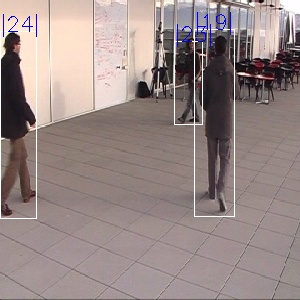

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: DeprecationWarning: 'inputs' property of IENetwork class is deprecated. To access DataPtrs user need to use 'input_data' property of InputInfoPtr objects which can be accessed by 'input_info' property.
  if sys.path[0] == '':


KeyboardInterrupt: 

In [17]:
from IPython.display import clear_output, Image, display, HTML
import cv2
import dlib
from dlib_tracker import CorrelationTracker

video = cv2.VideoCapture(TEST_VIDEO)
display_handle=display(None, display_id=True)


net, input_blob, output_blob = openvino_net(IE_MODEL_FP16_XML, IE_MODEL_FP16_BIN)
trackers = []

def iou_batch(bb_test, bb_gt):
    """
    From SORT: Computes IOU between two bboxes in the form [x1,y1,x2,y2]
    """
    bb_gt = np.expand_dims(bb_gt, 0)
    bb_test = np.expand_dims(bb_test, 0)
    xx1 = np.maximum(bb_test[..., 0], bb_gt[..., 0])
    yy1 = np.maximum(bb_test[..., 1], bb_gt[..., 1])
    xx2 = np.minimum(bb_test[..., 2], bb_gt[..., 2])
    yy2 = np.minimum(bb_test[..., 3], bb_gt[..., 3])
    w = np.maximum(0., xx2 - xx1)
    h = np.maximum(0., yy2 - yy1)
    wh = w * h
    o = wh / ((bb_test[..., 2] - bb_test[..., 0]) * (bb_test[..., 3] - bb_test[..., 1])
              + (bb_gt[..., 2] - bb_gt[..., 0]) * (bb_gt[..., 3] - bb_gt[..., 1]) - wh)
    return o

try:
    ret = True
    while ret:
        ret, frame = video.read()

        if ret:
            inference_start = time.time()
            resized_image = cv2.resize(frame, (WIDTH, WIDTH), interpolation=cv2.INTER_NEAREST)
            tracking = resized_image.copy()
            predictions, inference_time = ie_inference(net, resized_image, input_blob, output_blob)

            
            frame_for_output, preds = postprocessing(predictions[0][0], .4, resized_image)


            detections_ids = np.ones(len(preds), dtype=np.uint8)
            for tracker in trackers:
                if tracker.is_active:
                    tracker_bbox = np.array(tracker.predict(frame))
                    for i, pred in enumerate(preds):
                        pred_bbox = pred[3:7]*WIDTH
    #                     print(f'Tracker :{tracker_bbox}, prediction:  {pred_bbox}')
                        if detections_ids[i]==1 and iou_batch(tracker_bbox,  pred_bbox)>.4:
                            tracker.update(pred_bbox, frame)
                            detections_ids[i]=0
                            break
                
            for tracker in trackers:
                if tracker.time_since_update>10:
                    tracker.is_active = False

            # For every new detections create new tracker
            untracked_detections = preds[detections_ids==1]
            for det in untracked_detections:
                tracker = CorrelationTracker(det[3:7]*WIDTH, frame)
                trackers.append(tracker)
                    
            for tracker in trackers:
                if tracker.is_active:
                    x1,y1,x2,y2 = map(int, np.array(tracker.get_state()))
                    track_id = tracker.id
                    cv2.rectangle(tracking, (x1,y1), (x2,y2), (255,255,255), 1)
                    cv2.putText(tracking,  f'|{track_id}|', (x1,y1), cv2.FONT_HERSHEY_SIMPLEX , .7, (255,0,0), 1)

            
            inference_end = time.time()
#             print(1/(inference_end-inference_start))
            display_handle.update(Image(data=cv2.imencode('.jpeg', tracking)[1]))
except Exception as e:
    raise(e)
            
video.release()
display_handle.update(None)

In [18]:
!python3 ${INTEL_OPENVINO_DIR}/deployment_tools/open_model_zoo/tools/downloader/downloader.py \
--name person-detection-retail-0013 \
--output_dir ./data 

################|| Downloading models ||################

========== Downloading data/intel/person-detection-retail-0013/FP32/person-detection-retail-0013.xml
... 100%, 348 KB, 61182 KB/s, 0 seconds passed

========== Downloading data/intel/person-detection-retail-0013/FP32/person-detection-retail-0013.bin
... 100%, 2823 KB, 2325 KB/s, 1 seconds passed

========== Downloading data/intel/person-detection-retail-0013/FP16/person-detection-retail-0013.xml
... 100%, 348 KB, 128125 KB/s, 0 seconds passed

========== Downloading data/intel/person-detection-retail-0013/FP16/person-detection-retail-0013.bin
... 100%, 1411 KB, 1577 KB/s, 0 seconds passed

========== Downloading data/intel/person-detection-retail-0013/FP16-INT8/person-detection-retail-0013.xml
... 100%, 958 KB, 32083 KB/s, 0 seconds passed

========== Downloading data/intel/person-detection-retail-0013/FP16-INT8/person-detection-retail-0013.bin
... 100%, 752 KB, 1101 KB/s, 0 seconds passed

################|| Post-processing ||#

In [21]:
!python3 ${INTEL_OPENVINO_DIR}/deployment_tools/open_model_zoo/tools/downloader/downloader.py \
--name person-reidentification-retail-0270 \
--output_dir ./data 

################|| Downloading models ||################

========== Downloading data/intel/person-reidentification-retail-0270/FP32/person-reidentification-retail-0270.xml
... 100%, 423 KB, 83359 KB/s, 0 seconds passed

========== Downloading data/intel/person-reidentification-retail-0270/FP32/person-reidentification-retail-0270.bin
... 100%, 4790 KB, 1370 KB/s, 3 seconds passed

========== Downloading data/intel/person-reidentification-retail-0270/FP16/person-reidentification-retail-0270.xml
... 100%, 423 KB, 159242 KB/s, 0 seconds passed

========== Downloading data/intel/person-reidentification-retail-0270/FP16/person-reidentification-retail-0270.bin
... 100%, 2395 KB, 1340 KB/s, 1 seconds passed

========== Downloading data/intel/person-reidentification-retail-0270/FP16-INT8/person-reidentification-retail-0270.xml
... 100%, 1326 KB, 35061 KB/s, 0 seconds passed

========== Downloading data/intel/person-reidentification-retail-0270/FP16-INT8/person-reidentification-retail-0270.bin


In [22]:
import os
PEOPLE_DETECTOR = os.path.join('.', 'data', 'intel', 'person-detection-retail-0013', 'FP32')

PEOPLE_REID = os.path.join('.', 'data', 'intel', 'person-reidentification-retail-0270', 'FP32')
device = 'CPU'
SHAPE = (544, 320)

PEOPLE_DETECTOR_XML = os.path.join(PEOPLE_DETECTOR, 'person-detection-retail-0013.xml')
PEOPLE_DETECTOR_BIN = os.path.join(PEOPLE_DETECTOR, 'person-detection-retail-0013.bin')

PEOPLE_REID_XML = os.path.join(PEOPLE_REID, 'person-reidentification-retail-0270.xml')
PEOPLE_REID_BIN = os.path.join(PEOPLE_REID, 'person-reidentification-retail-0270.bin')
# Run the inference 

def run_on_image(xml:str, bin:str, device:str, image: np.ndarray, prints=True):
    net, input_blob, output_blob = openvino_net(xml, bin)
    resized_image = cv2.resize(frame, SHAPE, interpolation=cv2.INTER_NEAREST)
    predictions, inference_time = ie_inference(net, resized_image, input_blob, output_blob)
        
    if prints:
        print('Inference Time of SSD MobileNet V2: {} seconds'.format(inference_time))
    inference_engine_fps = 1 / inference_time

    if prints:
        print('Frames per second (FPS): {}'.format(inference_engine_fps))
    
    return inference_engine_fps, predictions

inference_engine_average_fps, preds = run_on_image(PEOPLE_DETECTOR_XML, 
                                                   PEOPLE_DETECTOR_BIN, 
                                                   device, frame)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: DeprecationWarning: 'inputs' property of IENetwork class is deprecated. To access DataPtrs user need to use 'input_data' property of InputInfoPtr objects which can be accessed by 'input_info' property.
  if sys.path[0] == '':


Inference Time of SSD MobileNet V2: 0.04989743232727051 seconds
Frames per second (FPS): 20.04111140311059


In [35]:
!pip3 install munkres scipy

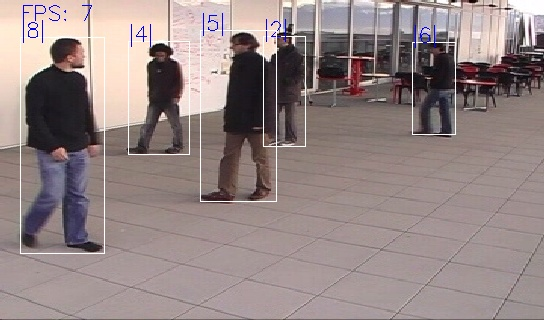

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: DeprecationWarning: 'inputs' property of IENetwork class is deprecated. To access DataPtrs user need to use 'input_data' property of InputInfoPtr objects which can be accessed by 'input_info' property.
  if sys.path[0] == '':


KeyboardInterrupt: 

In [53]:
from IPython.display import clear_output, Image, display, HTML
import cv2
from munkres import Munkres
from scipy.spatial import distance

video = cv2.VideoCapture(TEST_VIDEO)
display_handle=display(None, display_id=True)

_N = 0
_C = 1
_H = 2
_W = 3
DET_PROB_THRESH = .6
input_shape_reid = (128, 256)
COSINE_DIST_THRESH = .75
MAX_NON_DET_TRACK = 10

det_net, det_input_blob, det_output_blob = openvino_net(PEOPLE_DETECTOR_XML, PEOPLE_DETECTOR_BIN)
reid_net, reid_input_blob, reid_output_blob = openvino_net(PEOPLE_REID_XML, PEOPLE_REID_BIN)

class Detection:
    def __init__(self, bbox: tuple, feature_vector: np.array, id=-1):
        self.bbox = bbox 
        self.feature = feature_vector
        self.id=id
        
class Tracker:
    count = 0
    
    def __init__(self, first_det: Detection):
        self.last_det = first_det
        Tracker.count +=1
        self.id = Tracker.count
        self.time_from_last_update = 0
        
    def update(self, new_det: Detection):
        new_det.id = self.id
        self.last_det = new_det
        self.time_from_last_update = 0
        

trackers = []
try:
    ret = True
    while ret:
        ret, frame = video.read()
        
        if ret:
            inference_start = time.time()
            resized_image = cv2.resize(frame, SHAPE, interpolation=cv2.INTER_NEAREST)
            predictions, inference_time = ie_inference(det_net, resized_image, det_input_blob, det_output_blob)

            current_dets = []
            frame_for_output = resized_image.copy()
            preds = predictions[0][0]
            for pred in preds[preds[:,2]>DET_PROB_THRESH]:
                x1,y1,x2,y2 = np.int32([pred[3]*SHAPE[0], pred[4]*SHAPE[1], pred[5]*SHAPE[0], pred[6]*SHAPE[1]])
#                 cv2.rectangle(frame_for_output, (x1,y1), (x2,y2), (255,0,0), 2)

                if x1>0 and x2>0:
                    obj_img=frame_for_output[y1:y2,x1:x2]
                    obj_img=cv2.resize(obj_img, input_shape_reid)
                    reid_vector, inf_time = ie_inference(reid_net, obj_img, reid_input_blob, reid_output_blob)
                    reid_vector = reid_vector.reshape((256)) 

                    bbox=(x1,y1,x2,y2)
                    det = Detection(bbox, reid_vector)
                    current_dets.append(det)
                

             # Increase time counter
            for tracker in trackers:
                tracker.time_from_last_update+=1
                
            if len(trackers) > 0 and len(current_dets)>0:
                # Create cosine distance matrix and match objects in the frame and the DB
                hangarian = Munkres()
                dist_matrix = [ [ distance.cosine(det.feature, tracker.last_det.feature) 
                                for tracker in trackers ] for det in current_dets ]
                combination = hangarian.compute(dist_matrix)        # Solve matching problem



                for idx_det, idx_tracker in combination:
                    if current_dets[idx_det].id!=-1:             # This object has already been assigned an ID
                        continue
                    dist = distance.cosine(current_dets[idx_det].feature, trackers[idx_tracker].last_det.feature)
                    if dist < COSINE_DIST_THRESH:
                        trackers[idx_tracker].update(current_dets[idx_det])
                    
            # Create new trackers
            for det in current_dets:
                if det.id==-1:
                    trackers.append(Tracker(det))
                        
            # Draw tracker data
            for tracker in trackers:
                if tracker.time_from_last_update<6:
                    x1,y1,x2,y2 = tracker.last_det.bbox
                    track_id = tracker.id
                    cv2.rectangle(frame_for_output, (x1,y1), (x2,y2), (255,255,255), 1)
                    cv2.putText(frame_for_output,  f'|{track_id}|', (x1,y1), cv2.FONT_HERSHEY_SIMPLEX , .7, (255,0,0), 1)

            inference_end = time.time()
            cv2.putText(frame_for_output,  f'FPS: {int(1/(inference_end-inference_start))}', (20,20), cv2.FONT_HERSHEY_SIMPLEX , .7, (255,0,0), 1)
            display_handle.update(Image(data=cv2.imencode('.jpeg', frame_for_output)[1]))
except Exception as e:
    raise e
            
video.release()
display_handle.update(None)